## House Price Prediction - Advanced regression Assignment 



## Introduction

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

 

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

 

The company wants to know:

Which variables are significant in predicting the price of a house, and

How well those variables describe the price of a house.

 

Also, determine the optimal value of lambda for ridge and lasso regression.

 

## Business Goal 

 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

## Setup

### Import_Libraries



In [1]:
import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
import seaborn as sns # for visualization and data understanding
import matplotlib
import matplotlib.pyplot as plt # for visualization and data understanding
from datetime import datetime # To derive varibles from issue_date column
from tqdm import tqdm # thermometer
import missingno as mn # this library will be used for missingNa Analsysis
import plotly.express as px
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


# Printing the version of libraries used for reference:
print('numpy version:',np.__version__)
print('pandas version:',pd.__version__)
print('matplotlib: {}'.format(matplotlib.__version__))
print(sns.__version__)
print("Missingno Version : {}".format(mn.__version__))
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', 500)


numpy version: 1.21.5
pandas version: 1.4.2
matplotlib: 3.5.1
0.11.2
Missingno Version : 0.5.1


###  Reusable_Functions

In [2]:
# use variable names which can be overwritten downstream

#Create a log array this will containt the log such as why a column was deleted etc
logList__=[]

#upper limit for same kind of dagta default to 55 can be changed
UperLimitForSameData__=55
#null value limit used 85 instead
nullsLineValue=60

def DropColumnsSameNumValues(df,lmt=UperLimitForSameData__):
    '''
    purpose: drop columns with most of the values are same
    df: dataframe
    lmt=Limit for the upper limit. If the values are same till that limit
    the whoole column will be deleted
    return list
    
    '''
    #get the list
    ls=getListColumnsSameNumValues(df,lmt)
    #delete the column
    DropColumnsUsinglist(df,ls,'most of the values are same')    
    return ls

def getListColumnsSameNumValues(df,lmt=UperLimitForSameData__):
    '''
    purpose: return the list of columns with most of the valures are same
    df: dataframe
    lmt=Limit for the upper limit. If the values are same till that limit
    the whoole column will be deleted
    returns list
    '''
    ncount=dfinit.shape[0]
    lmt=lmt/100.00
#     get both numeric and non numeric columns
    numCols,ObjectCols=getNumObjectCols(df)
    #get the list
    ls=[c for c in numCols if ( (df[c].value_counts().reset_index().iloc[0,1] /ncount) > lmt)  ]
#     return the list
    return ls

# Function to log why the columns was dropped.
def myLog(logvalue,reason=''):
    '''
    purpose: Log anything with a reason
    logvalue: this could be anything
    reason=this will be reason behind this action
    '''
#   Get the current date time      
    now = datetime.now()
#     Log
    logList__.append([f'{now}', logvalue,reason] )
# Show the reasons why every columns was dropped by the end of cleaning

def getLogDF():
    '''
    purpose: convert the list to a dataframe and return it
    return DataFrame
    '''
    return pd.DataFrame (logList__, columns = ['DateTime','Log','Reason'])
def showLog():
    '''
    purpose: convert the list to a dataframe and return it
    return DataFrame
    '''
    return getLogDF()
#these varaibles are being used in several functions below
# so moved here to avoid any typing mistakes
P__='percn' 
C__='ColName'
V__='value'
def ListColumnsWithNaN(df):
    '''
    purpose: get the percnetage of missing or NA values
    df: dataframe
    return DataFrame
    '''
    #get the percentaage
    dm=(100*df.isna().mean()).reset_index()
    # the values returned will have 0 as column name so fix it
    df2 = dm.set_axis([C__, P__], axis=1, inplace=False)
    #now retuen the data
    return df2
def ListColumnsWithAllNaN(df):
    '''
    purpose: return the columns with all values are NA
    df: dataframe
    return columns with any values are NA
    '''
    df2=ListColumnsWithNaN(df)
    #return only those columns where all values are NAN
    return df2 [df2[P__]==100]


def ListColumnsWithAnyNaN(df):  
    '''
    purpose: return the columns with any values  NA
    df: dataframe
    return columns with any values are NA
    '''
    df2=ListColumnsWithNaN(df)
     #return  those columns where any values are NAN
    return df2 [df2[P__]>0]

def ListColumnsWithAnyNaNSorted(df):  
    '''
    purpose: return the columns with any values  NA and sorted
    df: dataframe
    return columns with any values are NA sorted
    '''
    df2=ListColumnsWithAnyNaN(df)
     #return  those columns where any values are NAN
    return df2.sort_values(by=P__,ascending=False)


def ListColumnsWithAnyNaNDesc(df):
    '''
    purpose: return the columns with in descending order
    df: dataframe
    return columns with any values are NA in descending order
    '''
    df2=ListColumnsWithNaN(df)
    #return  those columns where any 
    #values are NAN and sort by percnt descending
    
    return df2.sort_values(P__, ascending=False)
def getListofObjectColumns(df):
    '''
    purpose: return the columns list of type object
    df: dataframe
    return list
    '''

    return list(df.head(1).select_dtypes(include=['object']).T\
         .reset_index()['index'])
def getListofNumberColumns(df):
    '''
    purpose: return the columns list of numeric columns
    df: dataframe
    return list
    '''

    numerics = ['int16', 'int32', 'int64','float64']
    return df.head(1).select_dtypes(include=numerics).T\
         .reset_index()['index'].tolist()

def showNANMatrix(df):
    '''
    purpose: abstraction laywer to show matrix for nan values
    df: dataframe
    '''

    mn.matrix(df,labels=True,)
def ColumnsWithAnyPGE(df,prcnt=nullsLineValue): 
    '''
    purpose: columns with NA > given prcnt 
    df: dataframe
    prcnt: limit for percentage
    return dataframe
    '''
    df2=ListColumnsWithNaN(df)
     #return  those columns where any values are NAN
    return df2 [df2[P__]>=prcnt]


def ListColumnsWithPGE(df,prcnt=nullsLineValue):  
    '''
    purpose: list columns wiht nan Perctage is greatre than or equal ot prcnt
    df: dataframe
    prcnt: limit for percentage
    return list
    '''

    return ColumnsWithAnyPGE(df,prcnt)[C__].tolist()
def DeleteColumn(df,cName,reason):

    '''
    purpose: Delete column if exists
    
    df: dataframe
    cName: column name
    reason: reason why that column is being deleted. this will be logged
    
    return None
    '''

    if cName in df.columns: # if column exists to avoid exception
        #delete
        del df[cName]
        #log
        myLog(f'Deleting column {cName}',reason)
def DropColumnsWithAllNan(df):
    
    '''
    purpose: Delete column with all Nan values
    
    df: dataframe
      
    return None
    '''

    # cannot use dropna as we have to log the data as well
#     ret=df.dropna(axis='columns',how='all')
    ls=ListColumnsWithAllNaN(df)[C__].tolist()
    #now drop
    DropColumnsUsinglist(df,ls,'All values are NaN')
def DropColumnsWithNANGreaterthanlimit(df,prcnt):
    
    '''
    purpose: Delete column with  Nan greater than prcnt
    
    df: dataframe
    prcnt: percentage
      
    return None
    '''

    DropColumnsUsinglist(df,ListColumnsWithPGE(df,prcnt),'Most of the vlaues are null')

def DropColumnsUsinglist(pDf,ls,reason):
    '''
    purpose: Delete column in the list
    
    PDf: dataframe
    ls: list of columns
    reason: reason
      
    return None
    '''
    for c in ls:
        DeleteColumn(pDf,c,reason)
def DropColumnsWithOnlyOneValue(df):     
    '''
    purpose: Delete columns with only one value
    
    df: dataframe
    return None
    '''

    [DeleteColumn(df,c,'Column with only one value') \
          for c in getColumnsWithOnlyOneValue(df)]
           
def getColumnsWithOnlyOneValue(df):
    '''
    purpose: return the list of columns with only one value
    
    df: dataframe
    return None
    '''

    return [c for c in df.columns if df[c].value_counts().count()==1]

def showBoxSubPlots(df):
    '''
    purpose: show boxs sub plots using the dataframe
    
    df: dataframe
    return None
    '''

    #get the numeric columns
    NumCols,CatCols=getNumObjectCols(df)
#     shw the plot
    showBoxSubPlotsUsingList(df,NumCols)
    
def showBoxSubPlotsUsingList(df,ls,figs=(20,16)):
    '''
    purpose: show boxs sub plots using the list
    
    df: dataframe
    ls: list of numeric columns
    figs=(20,16) default figure size
    return None
    '''
   
    plt.figure(figsize=figs)
    ln=len(ls)
    cols=4
    rows=(ln//cols)+1
    #show thermometer
    for i in tqdm( range(ln)):
        c=ls[i]
        plt.subplot(rows,cols,i+1)
        #plot
        df[c].plot(kind='box',title=f'Plot for {c}')

def getOutliers(df,c):
    '''
    purpose: get Outliers
    
    df: dataframe
    c: name of the column
    return tuple of outliers, the sise and percentage
    '''
    #calculate upper and lower whiskers
    data=df[c]
    median = np.median(data)
    upper_quartile = np.percentile(data, 75)
    lower_quartile = np.percentile(data, 25)

    iqr = upper_quartile - lower_quartile
    upper_whisker = data[data<=upper_quartile+1.5*iqr].max()
    lower_whisker = data[data>=lower_quartile-1.5*iqr].min()
    outliers=((df[c]< lower_whisker) | (df[c]>upper_whisker))
#     return the data
    return outliers,df[outliers].shape[0], 100*df[outliers].shape[0]/df.shape[0]



from IPython.display import Markdown, display
def printmd(string):
    '''
    purpose: print string as markdown 
    
    string: string to display
     return nothing
    '''

    display(Markdown(string))
    

def RemoveOutliers(df,excludelist=[]):
    '''
    purpose: remove outliers and leave behind columns in excludelist
    df: dataframe
    excludelist: columns which will not be processed
     return nothing
    '''

    NumCols,CatCols=getNumObjectCols(df)
    for c in NumCols:
        if c not in excludelist:
            df=RemoveOutlier(df,c)
    return df
from IPython.display import display_html
from itertools import chain,cycle
def displaySideBySide(*args,Titles=cycle([''])):
    
    '''
    purpose: display tables side by side
    *args: array of arguments
    Titles: Itertools for titles
      return nothing
    '''

    html=''
    #loop through args and titles and zip them togethre
    for df,title in zip(args, chain(Titles,cycle(['</br>'])) ):
        #create the table header 
        html+='<th style="text-align:center"><td style="vertical-align:top">'
        #display the heading
        html+=f'<h2 style="text-align: center;">{title}</h2>'
        #apply the style to the table
        html+=df.to_html().replace('table','table style="display:inline"')
        #clsoing tags
        html+='</td></th>'
    #dispay the html    
    display_html(html,raw=True)

def getObjectsWihtAnyMissingValue(df,prcnt=1):
    
    '''
    purpose: return the list of columns with missing percnt is <=prnct
    df: dataframe
    prcnt: percentage
    return the dataframe
    '''

    cnts=ListColumnsWithAnyNaN(df).round(2)
    return cnts[cnts.percn<=prcnt]
def getDescription(keyName):
   
    '''
    purpose: Get the description of a column
    keyNames: column name
    return the description
    '''
    #if not found in dictionary it's mean it is a calculated field
    retval=['Calculated Field']
    
    if keyName in dtDict__.keys():
        retval=dtDict__[keyName]
    return retval
def displayDescription(keyNames):
   
    '''
    purpose: displayDescription
    keyNames: column name

    return nothing
    '''

    [printmd(f'<b>{c}</b>: {getDescription(c)[0]}') for c in keyNames]



def getNumObjectCols(df):
  
    '''
    purpose: return the numeric and object columns as a tuple
    df: dataframe

    return the numeric and object columns as a tuple
    '''

    objtypes=['object','category']
    NumCols=[c for c in df.columns if df[c].dtype.name not in objtypes ]
    CatCols=[c for c in df.columns if df[c].dtype.name in objtypes ]
    return NumCols,CatCols
def drawplotly(pDf,pPath,pValueFieldName, pColorBasedOn,pHoverData):
  
    '''
    purpose: Draw a treemap and show the heat
    pDf: dataframe
    pPath: the hierarchy to be displayed this could be like country,state,zip
    pValueFieldName: The size of the box will be based on this column
    pColorBasedOn: the color of the box will be based on this column
    pHoverData: when we hover the mouse this will be dispalyed along with other columns

    return nothing
    '''
    fig = px.treemap(pDf, 
                      path=pPath, 
                      values=pValueFieldName,
                      color=pColorBasedOn, 
                      color_continuous_scale='Turbo',
                      hover_data=[pHoverData],
                      color_continuous_midpoint=np.average(pDf[pColorBasedOn], 
                      weights=pDf[pValueFieldName]))
    #define margin
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    #update layout
    fig.update_layout(
        autosize=True,
        height=800,
        showlegend=False
    )
    fig.show()

def UnivariantAnalysis(df,colName,xlabel,ylabel ):
 
    '''
    purpose: create box and kde plots side by side for univariant analysis
    df: dataframe
    colName: the name of the column
    xlabel:xlabel in the plot also will be used in title
    ylable for the ylable of the plot will be removed
    
    return nothing
    '''

    col=df[colName]

      
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
    col.plot(kind='kde',title=f'KDE for {xlabel}',ax=ax1)

    col.plot(kind='box',title=f'Boxplot for {xlabel}',ax=ax2)
    ax2.set_xlabel=xlabel
    plt.show()

    print(f'\nmedian\t  {col.median()}')
    print(col.describe().round(2))


ylbl='# of properties'

# Plot pie and Countplot for 1 variable.
def ShowPieAndCountPlot(df,colName,xlabel,ylabel=ylbl,fsize=(8,6),angl=0):
    '''
    This function shows the countplot
    df: dataframe
    colName: the name of the column
    xlabel=xlabel of the plot
    ylabel=ylabel of the plot
    fsize=figure size
    return value: none
    '''
    ShowCountPlot(dfinit,colName,xlabel,fsize=(20,12)) 
    PlotPie(dfinit,colName,xlabel,fsize=(600,350))



def setax(ax,xlabel,ylabel,angl):
    '''
    This function sets the axis parameter
    xlabel=xlabel of the plot
    ylabel=ylabel of the plot
    return value: none
    '''
 
    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)

    ax.yaxis.set_major_formatter(\
                    mpl.ticker.StrMethodFormatter('{x:,.0f}')\
                                )

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    for p in ax.patches:
        ax.annotate('{:,.0f}'.format(p.get_height()), \
                    (p.get_x(), p.get_height()),weight='bold',fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=angl)
def ShowBadLoanBarGraph(df,colName):
    '''
    purpose: show the Bar graph of the values counts of bad loans
    df: dataframe
    colName: column Name
    '''
    df2=df[df["Status"]==bd]
    df2=df2[colName].value_counts().reset_index()

    ax=sns.barplot(data=df2,x='index',y=colName)
    ax.set(title=f'Default Loans for {colName}')
    setax(ax,colName,"# of default Loans",90)
    plt.show()
def getListColumnsSameAllValuesSame(df):
    '''
    purpose: return the list of columns with most of the valures are same
    df: dataframe
    lmt=Limit for the upper limit. If the values are same till that limit
    the whoole column will be deleted
    returns list
    '''
#     get both numeric and non numeric columns
    numCols,ObjectCols=getNumObjectCols(df)
    #get the list
  
    ls=[c for c in numCols if df[c].value_counts().reset_index().iloc[0,1]==df.shape[0]]
#     return the list
    return ls


# Plots count plot for one variable 
def ShowCountAndSalesPlot(df,colName,xlabel,ylabel=ylbl,fsize=(20,8),angl=0):
    '''
    This function shows the countplot
    df: dataframe
    colName: the name of the column
    xlabel=xlabel of the plot
    ylabel=ylabel of the plot
    fsize=figure size
    return value: none
    '''
    plt.figure(figsize=fsize)
    ax = sns.countplot(df[colName])
    setax(ax,xlabel,"Properties Sold",angl)
    plt.title(f"Counts of properties sold with respect to {xlabel}")

    plt.show()
    
    plt.figure(figsize=fsize)
    ax=sns.barplot(x=colName, y="SalePrice", data= df)
    setax(ax,xlabel,"Sales Price",angl)
    plt.title(f"Sales Price with respect to {xlabel}")
#     plt.xticks(rotation=90)
    plt.show()
    

## 2.0 Import Data

In [3]:
# Reading data using pandas the dataframe will be named(dfinit)
dfinit=pd.read_csv('train.csv')


## 3.0 Data understanding

In [4]:
printmd(f'##### There are {dfinit.shape[0]:,} rows and {dfinit.shape[1]:,} columns') 

##### There are 1,460 rows and 81 columns

In [5]:
# Have a quick look on the first 5 rows of the loan dataset.
dfinit.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
dfinit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
# Exploring the data numerical columns and checking some numbers:
dfinit.describe().T

count           mean           std      min        25%  \
Id             1460.0     730.500000    421.610009      1.0     365.75   
MSSubClass     1460.0      56.897260     42.300571     20.0      20.00   
LotFrontage    1201.0      70.049958     24.284752     21.0      59.00   
LotArea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
OverallQual    1460.0       6.099315      1.382997      1.0       5.00   
OverallCond    1460.0       5.575342      1.112799      1.0       5.00   
YearBuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
YearRemodAdd   1460.0    1984.865753     20.645407   1950.0    1967.00   
MasVnrArea     1452.0     103.685262    181.066207      0.0       0.00   
BsmtFinSF1     1460.0     443.639726    456.098091      0.0       0.00   
BsmtFinSF2     1460.0      46.549315    161.319273      0.0       0.00   
BsmtUnfSF      1460.0     567.240411    441.866955      0.0     223.00   
TotalBsmtSF    1460.0    1057.429452    438.705324      0.0     795.75   
1stFlrSF       1460.0    1162.626712    386.587738    334.0     882.00   
2ndFlrSF       1460.0     346.992466    436.528436      0.0       0.00   
LowQualFinSF   1460.0       5.844521     48.623081      0.0       0.00   
GrLivArea      1460.0    1515.463699    525.480383    334.0    1129.50   
BsmtFullBath   1460.0       0.425342      0.518911      0.0       0.00   
BsmtHalfBath   1460.0       0.057534      0.238753      0.0       0.00   
FullBath       1460.0       1.565068      0.550916      0.0       1.00   
HalfBath       1460.0       0.382877      0.502885      0.0       0.00   
BedroomAbvGr   1460.0       2.866438      0.815778      0.0       2.00   
KitchenAbvGr   1460.0       1.046575      0.220338      0.0       1.00   
TotRmsAbvGrd   1460.0       6.517808      1.625393      2.0       5.00   
Fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
GarageYrBlt    1379.0    1978.506164     24.689725   1900.0    1961.00   
GarageCars     1460.0       1.767123      0.747315      0.0       1.00   
GarageArea     1460.0     472.980137    213.804841      0.0     334.50   
WoodDeckSF     1460.0      94.244521    125.338794      0.0       0.00   
OpenPorchSF    1460.0      46.660274     66.256028      0.0       0.00   
EnclosedPorch  1460.0      21.954110     61.119149      0.0       0.00   
3SsnPorch      1460.0       3.409589     29.317331      0.0       0.00   
ScreenPorch    1460.0      15.060959     55.757415      0.0       0.00   
PoolArea       1460.0       2.758904     40.177307      0.0       0.00   
MiscVal        1460.0      43.489041    496.123024      0.0       0.00   
MoSold         1460.0       6.321918      2.703626      1.0       5.00   
YrSold         1460.0    2007.815753      1.328095   2006.0    2007.00   
SalePrice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                    50%        75%       max  
Id                730.5    1095.25    1460.0  
MSSubClass         50.0      70.00     190.0  
LotFrontage        69.0      80.00     313.0  
LotArea          9478.5   11601.50  215245.0  
OverallQual         6.0       7.00      10.0  
OverallCond         5.0       6.00       9.0  
YearBuilt        1973.0    2000.00    2010.0  
YearRemodAdd     1994.0    2004.00    2010.0  
MasVnrArea          0.0     166.00    1600.0  
BsmtFinSF1        383.5     712.25    5644.0  
BsmtFinSF2          0.0       0.00    1474.0  
BsmtUnfSF         477.5     808.00    2336.0  
TotalBsmtSF       991.5    1298.25    6110.0  
1stFlrSF         1087.0    1391.25    4692.0  
2ndFlrSF            0.0     728.00    2065.0  
LowQualFinSF        0.0       0.00     572.0  
GrLivArea        1464.0    1776.75    5642.0  
BsmtFullBath        0.0       1.00       3.0  
BsmtHalfBath        0.0       0.00       2.0  
FullBath            2.0       2.00       3.0  
HalfBath            0.0       1.00       2.0  
BedroomAbvGr        3.0       3.00       8.0  
KitchenAbvGr        1.0       1.00       3.0  
T

In [8]:
# Checking Count of datatypes for all columns of the dataset:
dfinit.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

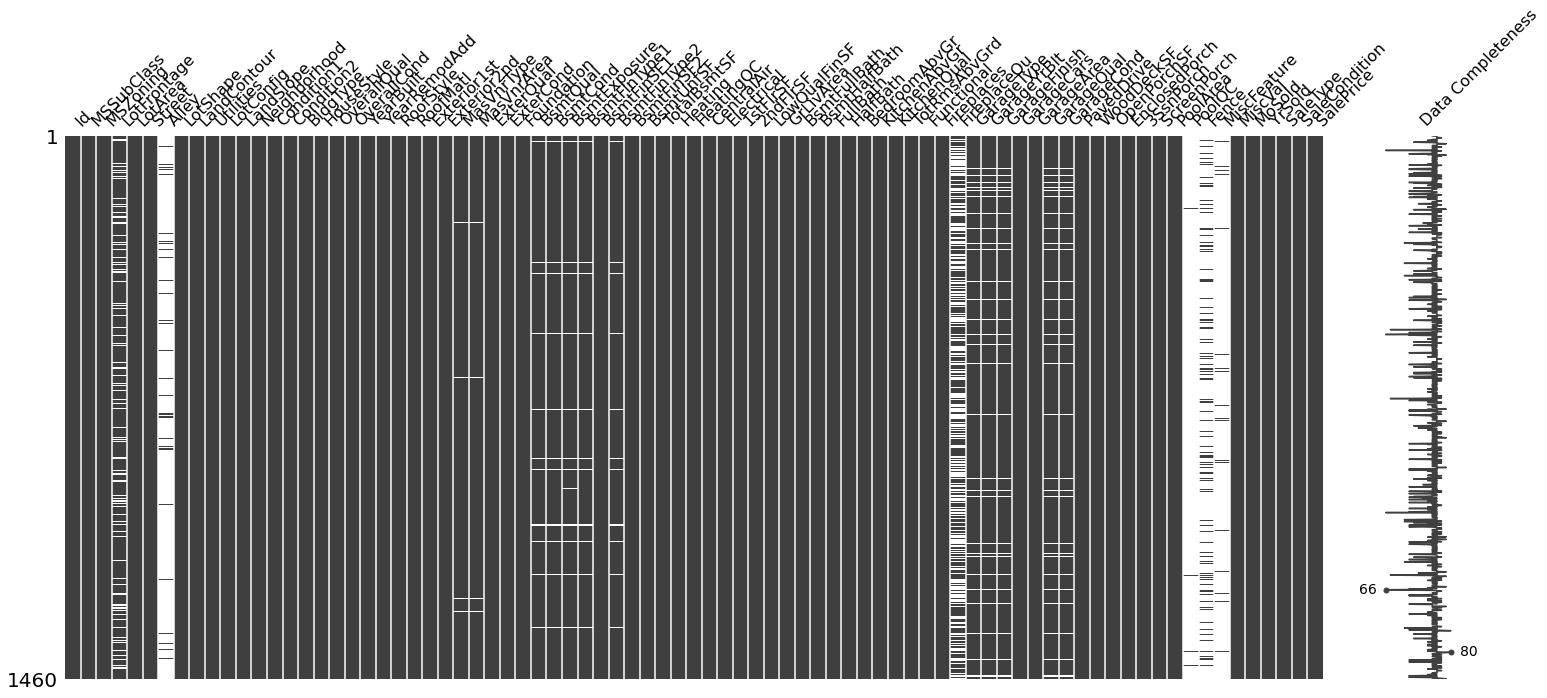

In [9]:
#ko rotate lables
# Exploring all columns wiht null values in a matrix form 
showNANMatrix(dfinit)

In [10]:
# Check for % of null values in the dataframe:
str(round((dfinit.isnull().sum().sum())/(dfinit.shape[0]*dfinit.shape[1])*100,2))+'%'

'5.89%'

### Overall, 5.89 % of the data is Null.

## Now inspect the null columns in detail,


In [11]:
# Creating a dataframe to display percentage of null values in each column
a = pd.DataFrame()
a['Percentage of null values']=['15% or less','80% or more']

fifteen_percent = len(dfinit.columns[((dfinit.isnull().sum())/len(dfinit)) < 0.15])
eightyfive_percent= len(dfinit.columns[((dfinit.isnull().sum())/len(dfinit)) >= 0.80])
a['No.of columns'] = [fifteen_percent,eightyfive_percent]
a

Percentage of null values  No.of columns
0               15% or less             75
1               80% or more              4

## Findings
From above, we can tell that four columns have equal to or more than 80% null values; thus, we will remove all of them.
### Find the details of null values 

In [12]:
#get the list
ListColumnsWithAnyNaNSorted(dfinit)

ColName      percn
72        PoolQC  99.520548
74   MiscFeature  96.301370
6          Alley  93.767123
73         Fence  80.753425
57   FireplaceQu  47.260274
3    LotFrontage  17.739726
58    GarageType   5.547945
59   GarageYrBlt   5.547945
60  GarageFinish   5.547945
63    GarageQual   5.547945
64    GarageCond   5.547945
32  BsmtExposure   2.602740
35  BsmtFinType2   2.602740
33  BsmtFinType1   2.534247
31      BsmtCond   2.534247
30      BsmtQual   2.534247
26    MasVnrArea   0.547945
25    MasVnrType   0.547945
42    Electrical   0.068493

## Does NA mean 'Unknown'
Let’s inspect these columns further, e.g., if we consider the column `PoolQC` and check the data dictionary (`data_description.txt`) we will find following values.

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
You can see that NA does not mean ‘Unknown’ but rather ‘No Pool’ 

The following columns have the same kind of behavior, so we will impute them with the value ‘NONE’:
“Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature" 





In [13]:
NAVars = ["Alley","MasVnrType",  "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
for i in NAVars:
    dfinit[i].fillna("NONE", inplace=True)

In [14]:
#inspect the null values again
ListColumnsWithAnyNaNSorted(dfinit)

ColName      percn
3   LotFrontage  17.739726
59  GarageYrBlt   5.547945
26   MasVnrArea   0.547945
42   Electrical   0.068493

## Let's inspect the above columns

In [15]:
dfinit[['LotFrontage','GarageYrBlt','MasVnrArea']].describe()

LotFrontage  GarageYrBlt   MasVnrArea
count  1201.000000  1379.000000  1452.000000
mean     70.049958  1978.506164   103.685262
std      24.284752    24.689725   181.066207
min      21.000000  1900.000000     0.000000
25%      59.000000  1961.000000     0.000000
50%      69.000000  1980.000000     0.000000
75%      80.000000  2002.000000   166.000000
max     313.000000  2010.000000  1600.000000

In [16]:
dfinit[['Electrical']].describe()

Electrical
count        1459
unique          5
top         SBrkr
freq         1334

### LotFrontage
Let’s first inspect the feature `LotFrontag’.Following is the excerpt from the data dictionary:
LotFrontage: Linear feet of street connected to property

Since this is a numeric variable, we can impute its value from the median of the same neighborhood



In [17]:
dfinit['LotFrontage'] = dfinit.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))


### imputing values for 'GarageYrBlt','MasVnrArea','Electrical'
from describe functions output, we can see the distribution of values and impute the values of features 'GarageYrBlt','MasVnrArea' with its median value, and 'Electrical' with its top-used value 'SBrkr'.


In [18]:
dfinit["GarageYrBlt"].fillna(dfinit["GarageYrBlt"].median(), inplace=True)
dfinit["MasVnrArea"].fillna(dfinit["MasVnrArea"].mean(), inplace=True)

dfinit["Electrical"].fillna('SBrkr', inplace=True)

## Inspect duplicate data 

In [19]:
# Checking for duplicate columns in the dataframe:
dfinit.duplicated().sum()

0

<b>Since there is no duplicate data there is no need to do anything here: </b>

##### Show the null matrix again and inspect

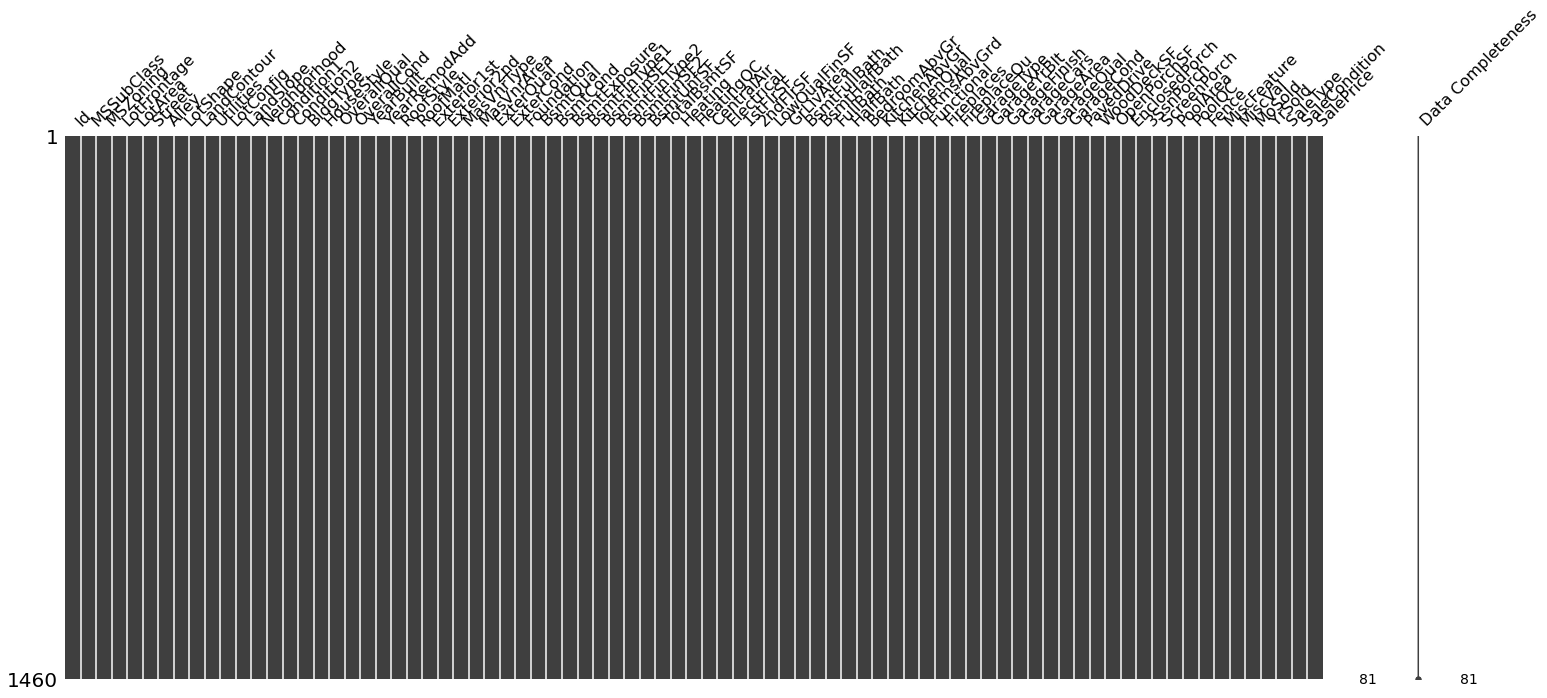

In [20]:
# Drop the columns with all null values
# DropColumnsWithAllNan(dfinit)
# Drop the columns having more then 85% null values
# DropColumnsWithNANGreaterthanlimit(dfinit,prcnt=80)
# View the data now
showNANMatrix(dfinit)

### From the above figure, we can see that all the null values are taken care of.

###  Invalid data inpection
Checking all columns with object type in the data set:

In [21]:
# Instead of checking each column of 55 columns like above, here we are running a for loop on top of 'object' columns and take a decison based on the output of this cell.
for i in dfinit.columns[dfinit.dtypes == 'object']:
    print(f'{dfinit[i].value_counts()}')
    print('-'*30+'\n')
    

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
------------------------------

Pave    1454
Grvl       6
Name: Street, dtype: int64
------------------------------

NONE    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
------------------------------

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
------------------------------

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
------------------------------

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
------------------------------

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
------------------------------

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
------------------------------

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes  

**Insight**:
    
From the above list we can see that there are no invalid values and we don't need to fix any data

### 3.3.5 Drop columns having only one value in them (if any). 


#### Find and drop features with one value (if any)

In [22]:
# Checking all numerical columns with one value:
getColumnsWithOnlyOneValue(dfinit)
# There are also few non-useful numerical columns.We are dropping these numerical columns with one value after examining them above. 


[]

#### Dropping columns with only one value and showing the final shape of the dataframe.

In [23]:
# There are also few non-useful numerical columns.We are dropping these numerical columns with one value after examining them above. 

DropColumnsWithOnlyOneValue(dfinit)
dfinit.shape

(1460, 81)

<b> Now inspect those numeric columns where more than 85% of data has one value. These columns can be removed </b>

In [24]:
getListColumnsSameNumValues(dfinit,85)

['BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [25]:
# Checking 0 counts in above columns:
ls=getListColumnsSameNumValues(dfinit,85)
for c in ls:
    print(f'There are/is {dfinit[c].nunique()} unique value(s) in column:{c} ')
    print(f'-'*30)
    print(f'Value Counts for {c}')
    print(dfinit[c].value_counts())
    print(f'*'*30)

There are/is 144 unique value(s) in column:BsmtFinSF2 
------------------------------
Value Counts for BsmtFinSF2
0       1293
180        5
374        3
551        2
147        2
294        2
391        2
539        2
96         2
480        2
182        2
468        2
117        2
64         2
290        2
469        2
279        2
287        2
93         2
712        2
41         2
149        1
1061       1
466        1
396        1
354        1
215        1
841        1
273        1
465        1
400        1
682        1
557        1
230        1
193        1
411        1
634        1
324        1
486        1
500        1
823        1
435        1
1085       1
345        1
764        1
377        1
128        1
630        1
127        1
106        1
791        1
240        1
276        1
163        1
627        1
110        1
872        1
352        1
334        1
546        1
420        1
105        1
972        1
173        1
68         1
661        1
608        1
547        1
90

**Insigt:**
From the list above, we can see the same value was populated over 85% times which does not help in determining the target variable, so let’s remove these columns

In [26]:
# Dropping columns:
DropColumnsSameNumValues(dfinit,85)

['BsmtFinSF2',
 'LowQualFinSF',
 'BsmtHalfBath',
 'KitchenAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal']

In [27]:

# Validating the column is dropped:
getListColumnsSameNumValues(dfinit,85)

[]

### Analyze columns with all unique values
<b>Analyze some of the columns such as id and see if they can be removed</b>

In [28]:
# inspect the unique values
dfinit.nunique()

Id               1460
MSSubClass         15
MSZoning            5
LotFrontage       115
LotArea          1073
Street              2
Alley               3
LotShape            4
LandContour         4
Utilities           2
LotConfig           5
LandSlope           3
Neighborhood       25
Condition1          9
Condition2          8
BldgType            5
HouseStyle          8
OverallQual        10
OverallCond         9
YearBuilt         112
YearRemodAdd       61
RoofStyle           6
RoofMatl            8
Exterior1st        15
Exterior2nd        16
MasVnrType          5
MasVnrArea        328
ExterQual           4
ExterCond           5
Foundation          6
BsmtQual            5
BsmtCond            5
BsmtExposure        5
BsmtFinType1        7
BsmtFinSF1        637
BsmtFinType2        7
BsmtUnfSF         780
TotalBsmtSF       721
Heating             6
HeatingQC           5
CentralAir          2
Electrical          5
1stFlrSF          753
2ndFlrSF          417
GrLivArea         861
BsmtFullBa

## Finding
As we can see that the columns have same amount of unique values (1460) as the shape of the dataframe. This implies that all the values are unique which will not be helpful in our analysis so let's remove them</b>

In [29]:
# Deleting the columns mentioned above:
cols=["Id"]
DropColumnsUsinglist(dfinit,cols,'All unique values')

## Mappings
Define the mappings of categorial variables, so that they are easier to understand

In [30]:
# maped the season column according to descripttions
#(1:spring, 2:summer, 3:fall, 4:winter)

dictcond ={ 1:'Very Poor', 
            2:'Poor', 3:'Fair', 4:'Below Average',
            5:'Average', 6:'Above Average', 7:'Good',
            8:'Very Good',9:'Excellent',10:'Excellent'}


col='OverallCond'
dfinit[f'{col}'] = dfinit[col].map(dictcond)
col='OverallQual'
dfinit[f'{col}'] = dfinit[col].map(dictcond)
col='MSSubClass'
dictcond ={20:'1-STORY 1946 & NEWER ALL STYLES',     
    30:   '1-STORY 1945 & OLDER', 
    40:   '1-STORY W/FINISHED ATTIC ALL AGES', 
    45:   '1-1/2 STORY - UNFINISHED ALL AGES', 
    50:   '1-1/2 STORY FINISHED ALL AGES', 
    60:   '2-STORY 1946 & NEWER', 
    70:   '2-STORY 1945 & OLDER', 
    75:   '2-1/2 STORY ALL AGES', 
    80:   'SPLIT OR MULTI-LEVEL', 
    85:   'SPLIT FOYER', 
    90:   'DUPLEX - ALL STYLES AND AGES', 
   120:   '1-STORY PUD (Planned Unit Development) - 1946 & NEWER', 
   150:   '1-1/2 STORY PUD - ALL AGES', 
   160:   '2-STORY PUD - 1946 & NEWER', 
   180:   'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', 
   190:   '2 FAMILY CONVERSION - ALL STYLES AND AGES', }
dfinit[f'{col}'] = dfinit[col].map(dictcond)

## Review cateogrial columns

In [31]:
## View the unique values of all Categorical columns
numCols,ObjectCols=getNumObjectCols(dfinit)
for col in ObjectCols:
    printmd(f'**{col}**')
    print(dfinit[col].unique(), '\n')

**MSSubClass**

['2-STORY 1946 & NEWER' '1-STORY 1946 & NEWER ALL STYLES'
 '2-STORY 1945 & OLDER' '1-1/2 STORY FINISHED ALL AGES'
 '2 FAMILY CONVERSION - ALL STYLES AND AGES'
 '1-1/2 STORY - UNFINISHED ALL AGES' 'DUPLEX - ALL STYLES AND AGES'
 '1-STORY PUD (Planned Unit Development) - 1946 & NEWER'
 '1-STORY 1945 & OLDER' 'SPLIT FOYER' 'SPLIT OR MULTI-LEVEL'
 '2-STORY PUD - 1946 & NEWER' '2-1/2 STORY ALL AGES'
 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'
 '1-STORY W/FINISHED ATTIC ALL AGES'] 



**MSZoning**

['RL' 'RM' 'C (all)' 'FV' 'RH'] 



**Street**

['Pave' 'Grvl'] 



**Alley**

['NONE' 'Grvl' 'Pave'] 



**LotShape**

['Reg' 'IR1' 'IR2' 'IR3'] 



**LandContour**

['Lvl' 'Bnk' 'Low' 'HLS'] 



**Utilities**

['AllPub' 'NoSeWa'] 



**LotConfig**

['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'] 



**LandSlope**

['Gtl' 'Mod' 'Sev'] 



**Neighborhood**

['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste'] 



**Condition1**

['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe'] 



**Condition2**

['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe'] 



**BldgType**

['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs'] 



**HouseStyle**

['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin'] 



**OverallQual**

['Good' 'Above Average' 'Very Good' 'Average' 'Excellent' 'Below Average'
 'Fair' 'Very Poor' 'Poor'] 



**OverallCond**

['Average' 'Very Good' 'Above Average' 'Good' 'Below Average' 'Poor'
 'Fair' 'Excellent' 'Very Poor'] 



**RoofStyle**

['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed'] 



**RoofMatl**

['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile'] 



**Exterior1st**

['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock'] 



**Exterior2nd**

['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock'] 



**MasVnrType**

['BrkFace' 'None' 'Stone' 'BrkCmn' 'NONE'] 



**ExterQual**

['Gd' 'TA' 'Ex' 'Fa'] 



**ExterCond**

['TA' 'Gd' 'Fa' 'Po' 'Ex'] 



**Foundation**

['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone'] 



**BsmtQual**

['Gd' 'TA' 'Ex' 'NONE' 'Fa'] 



**BsmtCond**

['TA' 'Gd' 'NONE' 'Fa' 'Po'] 



**BsmtExposure**

['No' 'Gd' 'Mn' 'Av' 'NONE'] 



**BsmtFinType1**

['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'NONE' 'LwQ'] 



**BsmtFinType2**

['Unf' 'BLQ' 'NONE' 'ALQ' 'Rec' 'LwQ' 'GLQ'] 



**Heating**

['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor'] 



**HeatingQC**

['Ex' 'Gd' 'TA' 'Fa' 'Po'] 



**CentralAir**

['Y' 'N'] 



**Electrical**

['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix'] 



**KitchenQual**

['Gd' 'TA' 'Ex' 'Fa'] 



**Functional**

['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev'] 



**FireplaceQu**

['NONE' 'TA' 'Gd' 'Fa' 'Ex' 'Po'] 



**GarageType**

['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'NONE' 'Basment' '2Types'] 



**GarageFinish**

['RFn' 'Unf' 'Fin' 'NONE'] 



**GarageQual**

['TA' 'Fa' 'Gd' 'NONE' 'Ex' 'Po'] 



**GarageCond**

['TA' 'Fa' 'NONE' 'Gd' 'Po' 'Ex'] 



**PavedDrive**

['Y' 'N' 'P'] 



**PoolQC**

['NONE' 'Ex' 'Fa' 'Gd'] 



**Fence**

['NONE' 'MnPrv' 'GdWo' 'GdPrv' 'MnWw'] 



**MiscFeature**

['NONE' 'Shed' 'Gar2' 'Othr' 'TenC'] 



**SaleType**

['WD' 'New' 'COD' 'ConLD' 'ConLI' 'CWD' 'ConLw' 'Con' 'Oth'] 



**SaleCondition**

['Normal' 'Abnorml' 'Partial' 'AdjLand' 'Alloca' 'Family'] 



## Let's review all the cateogrial variables for counts and SalesPrice

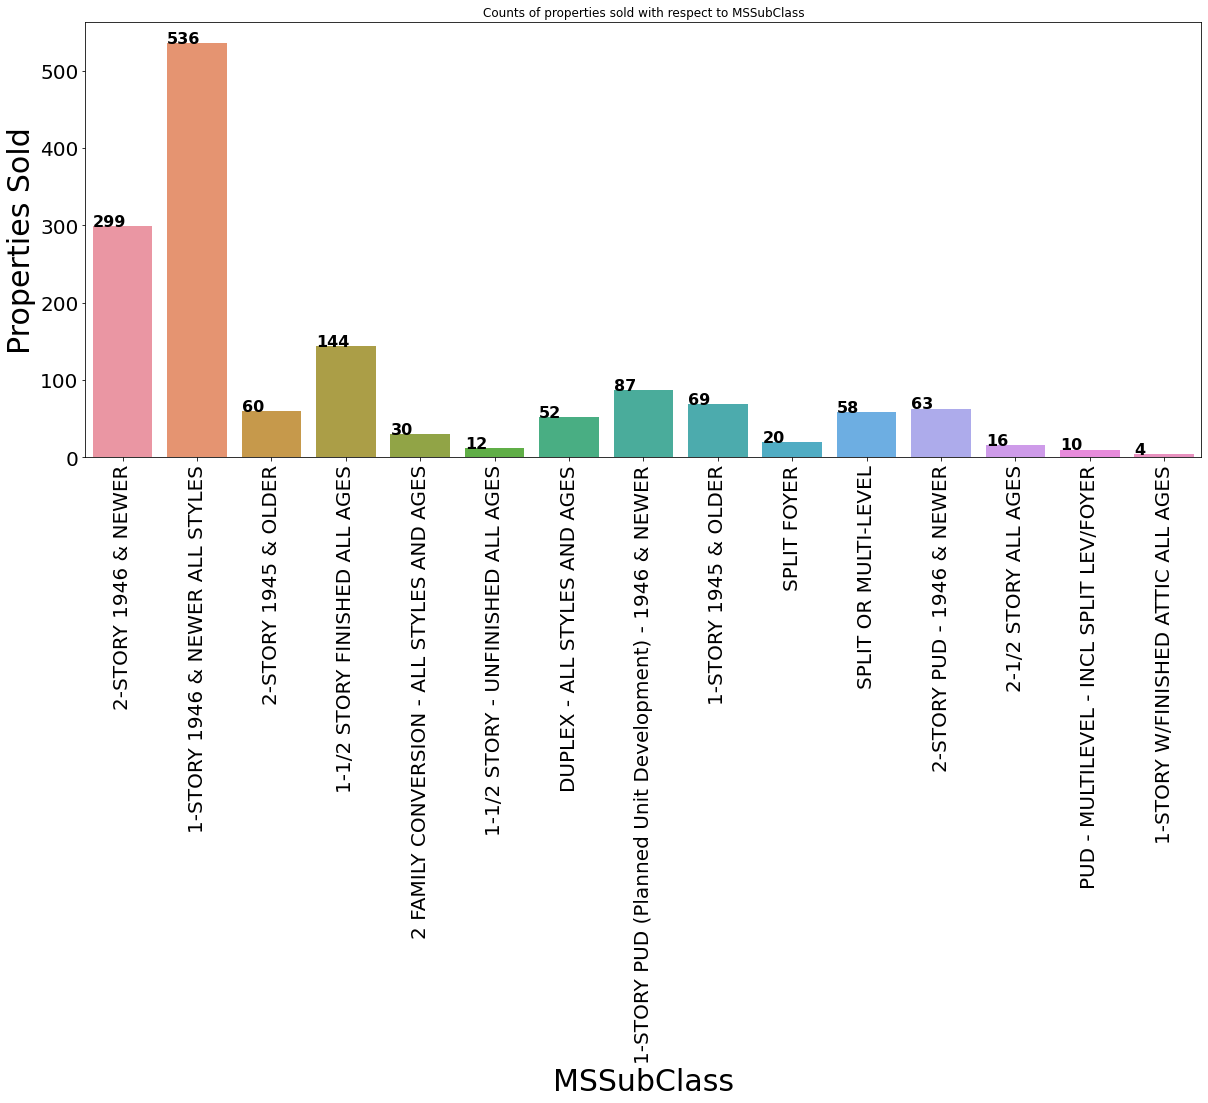

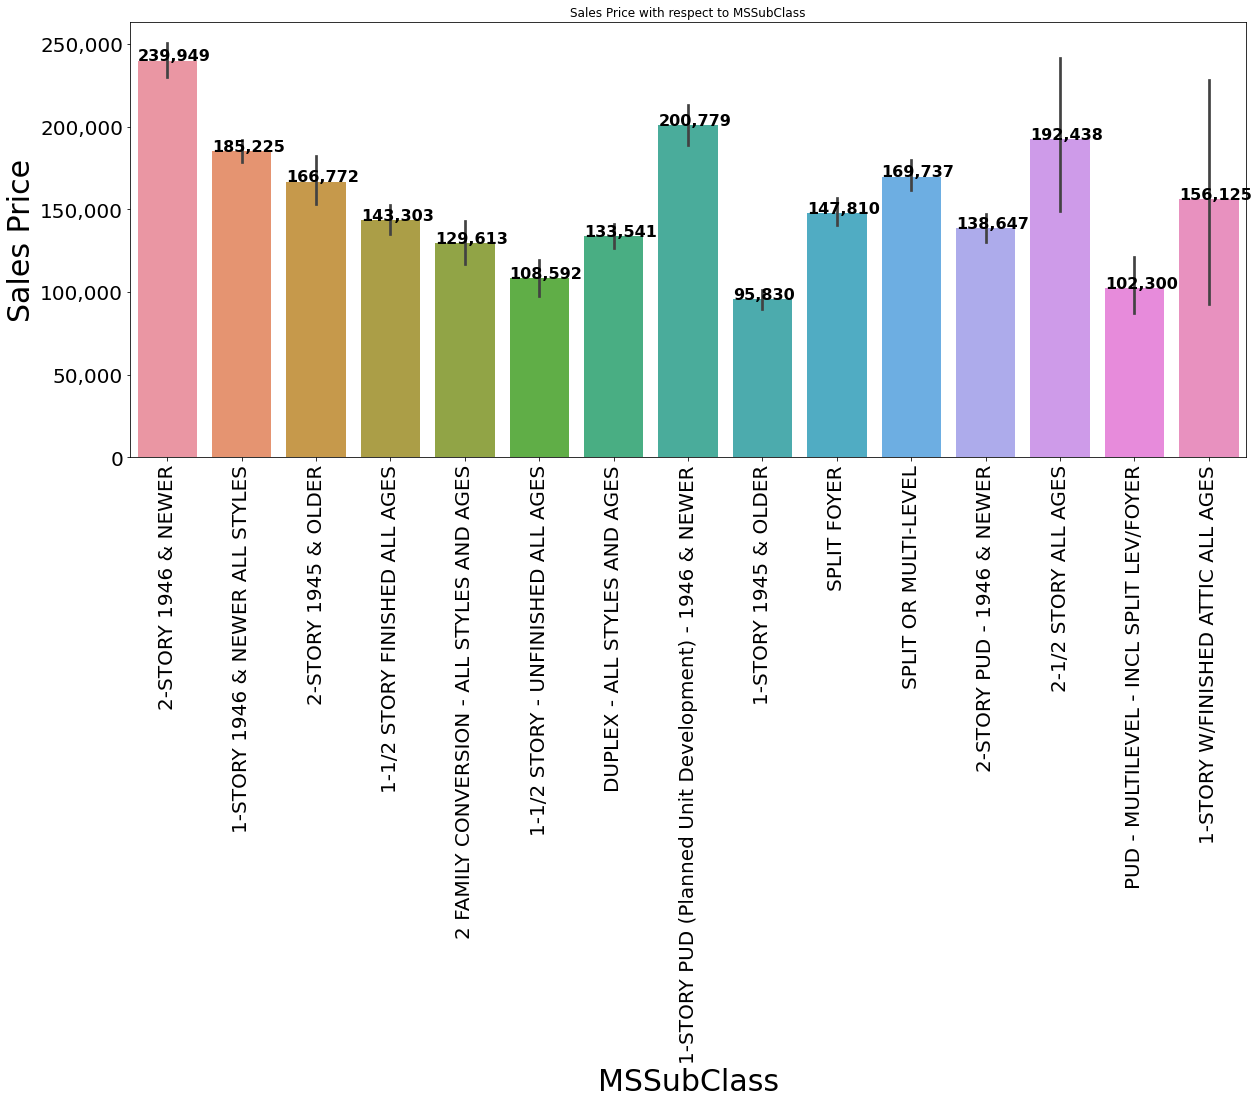

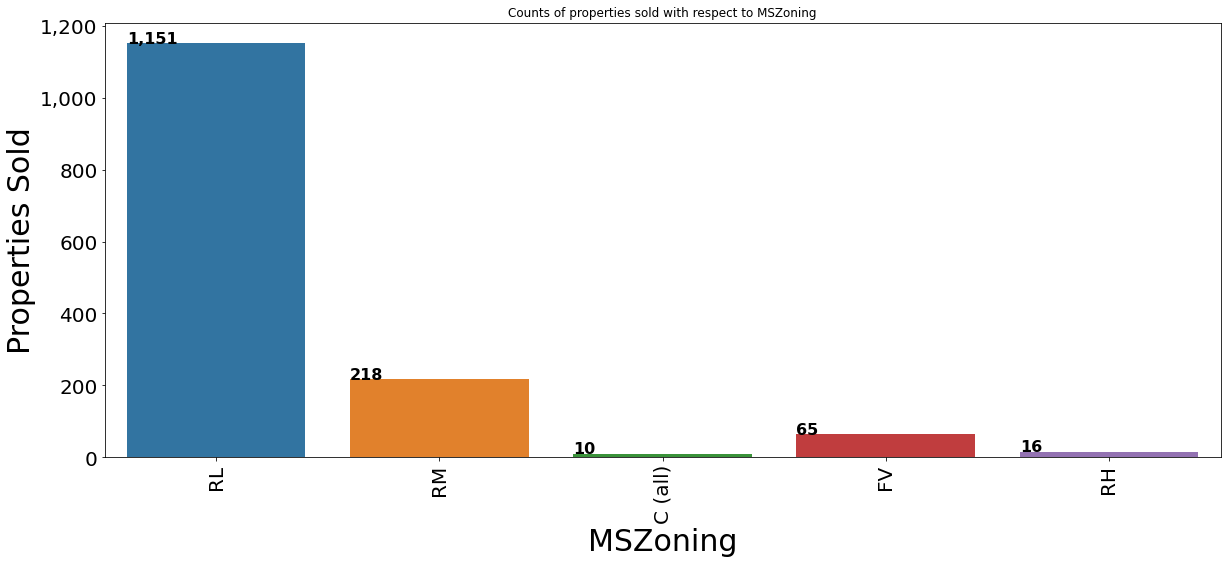

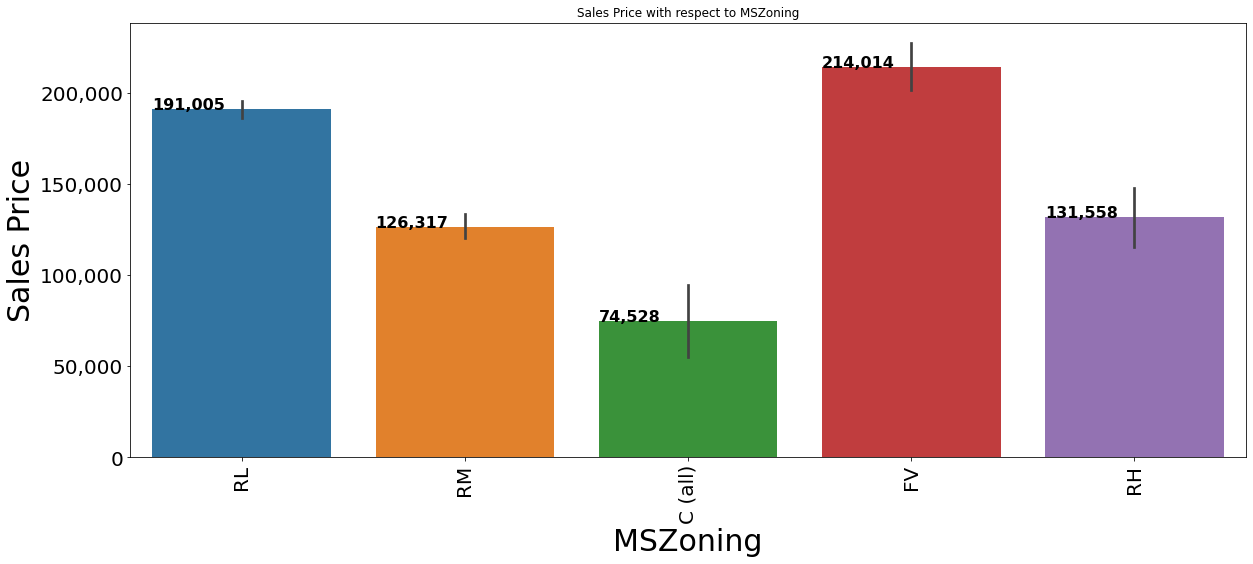

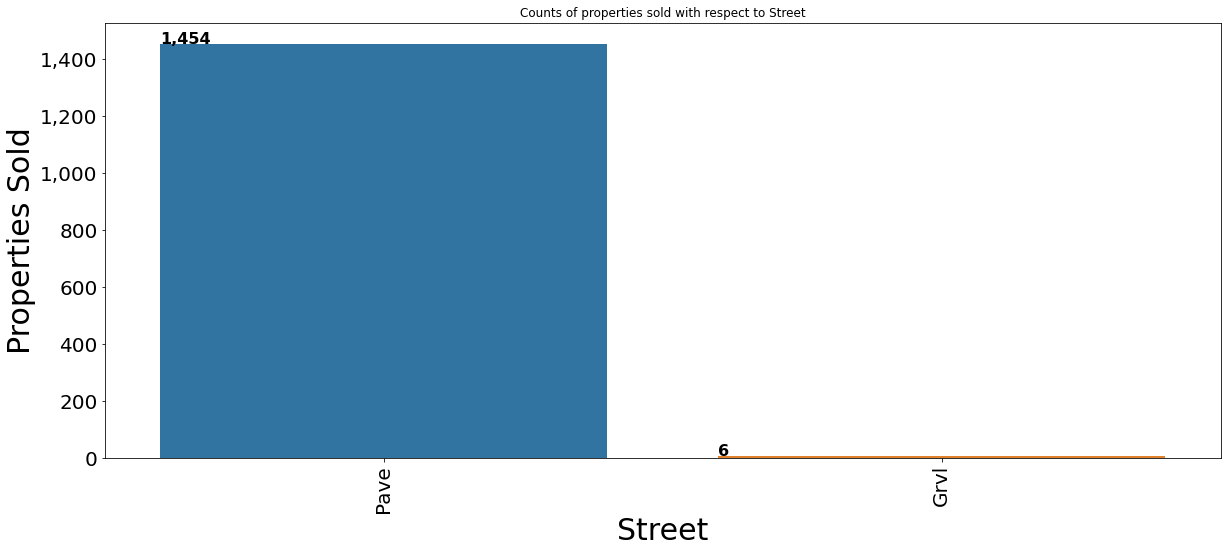

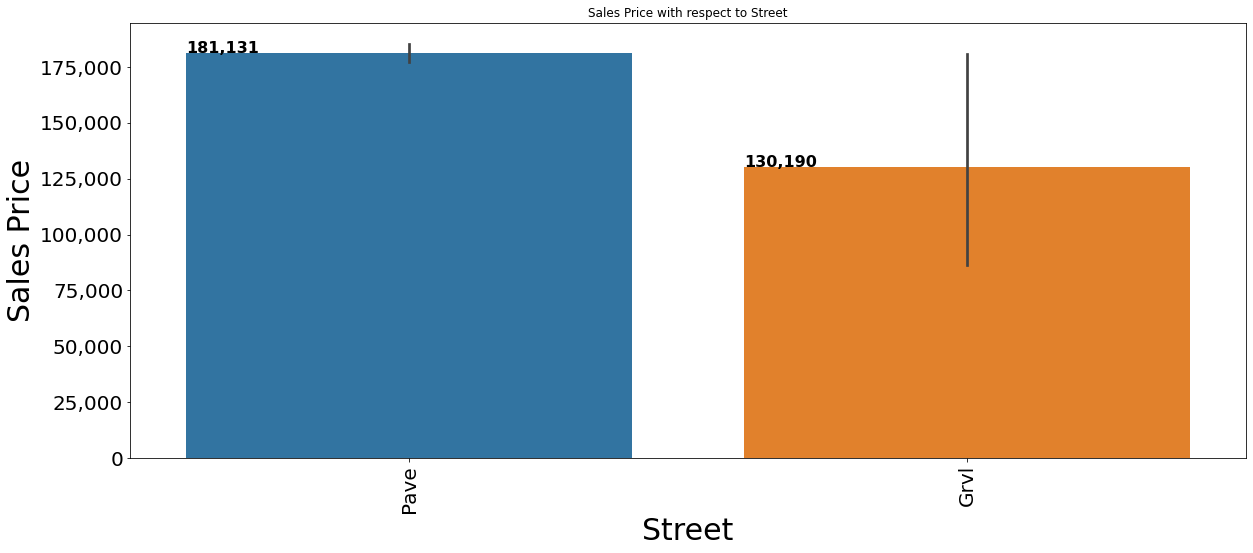

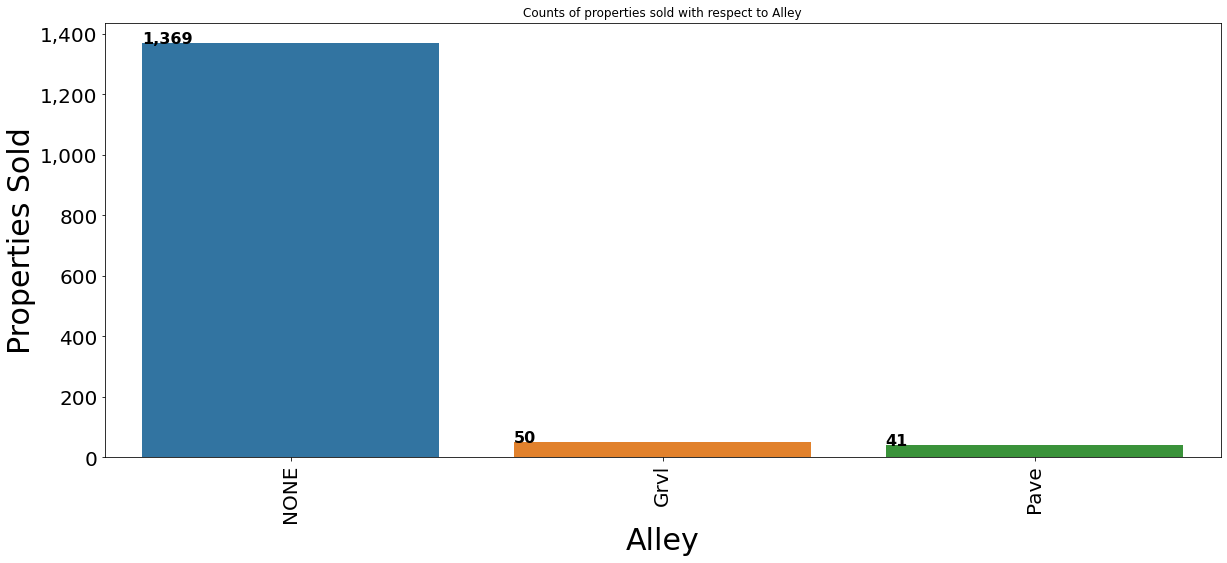

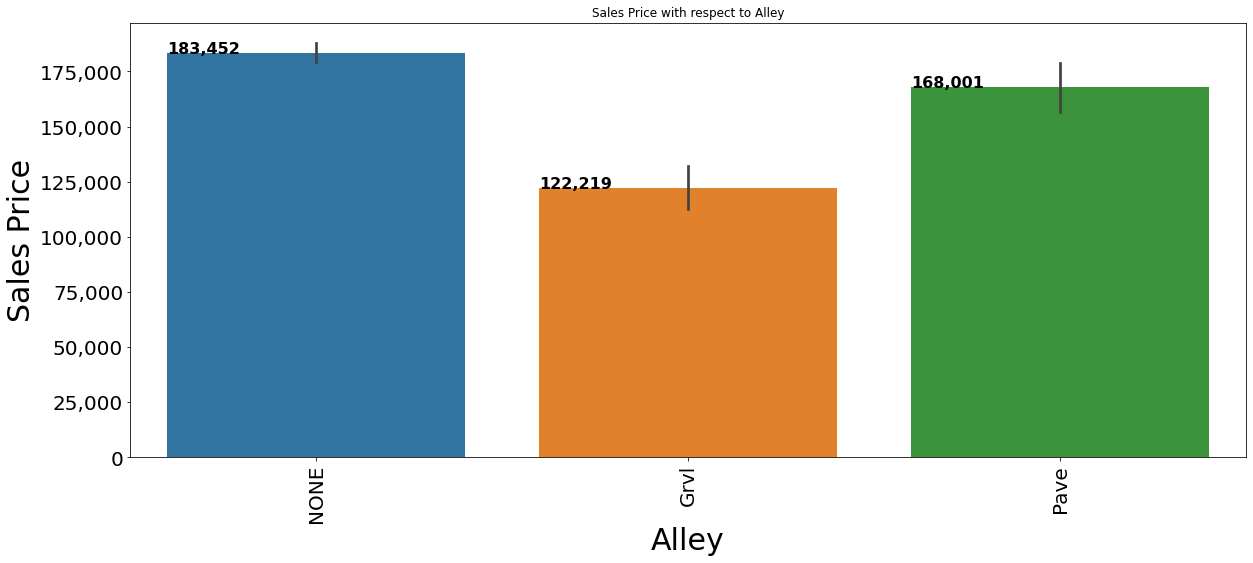

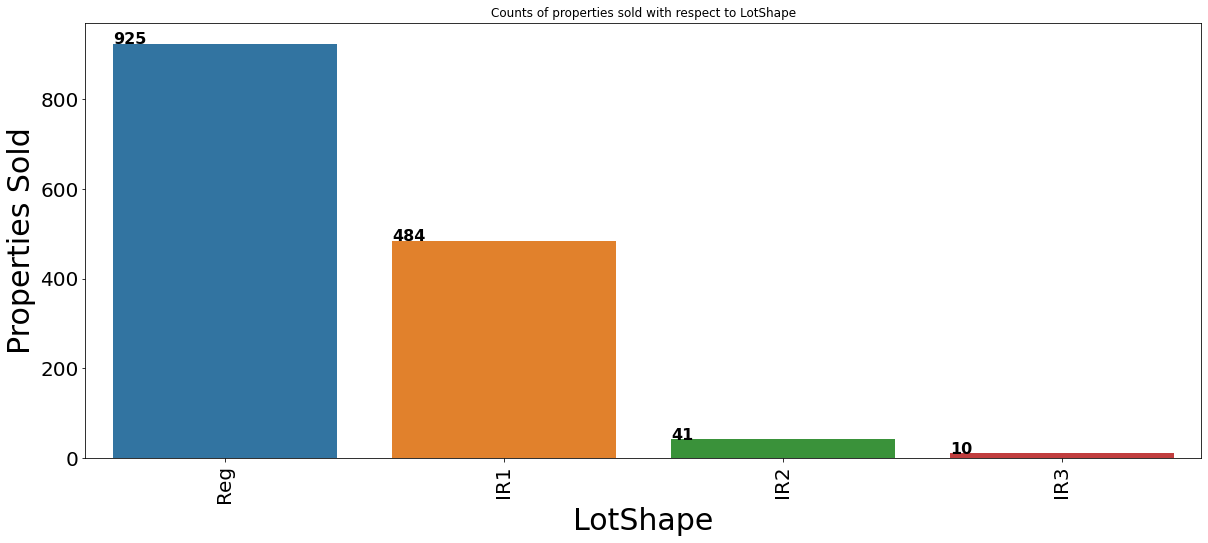

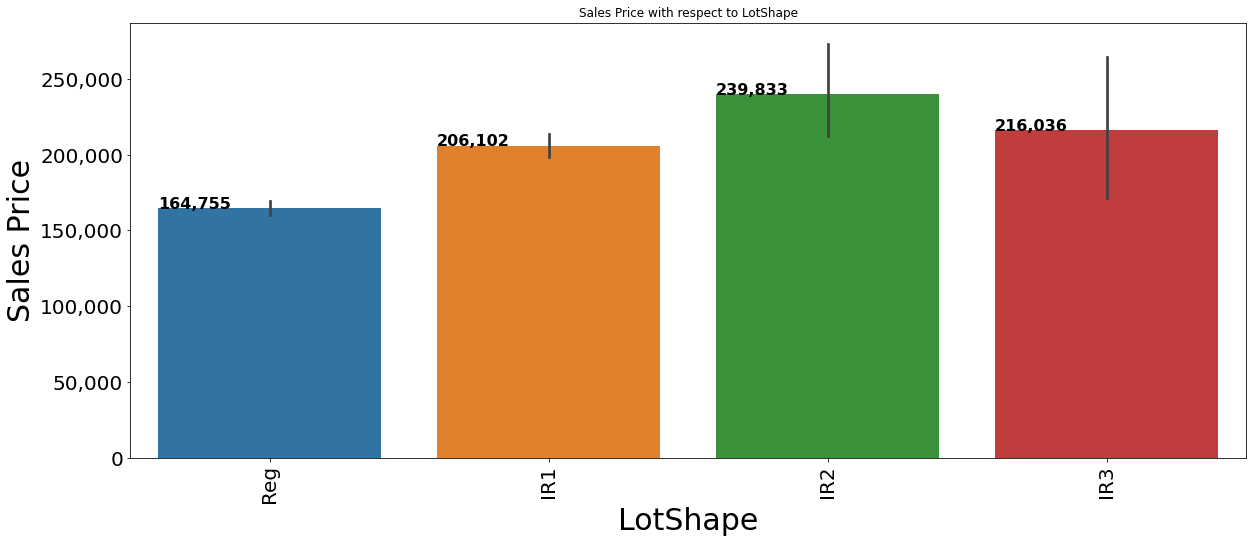

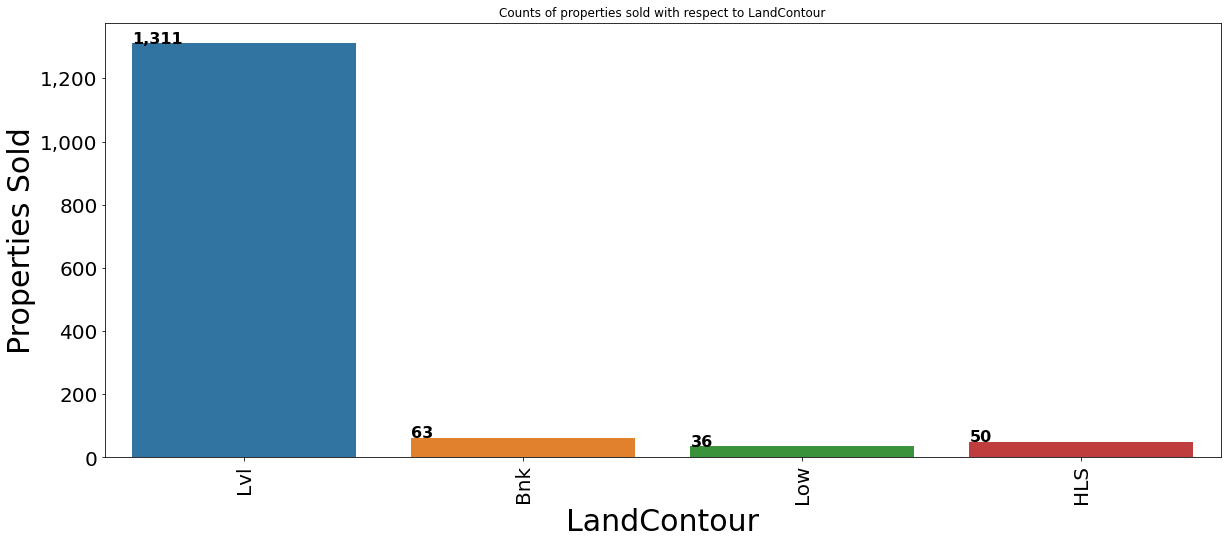

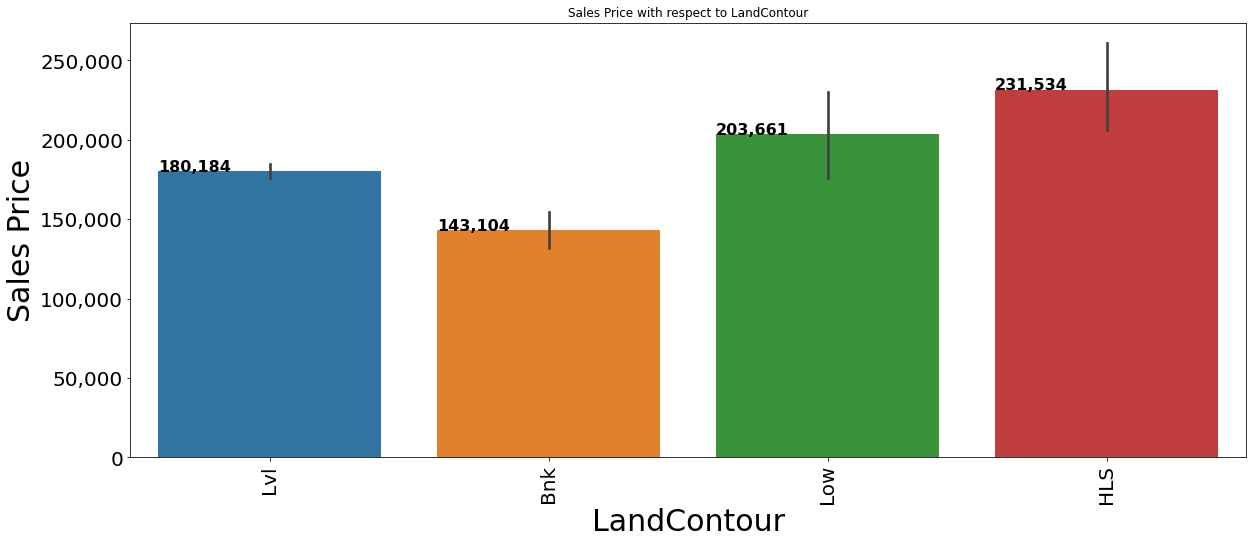

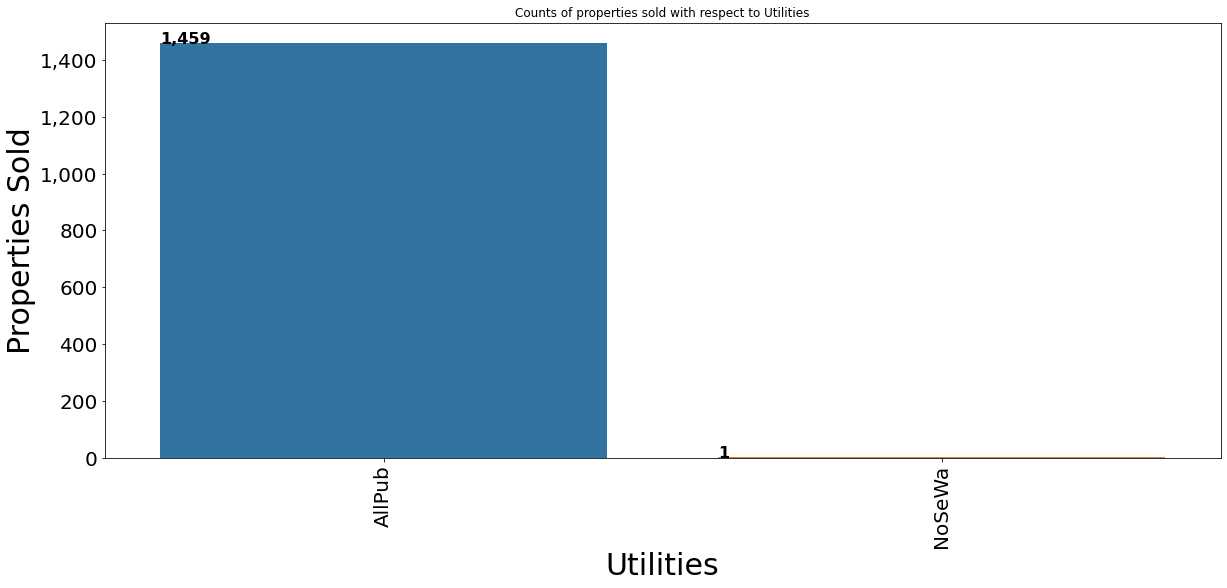

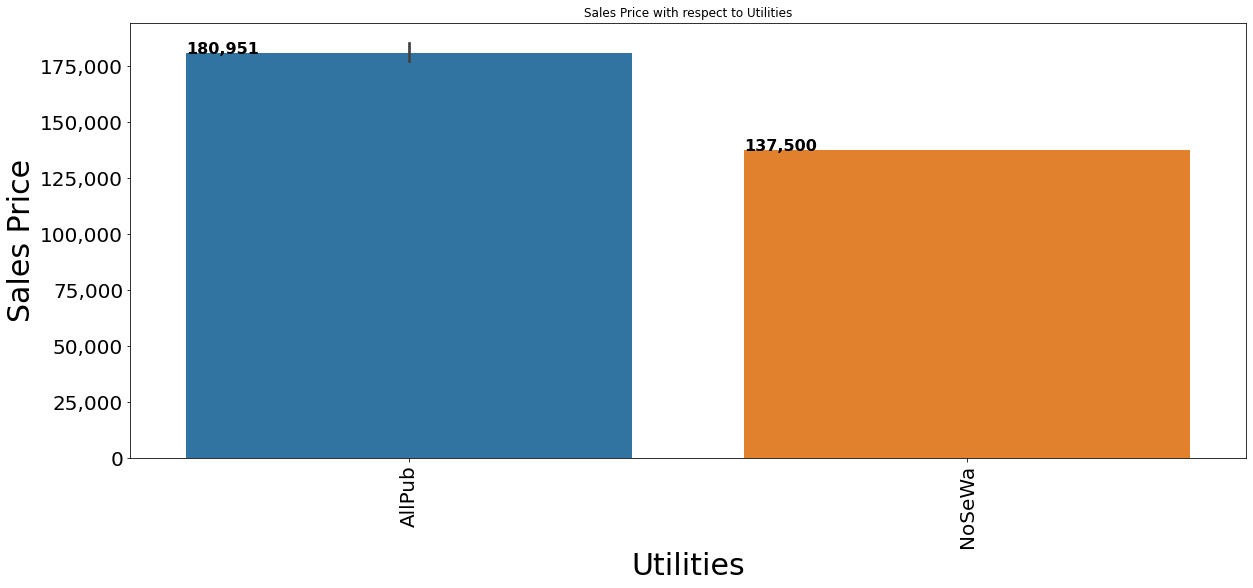

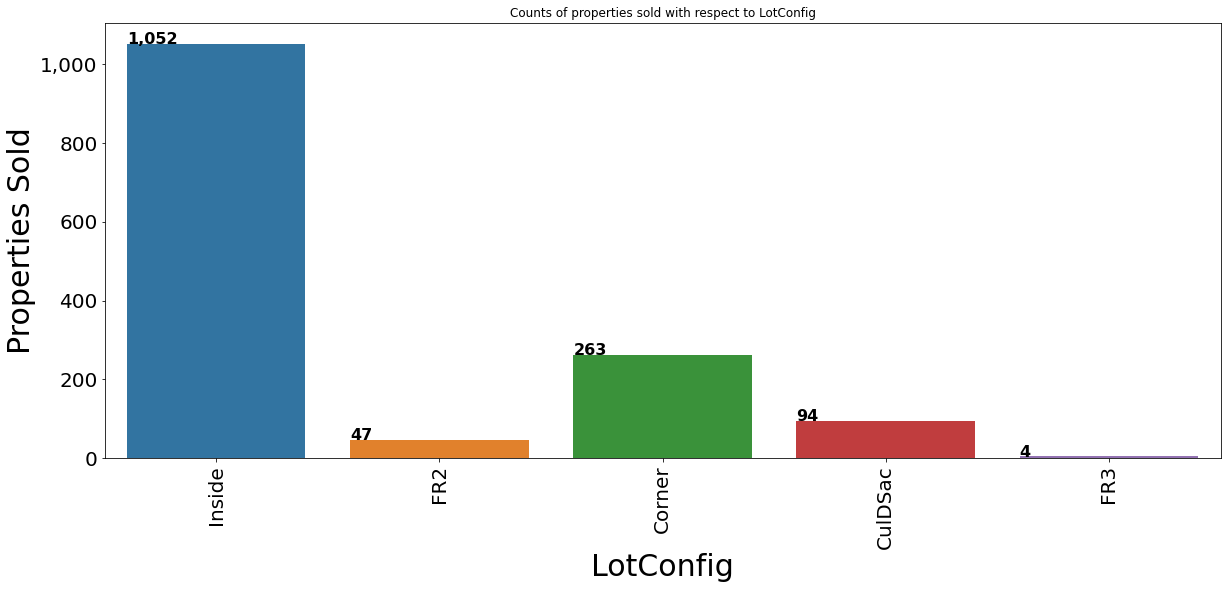

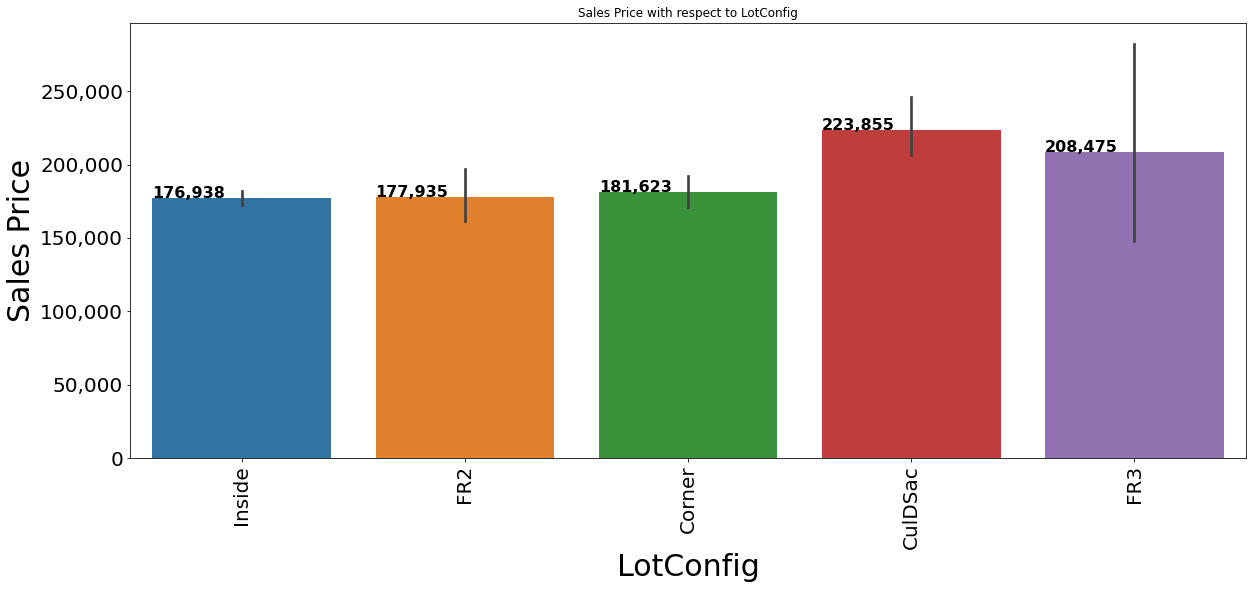

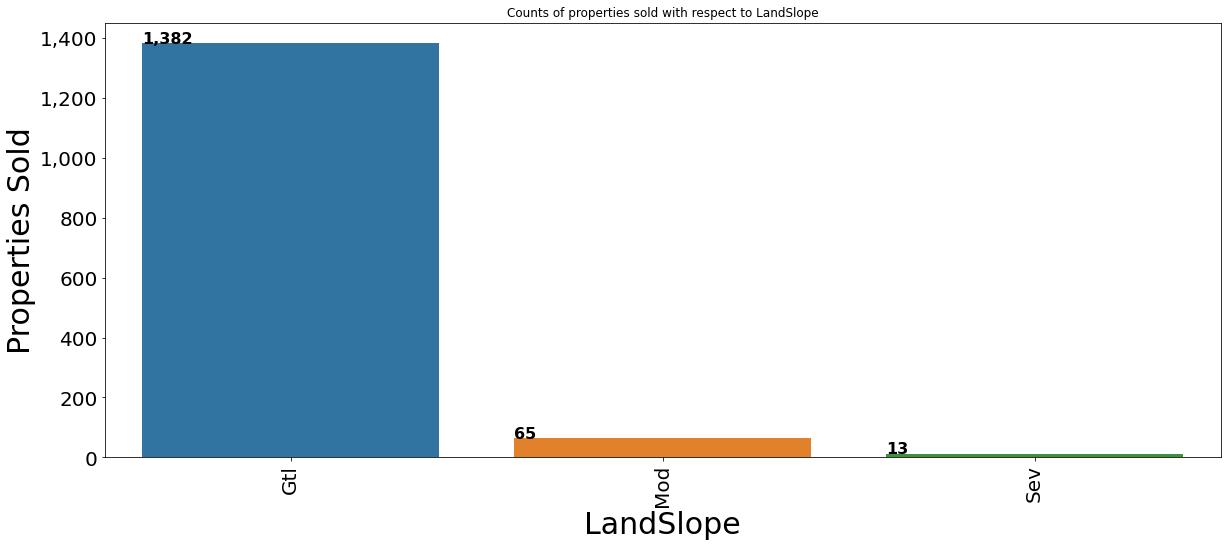

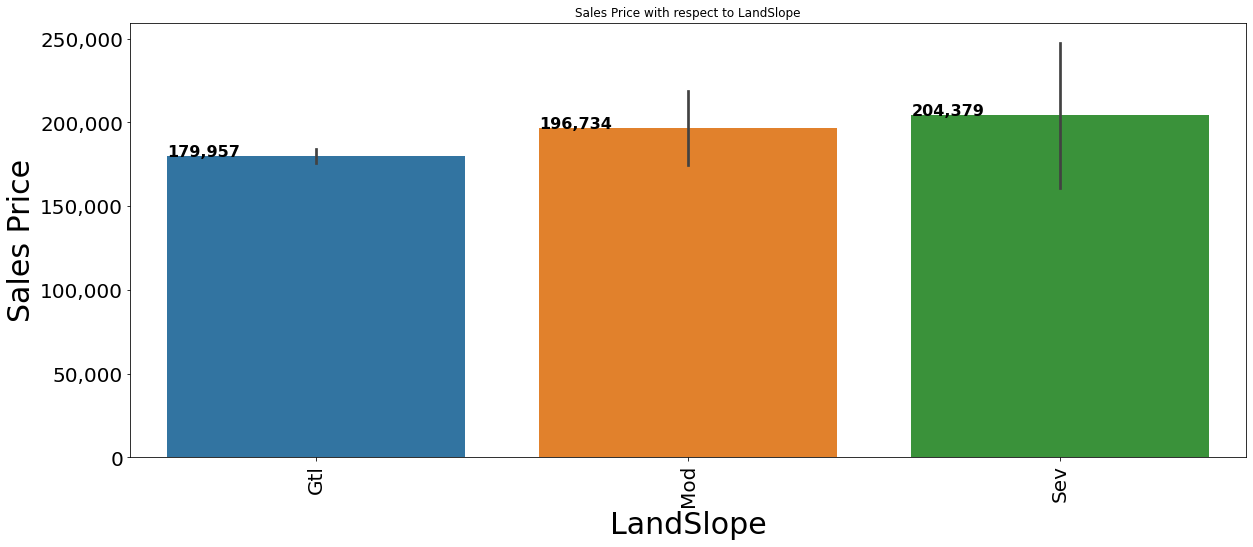

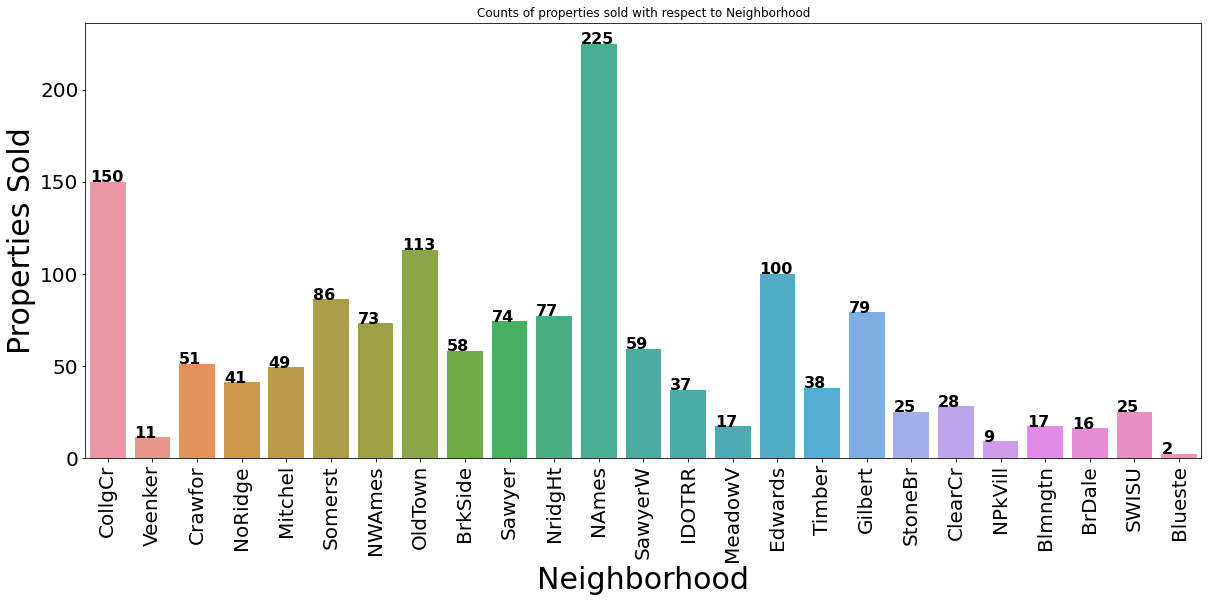

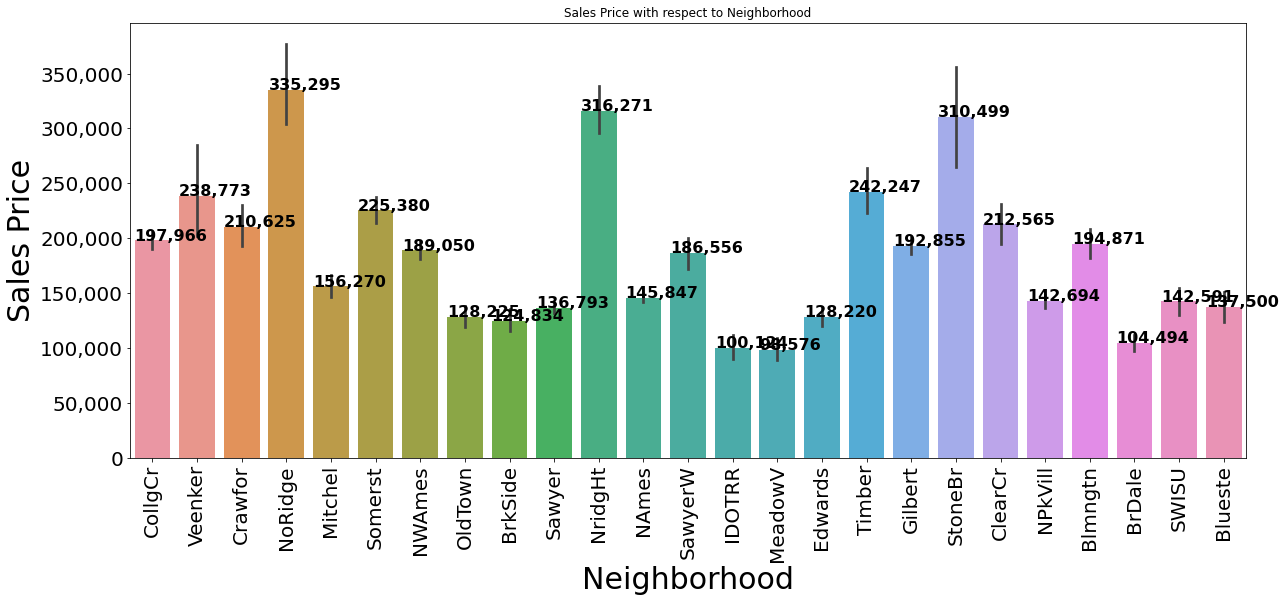

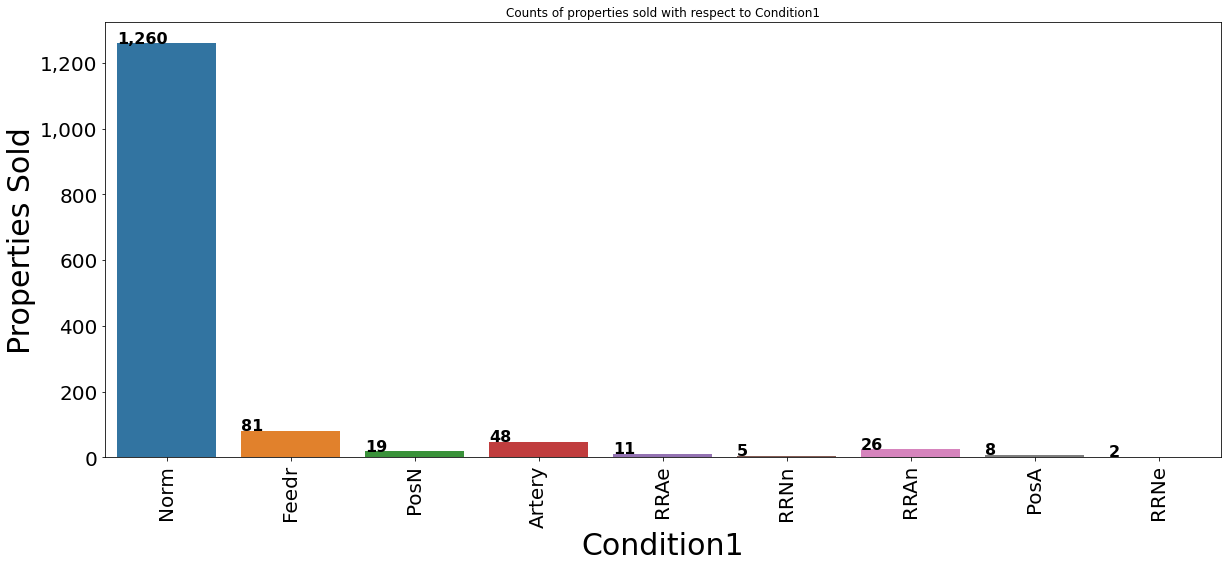

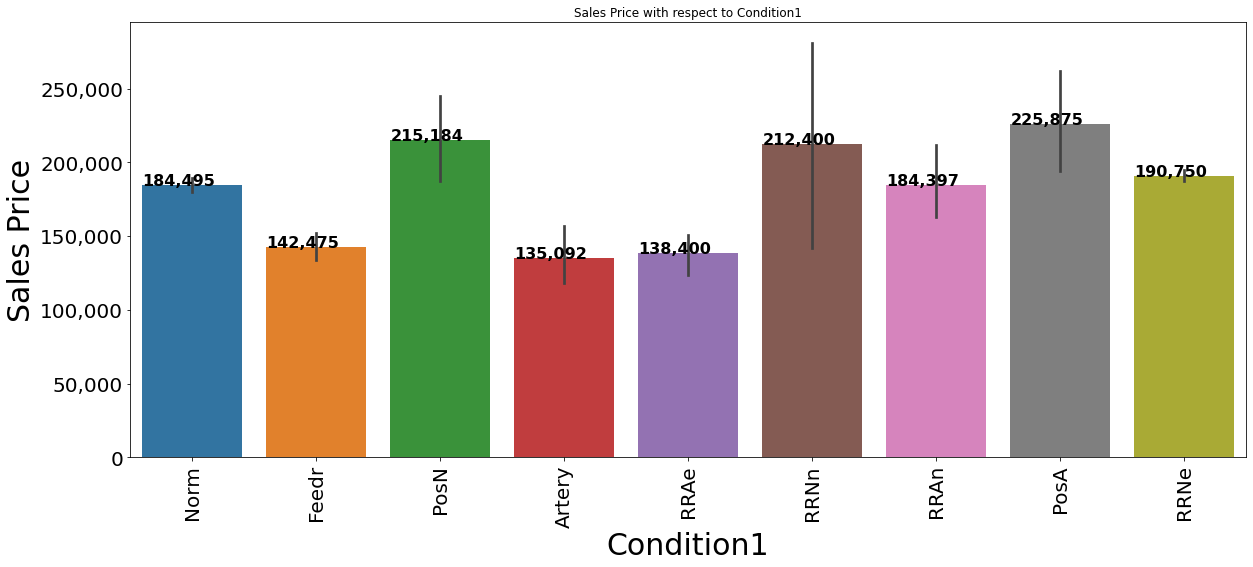

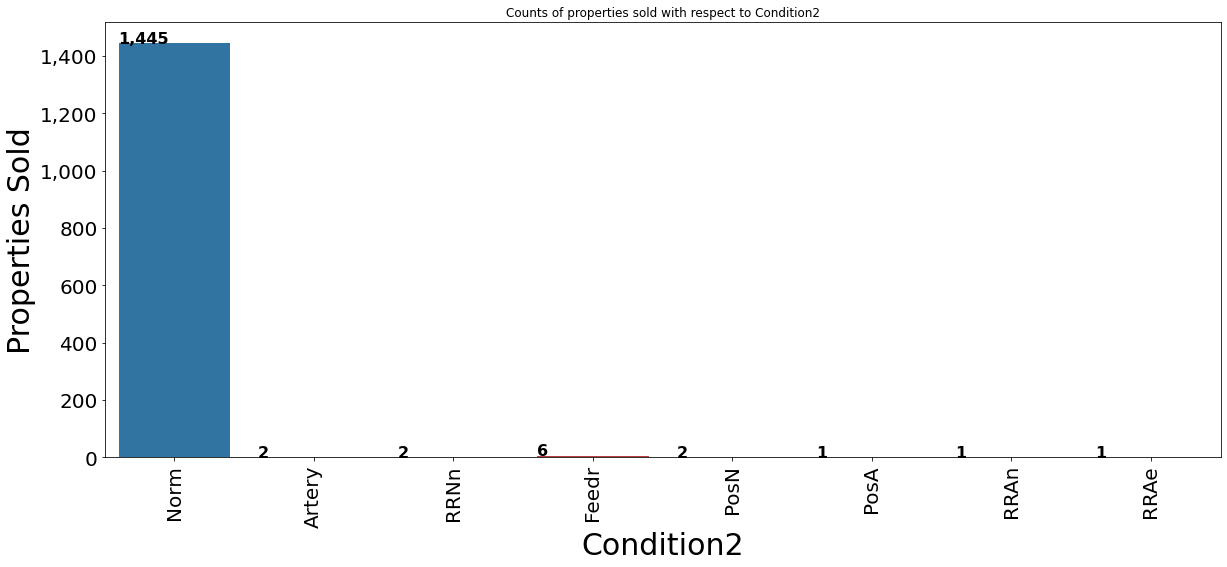

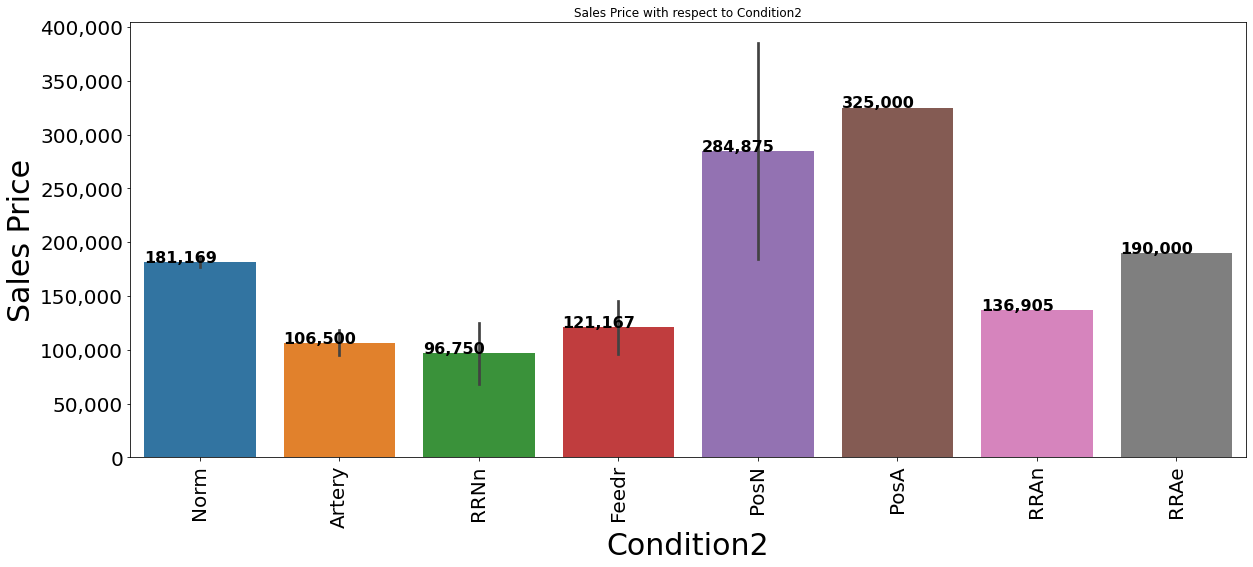

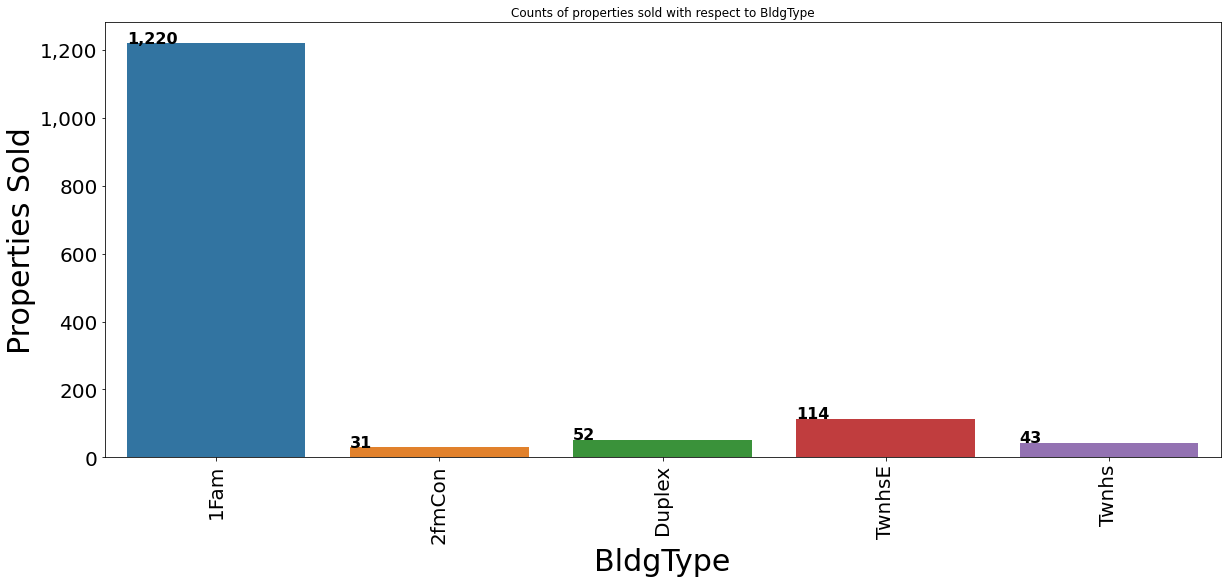

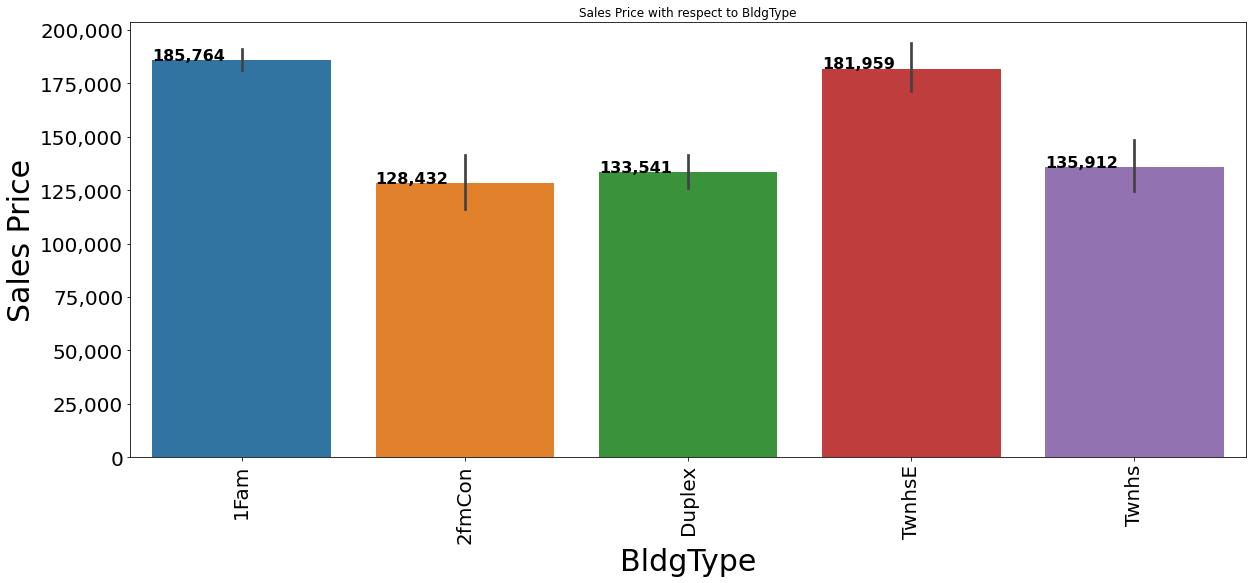

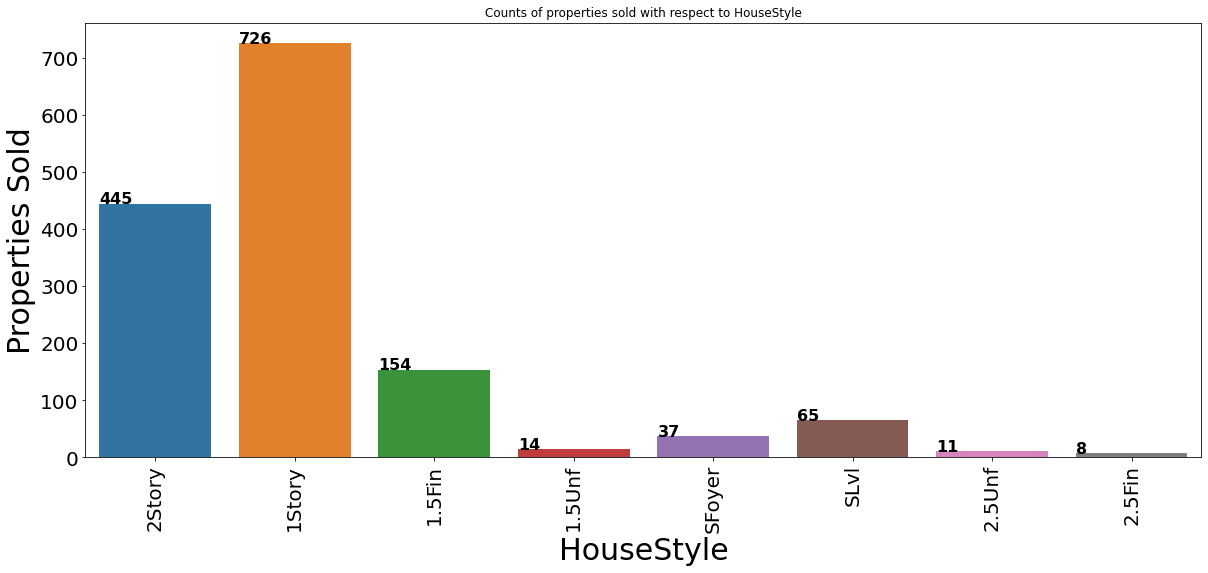

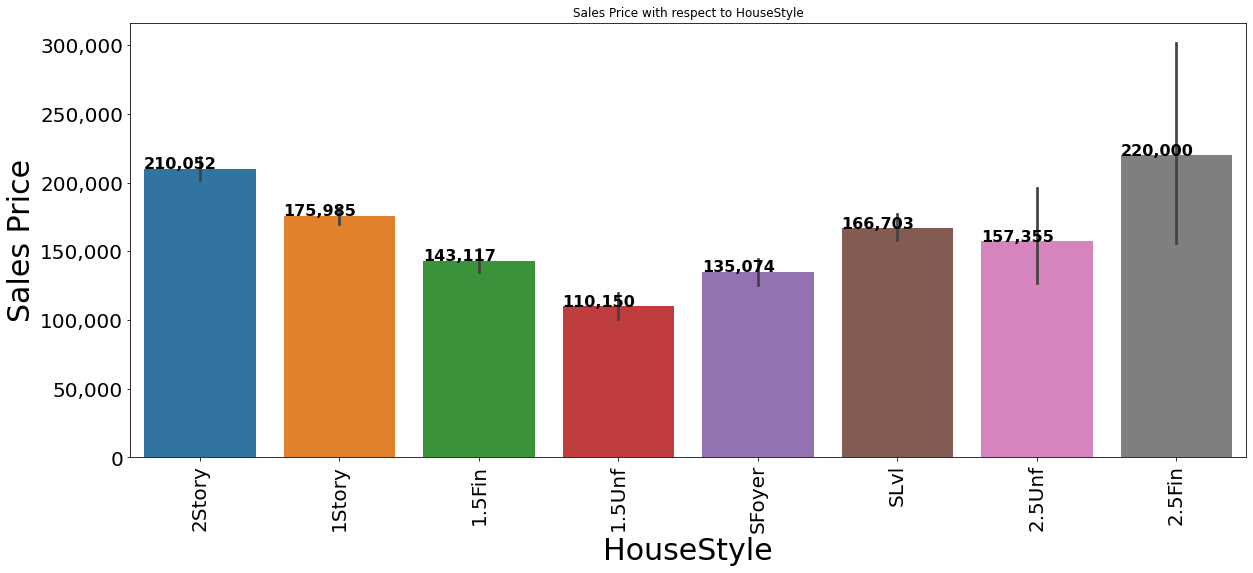

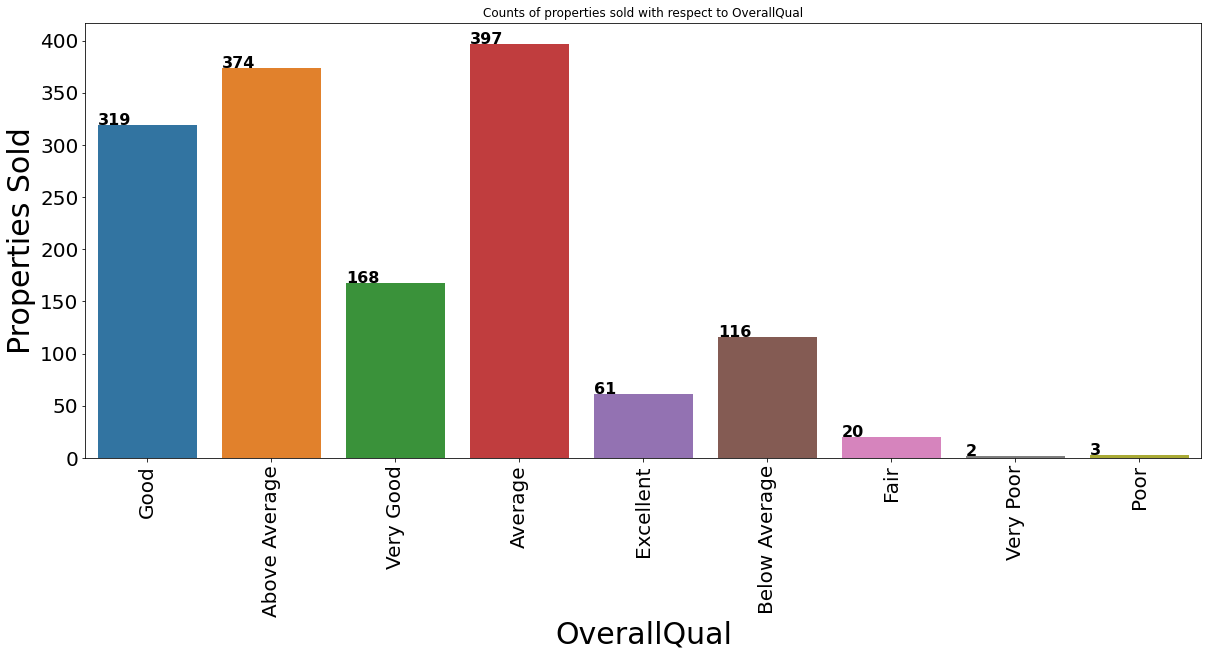

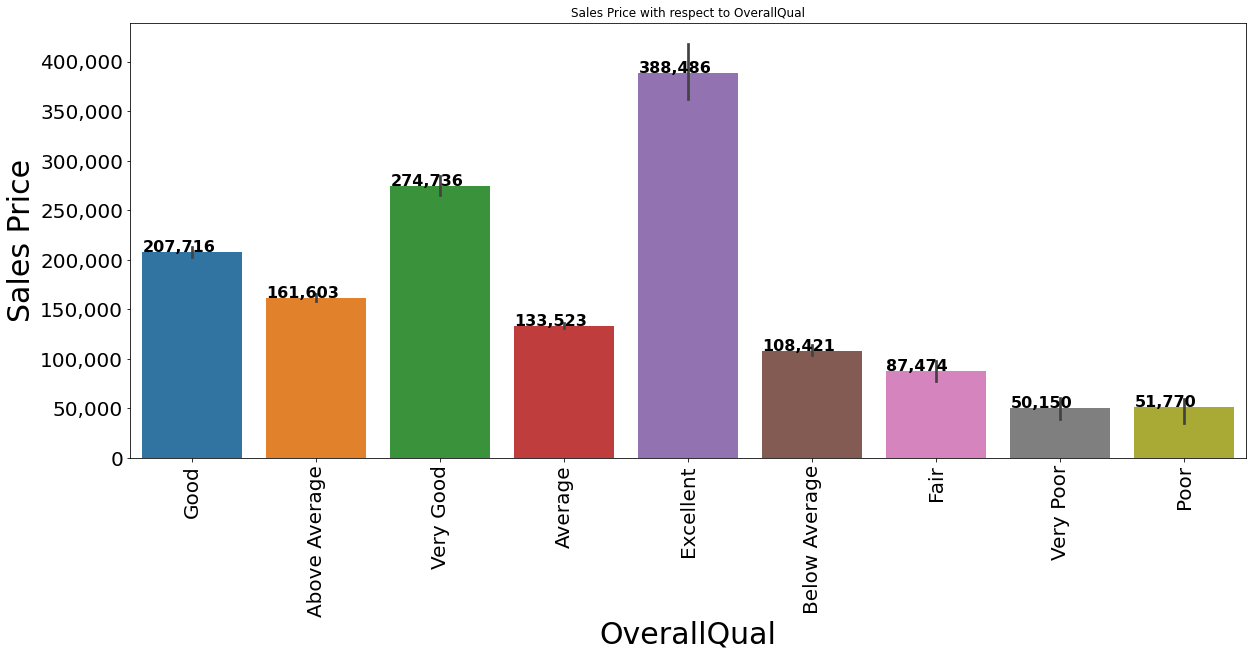

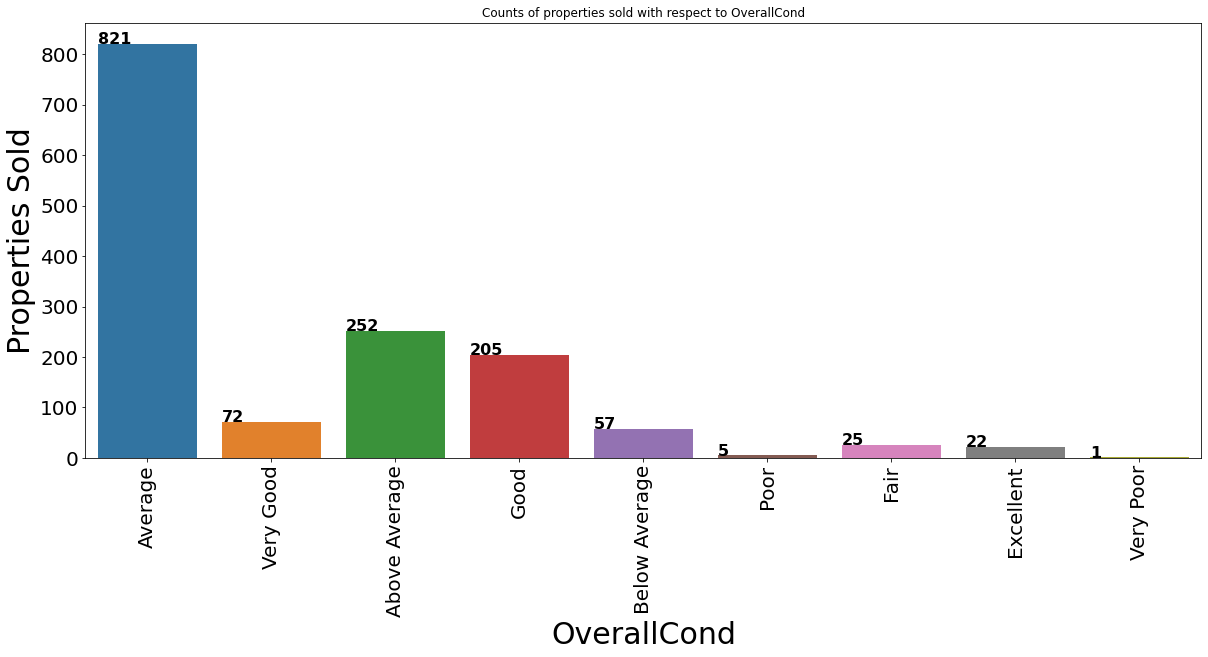

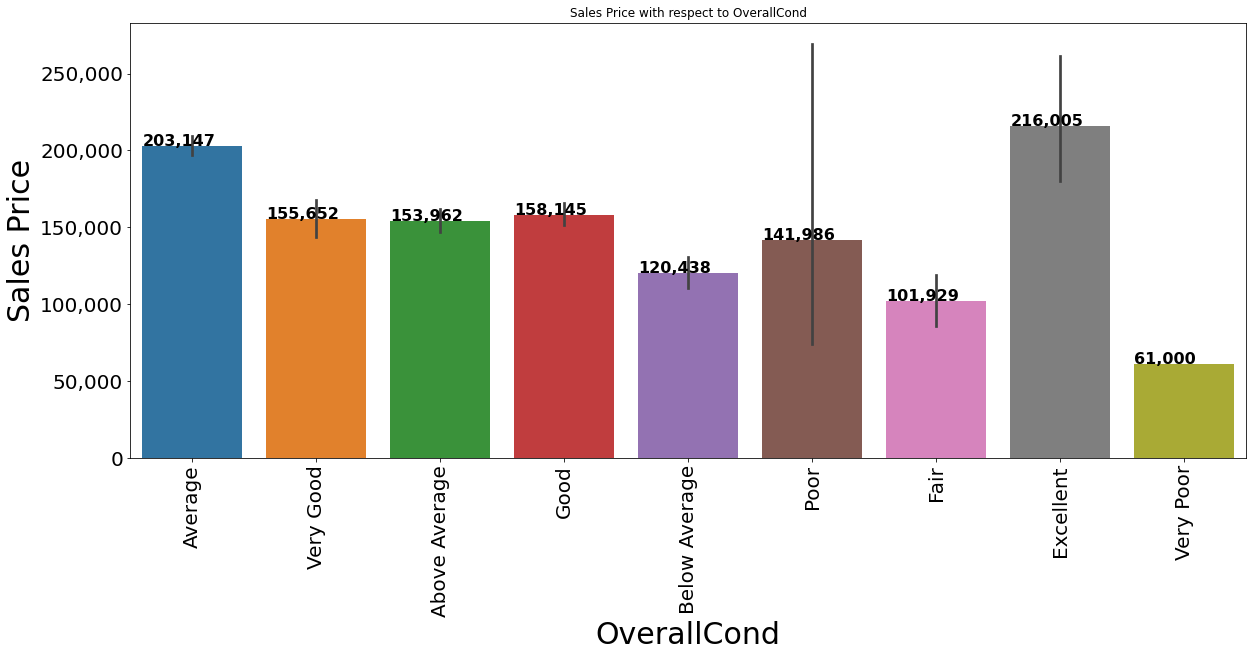

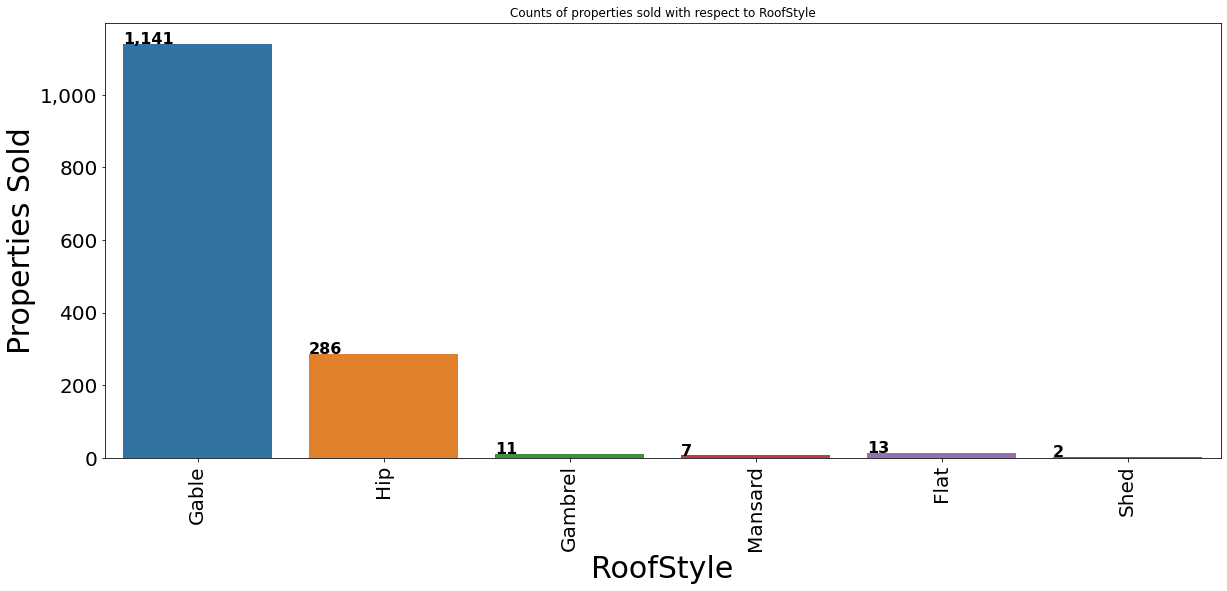

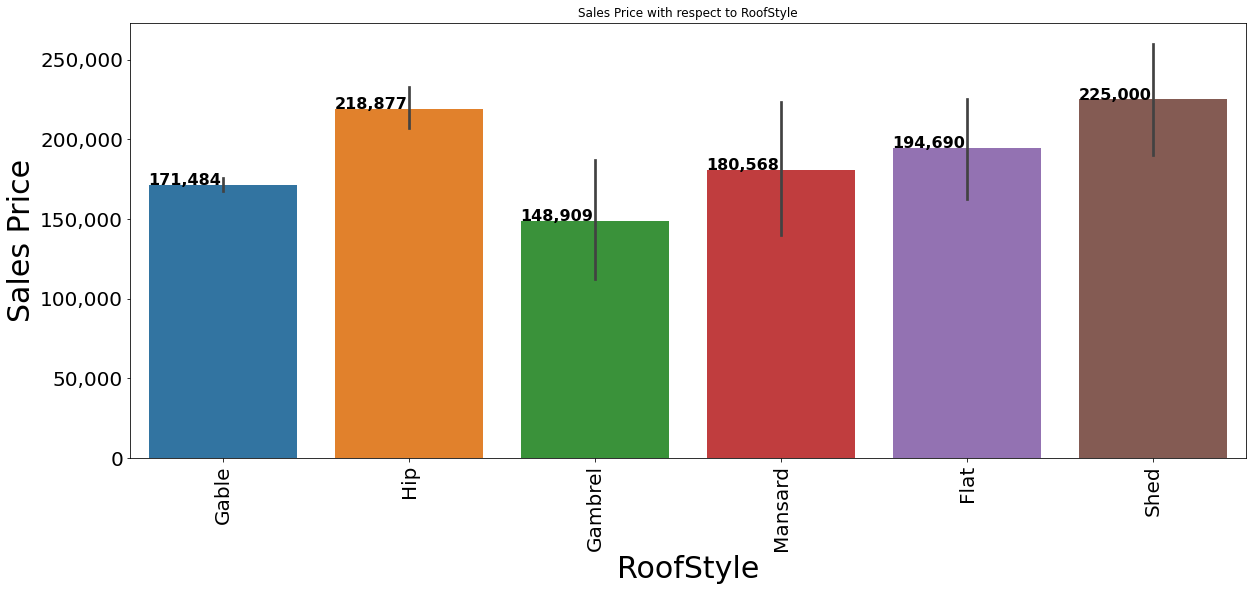

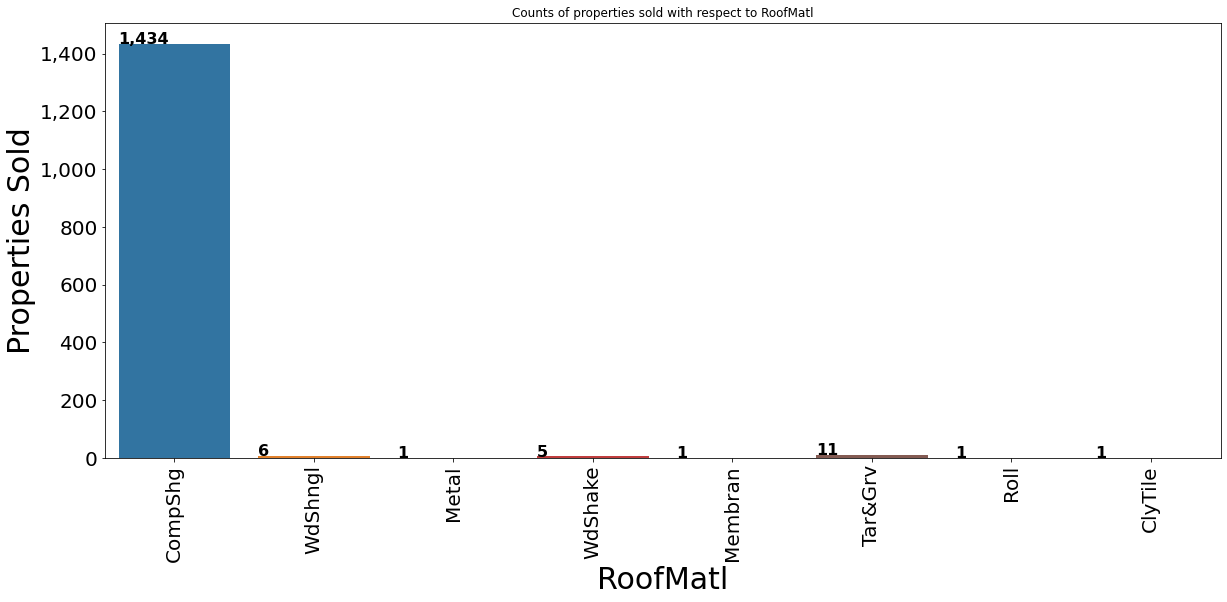

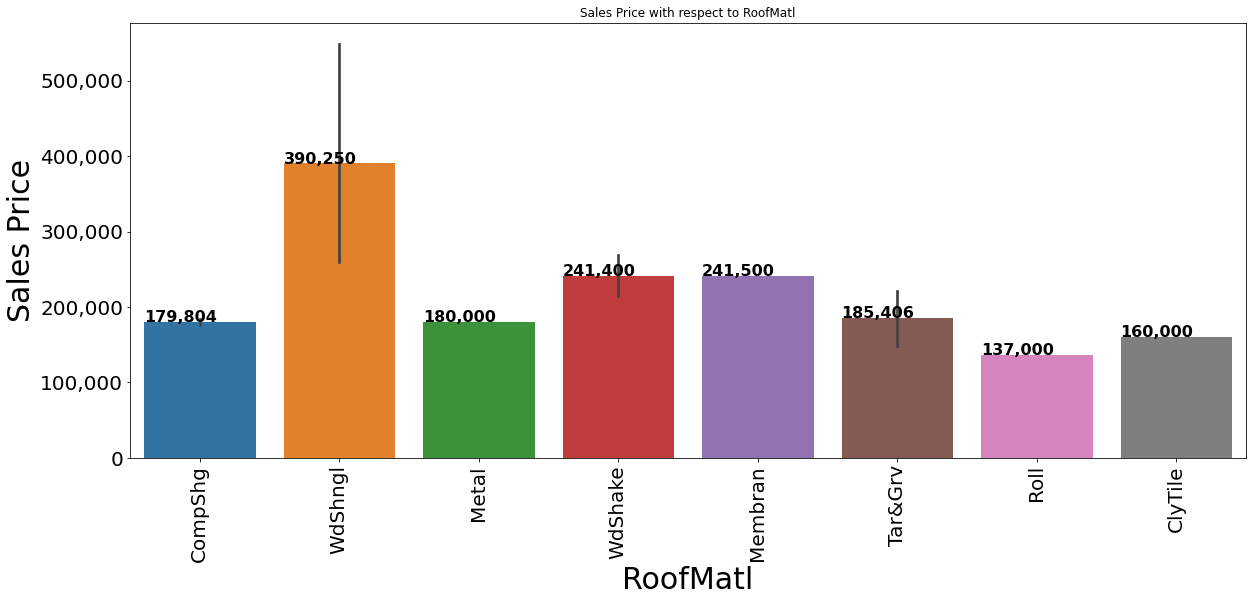

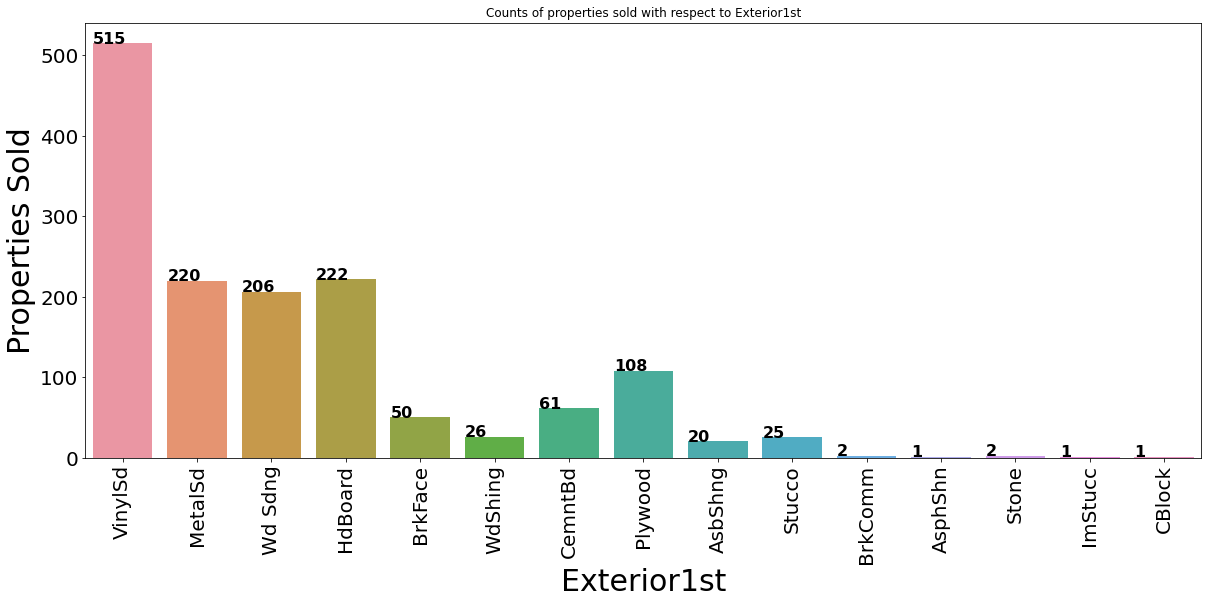

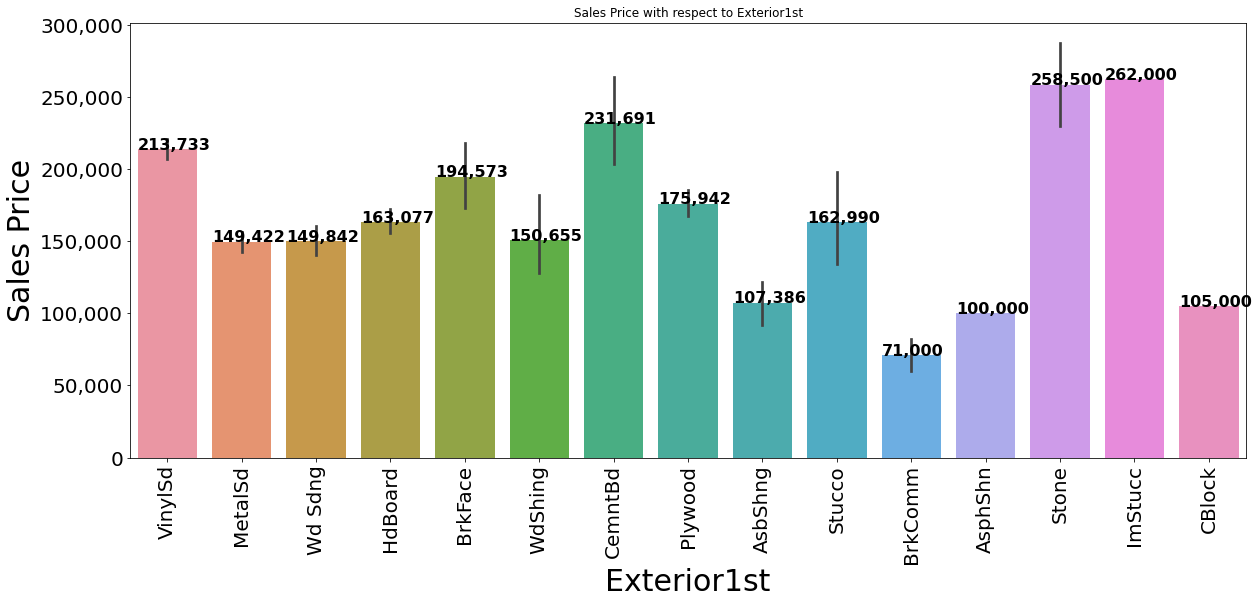

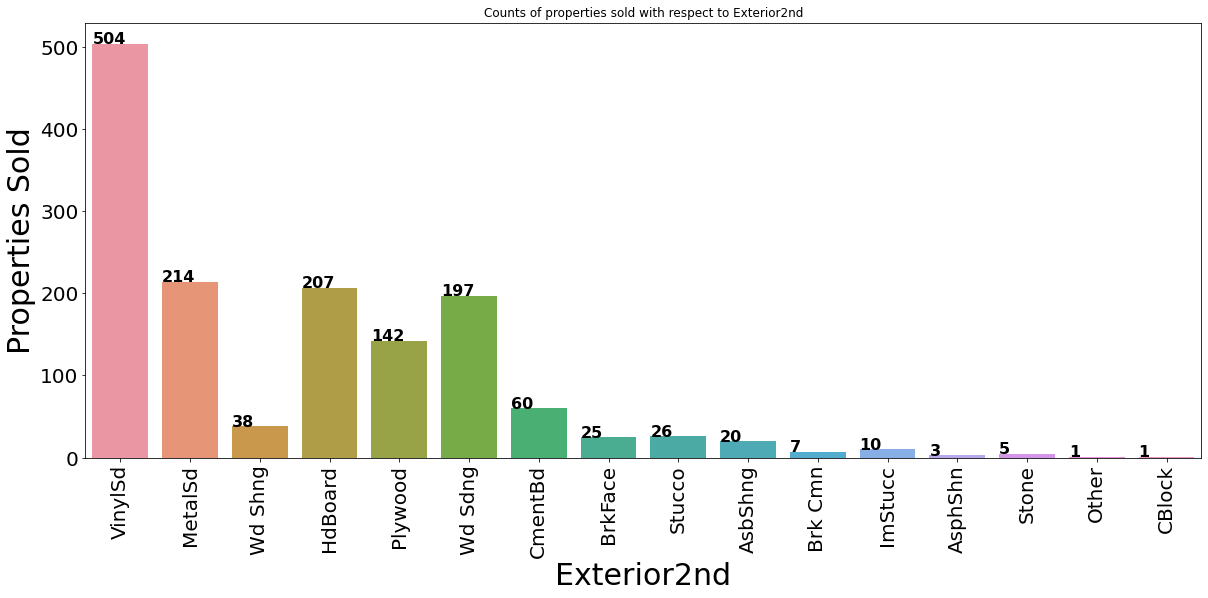

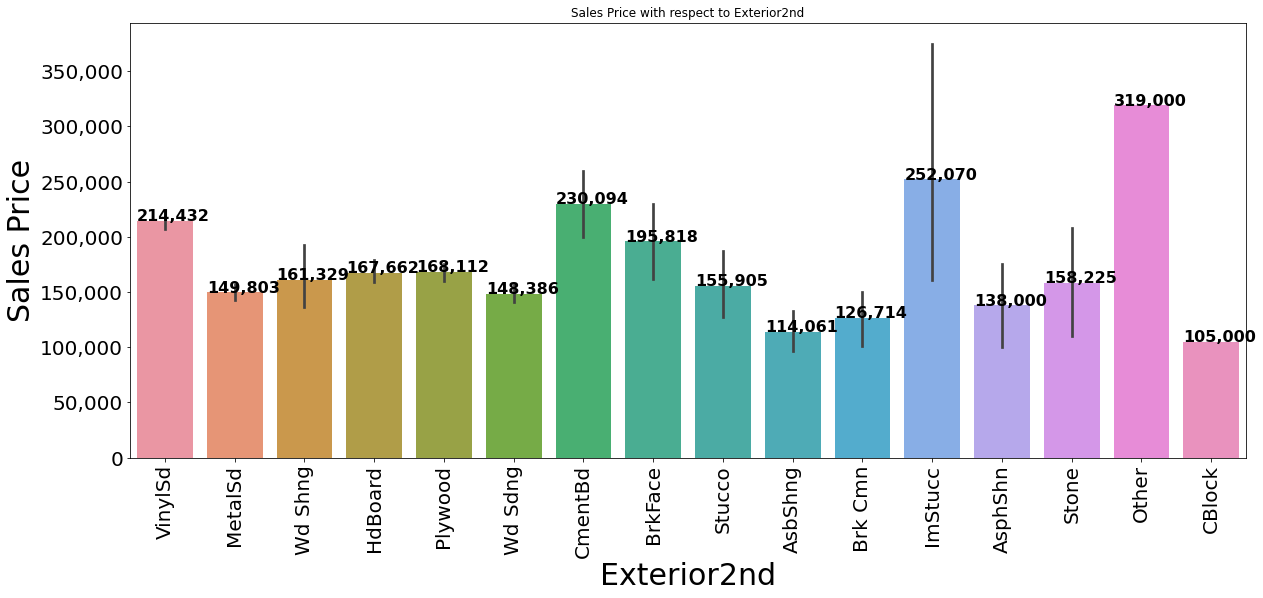

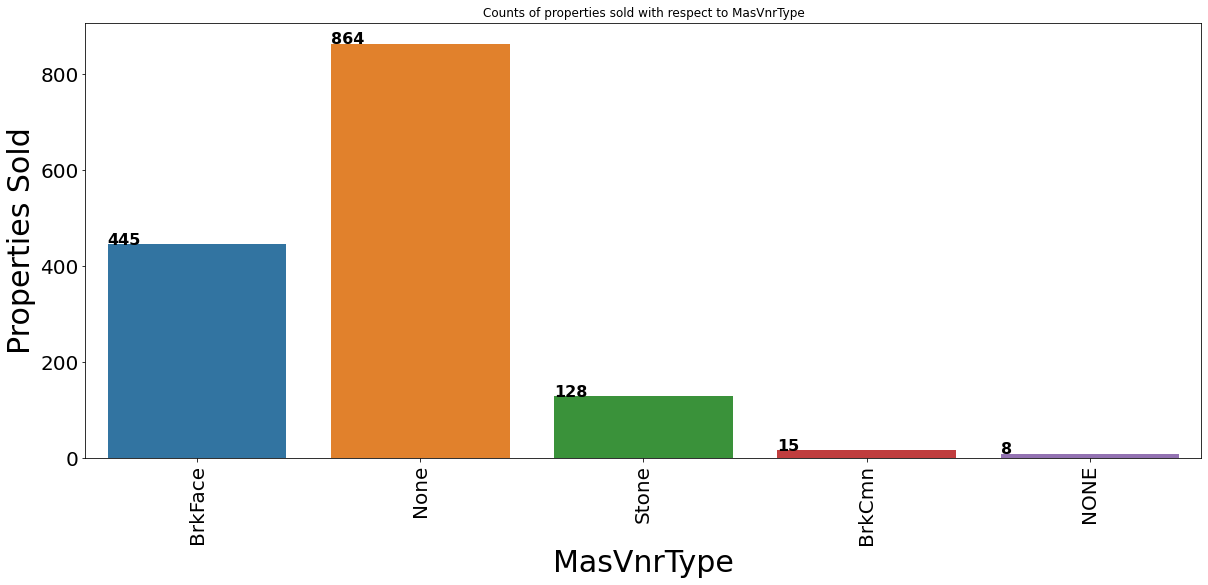

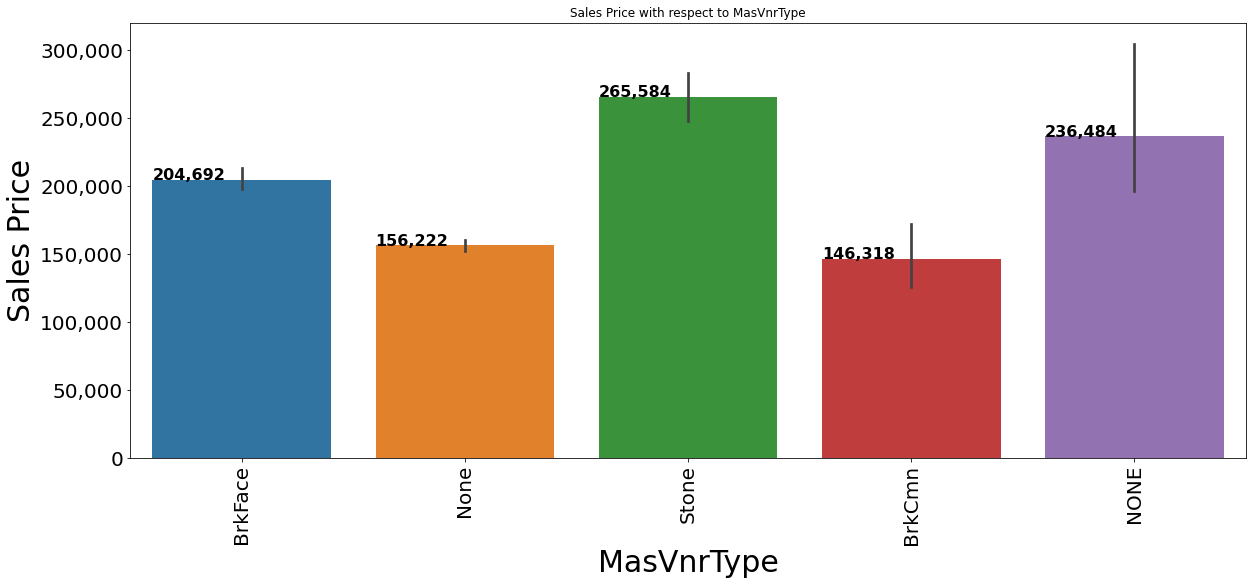

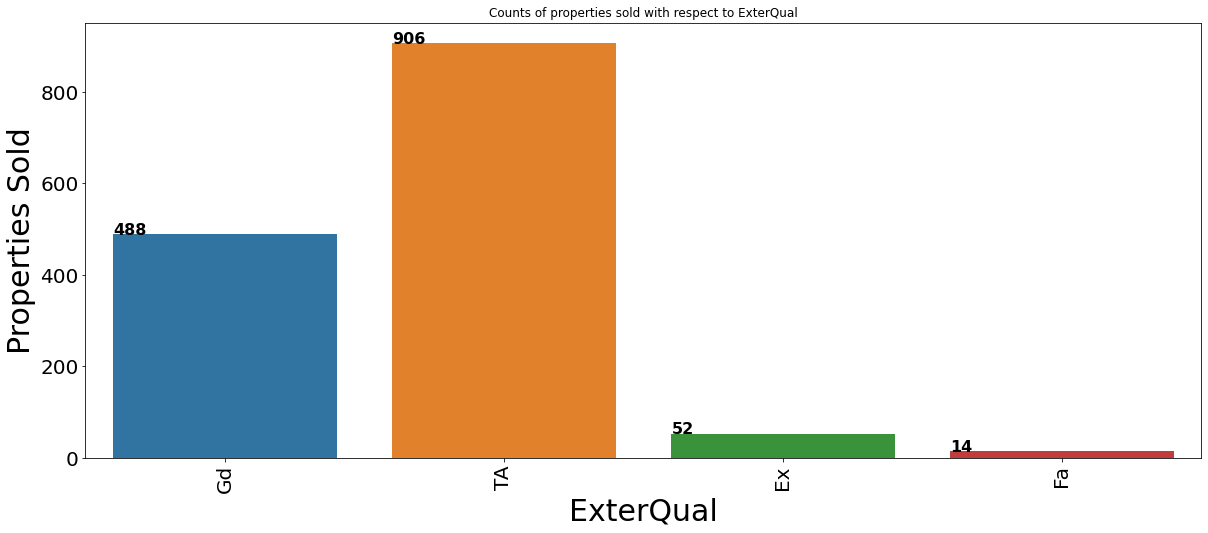

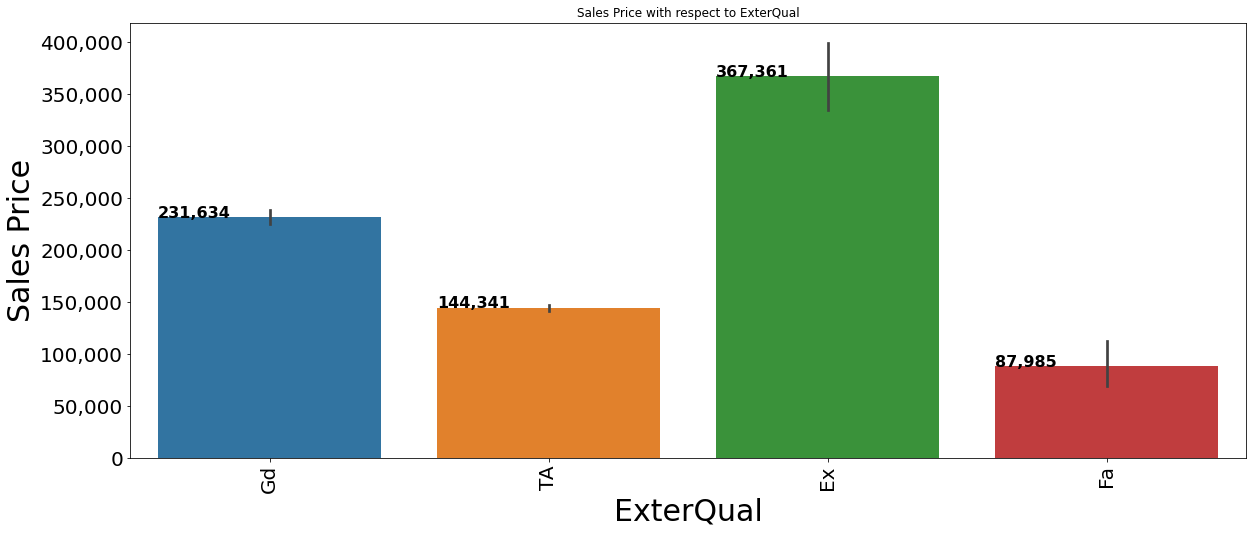

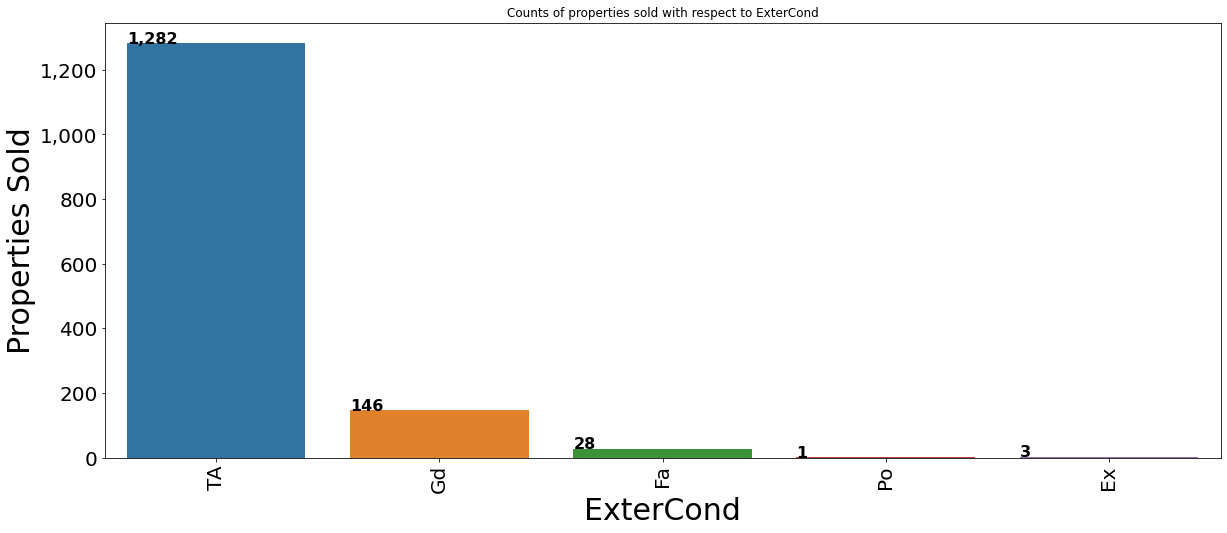

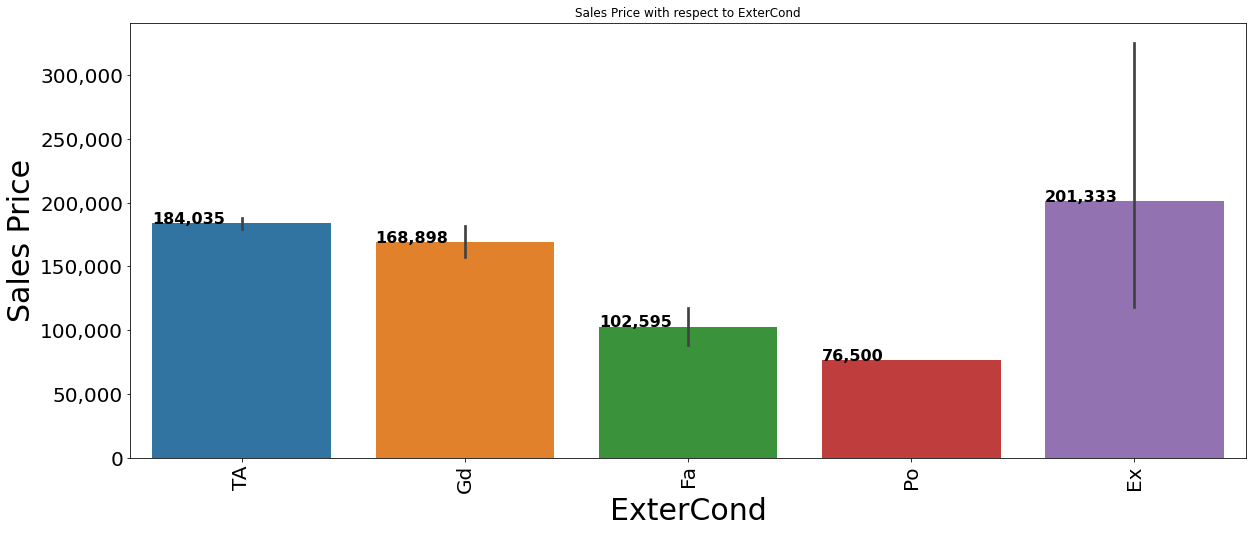

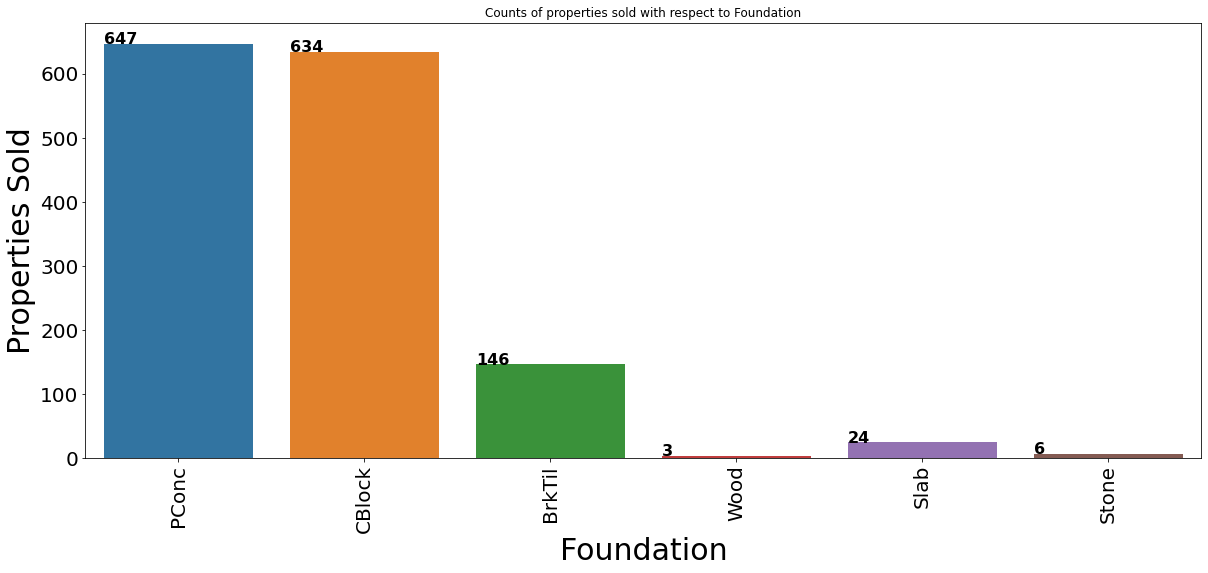

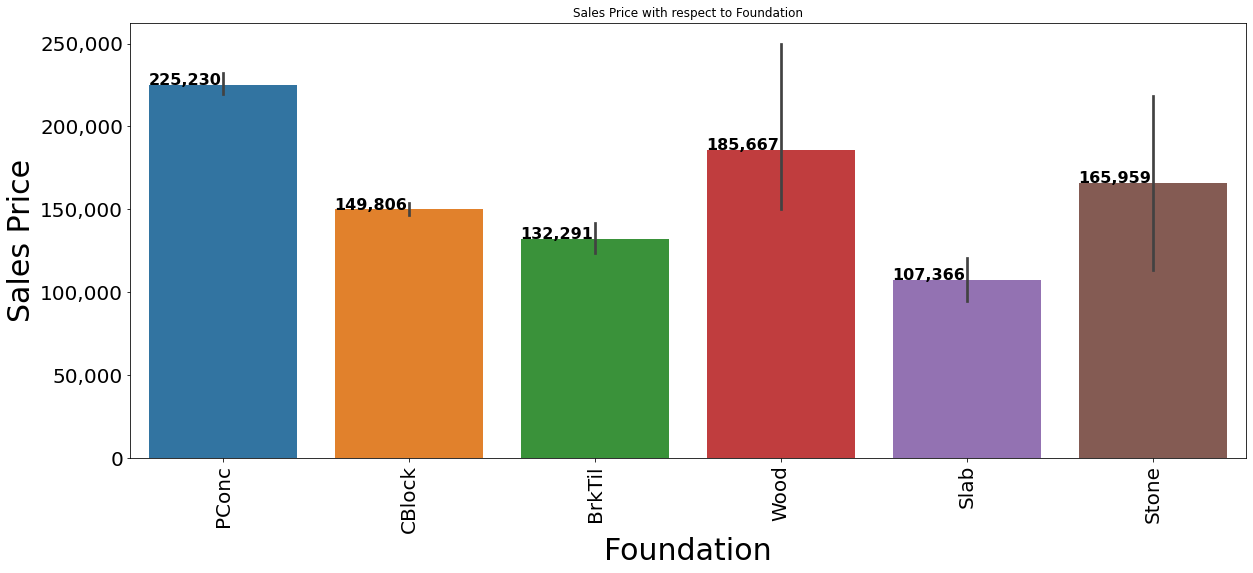

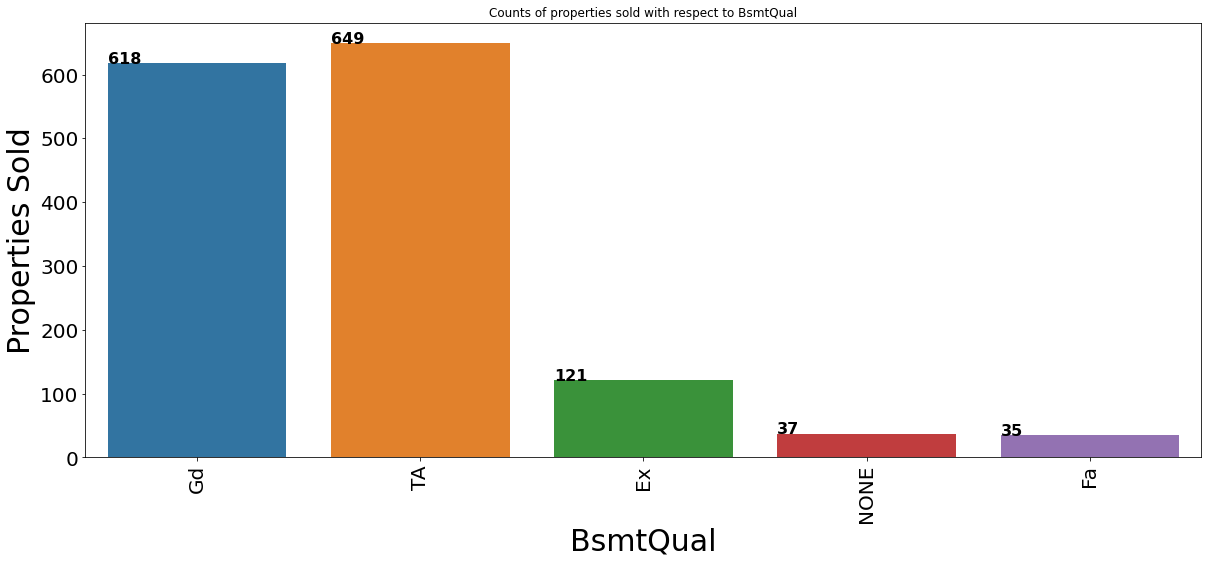

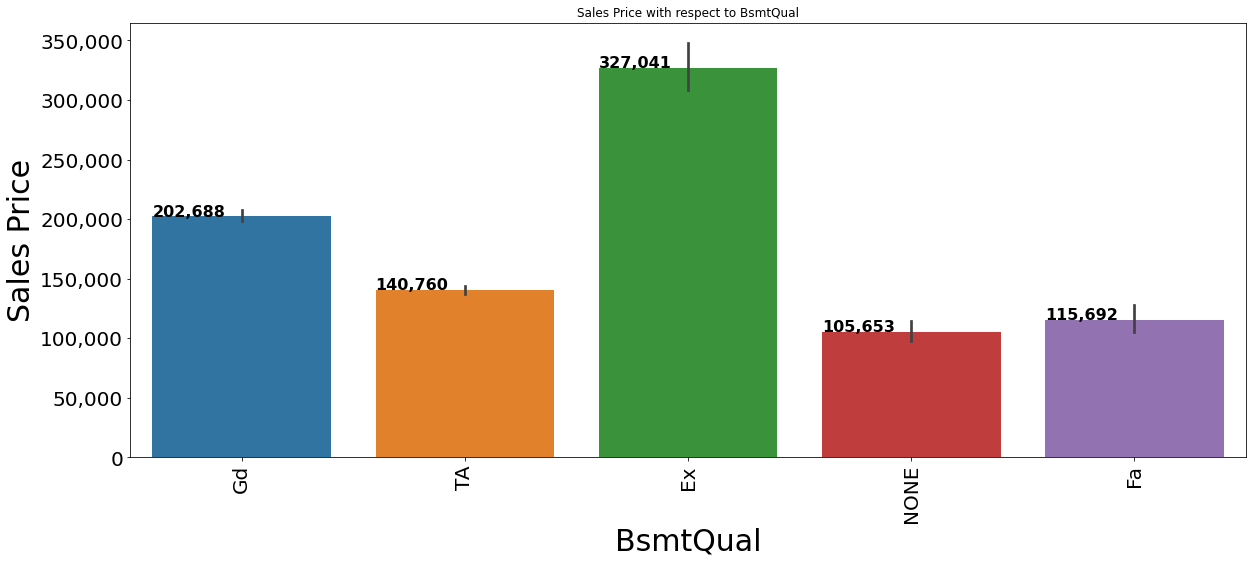

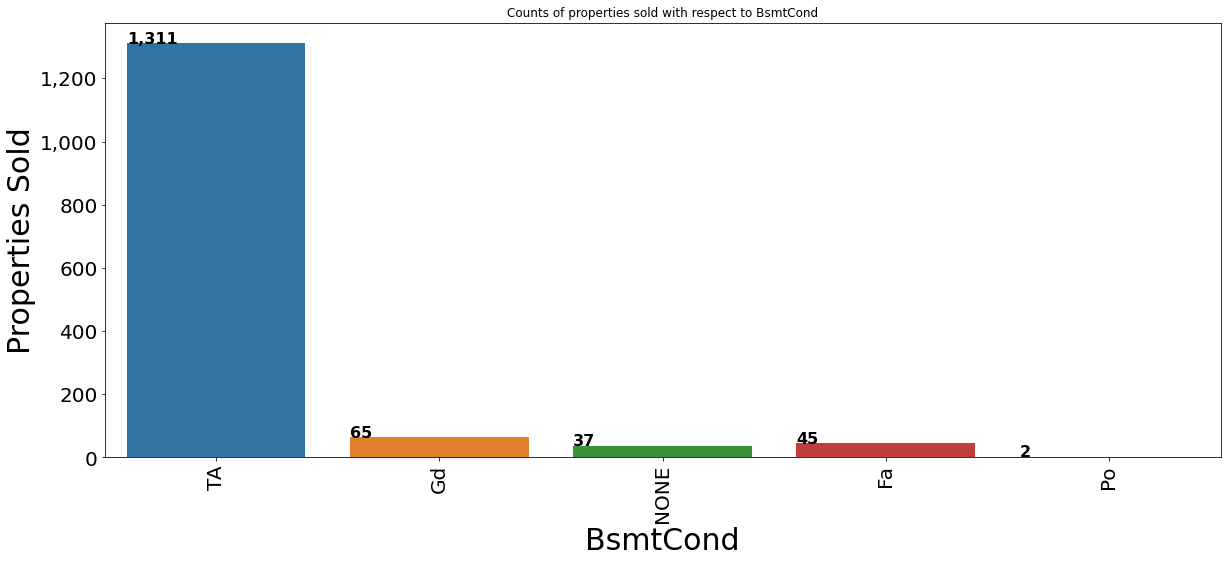

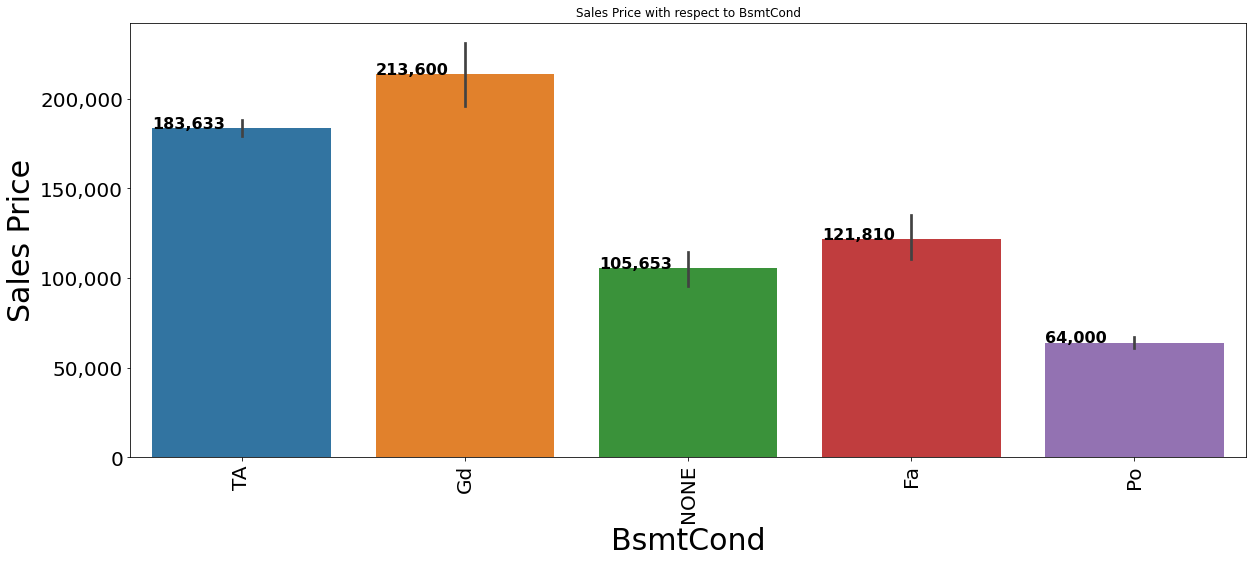

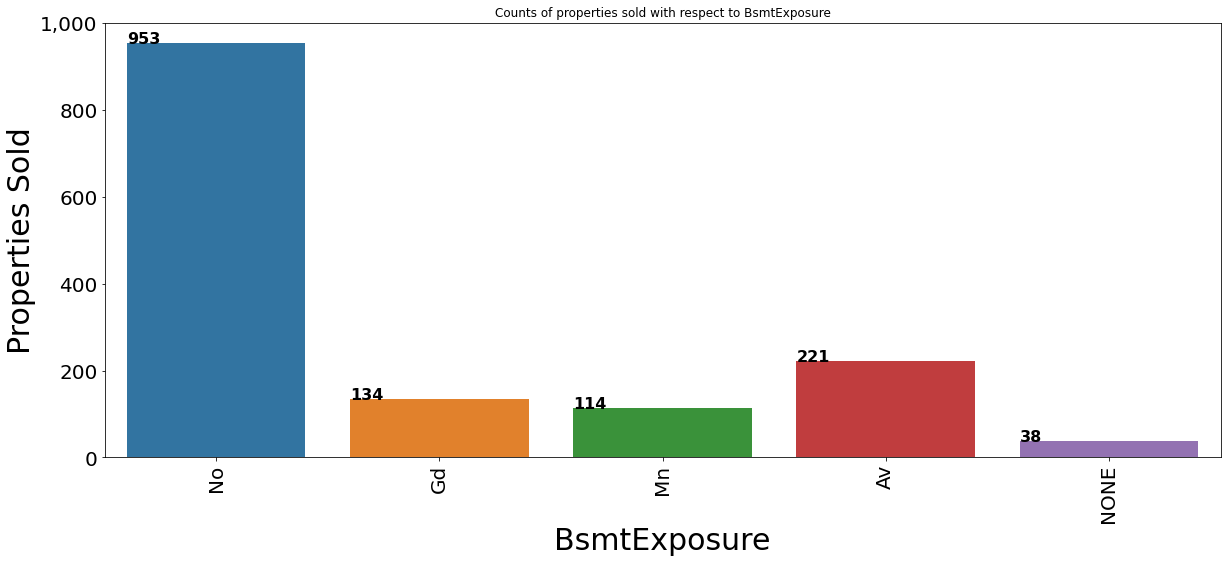

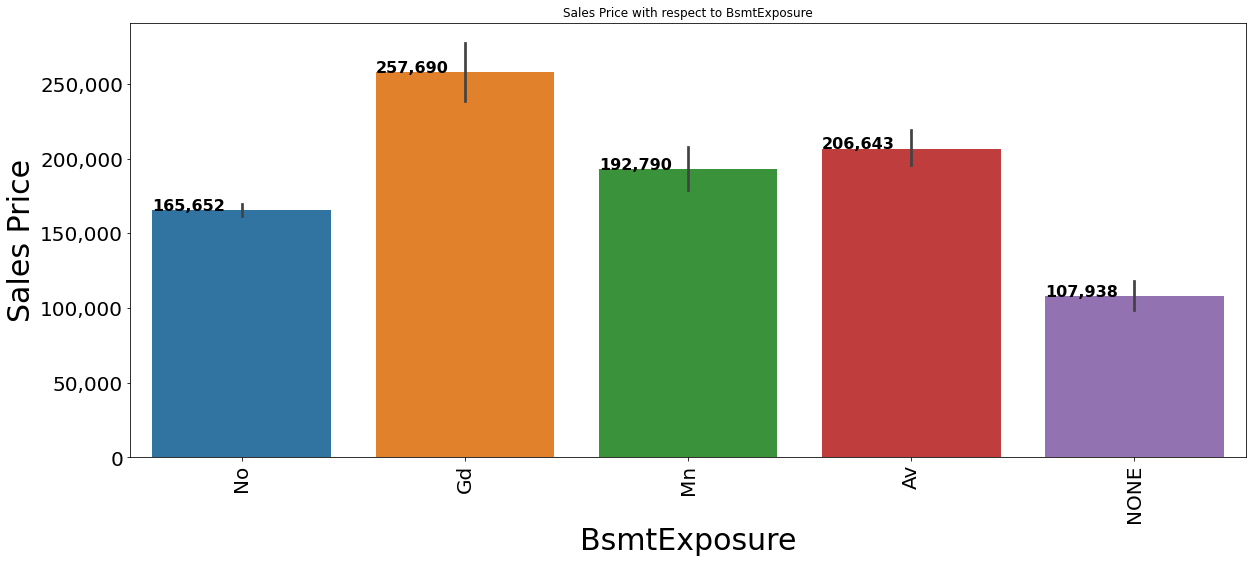

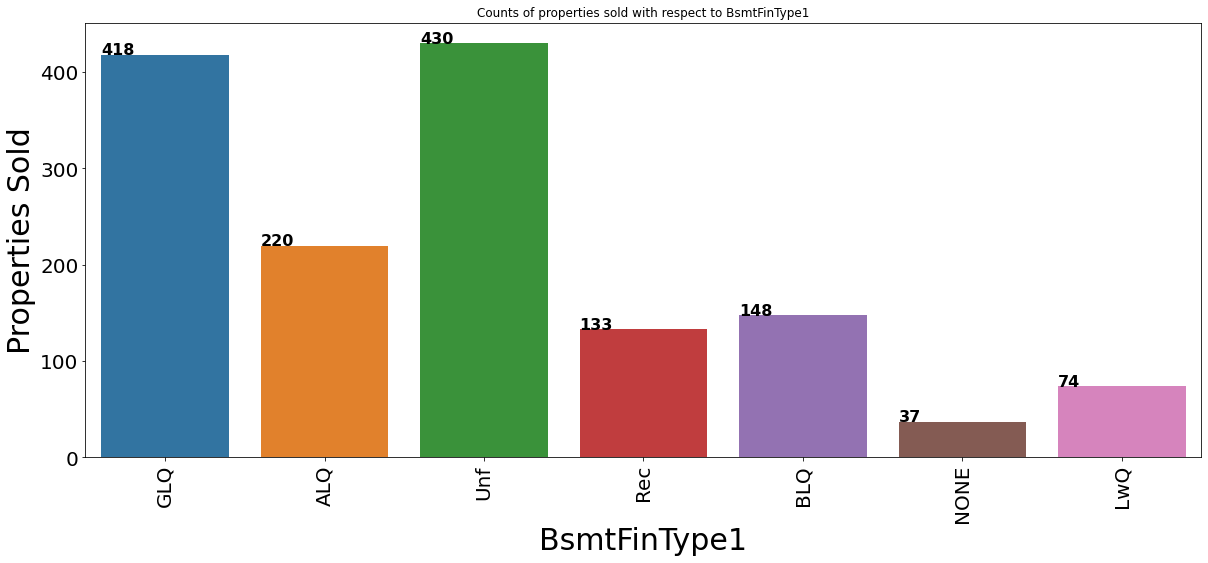

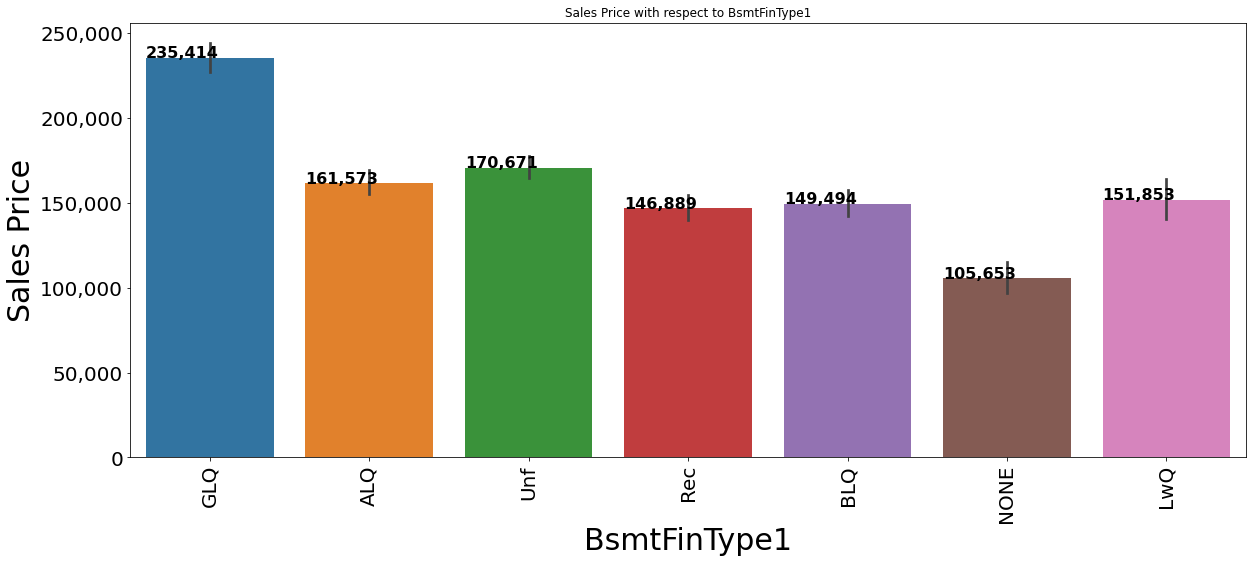

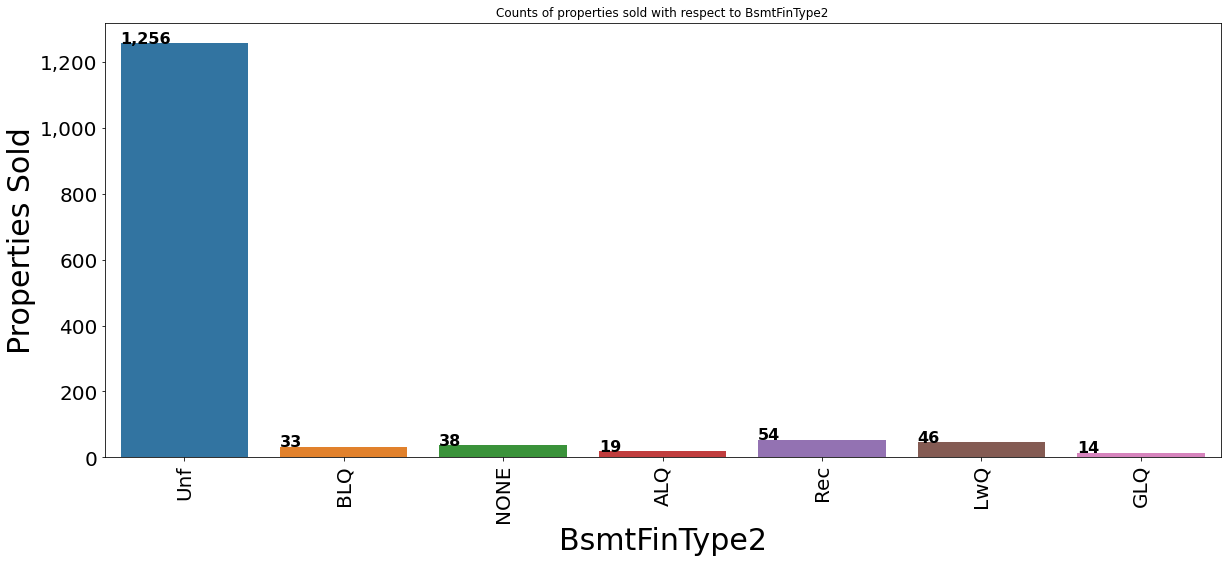

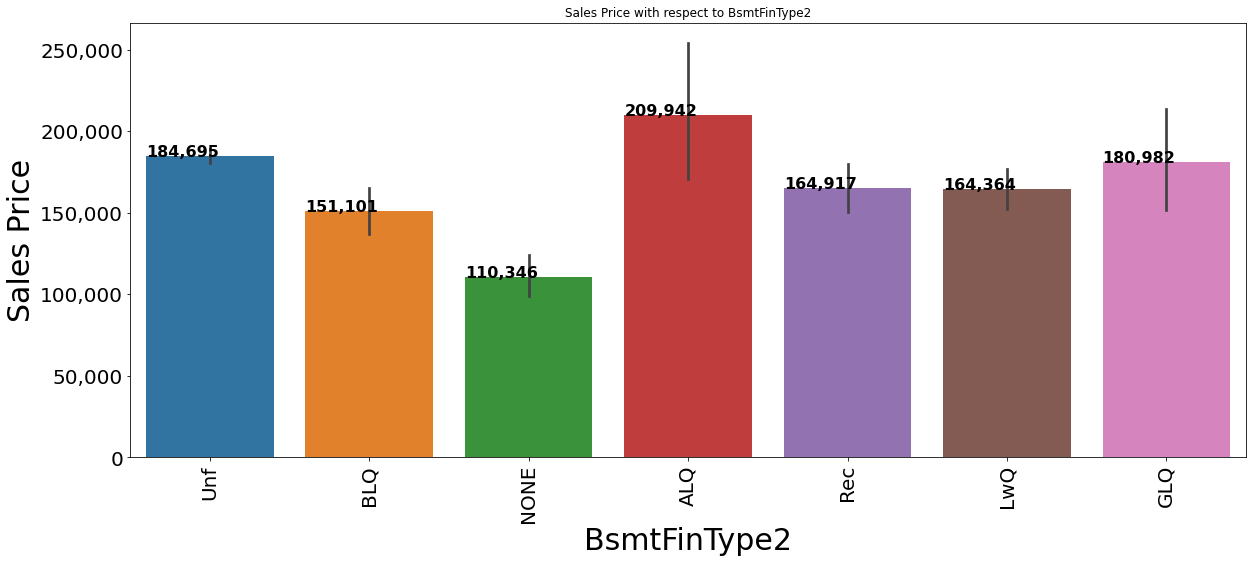

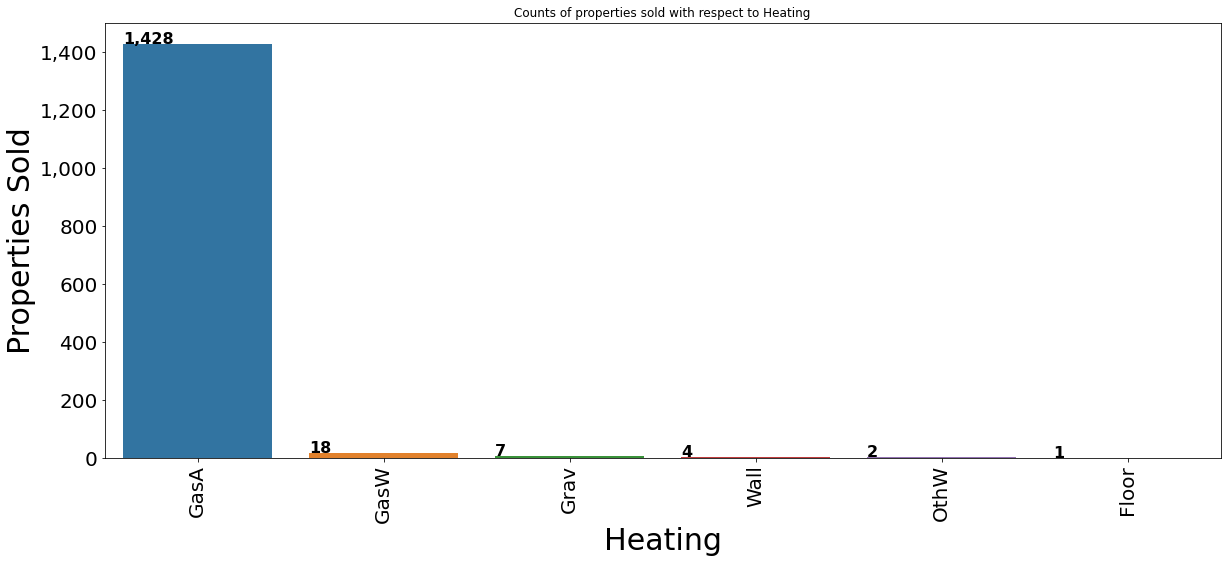

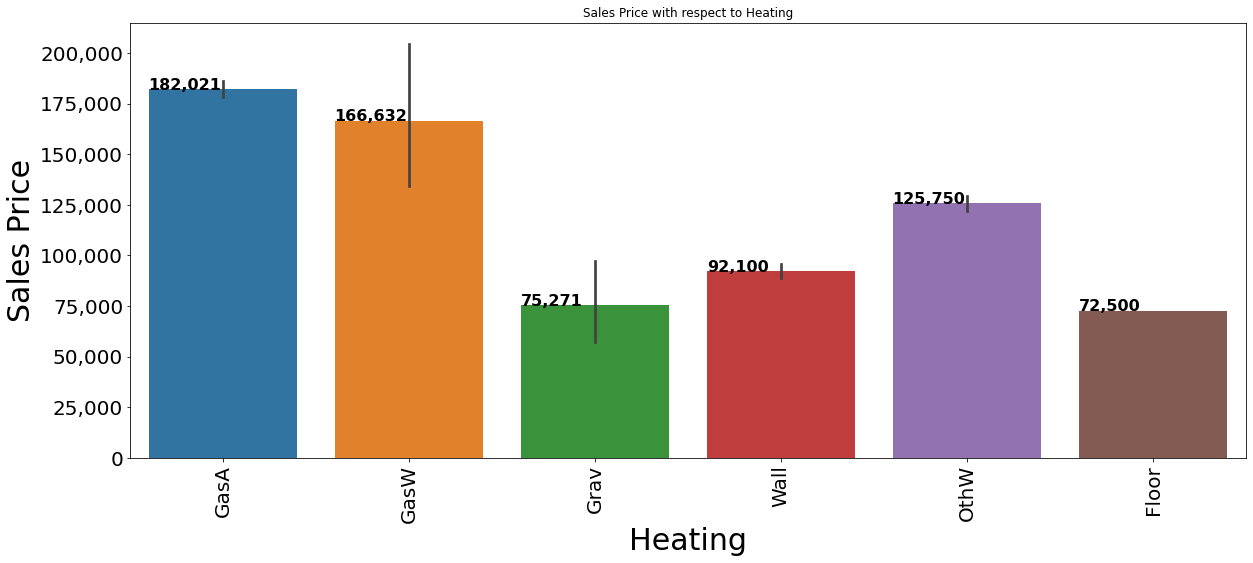

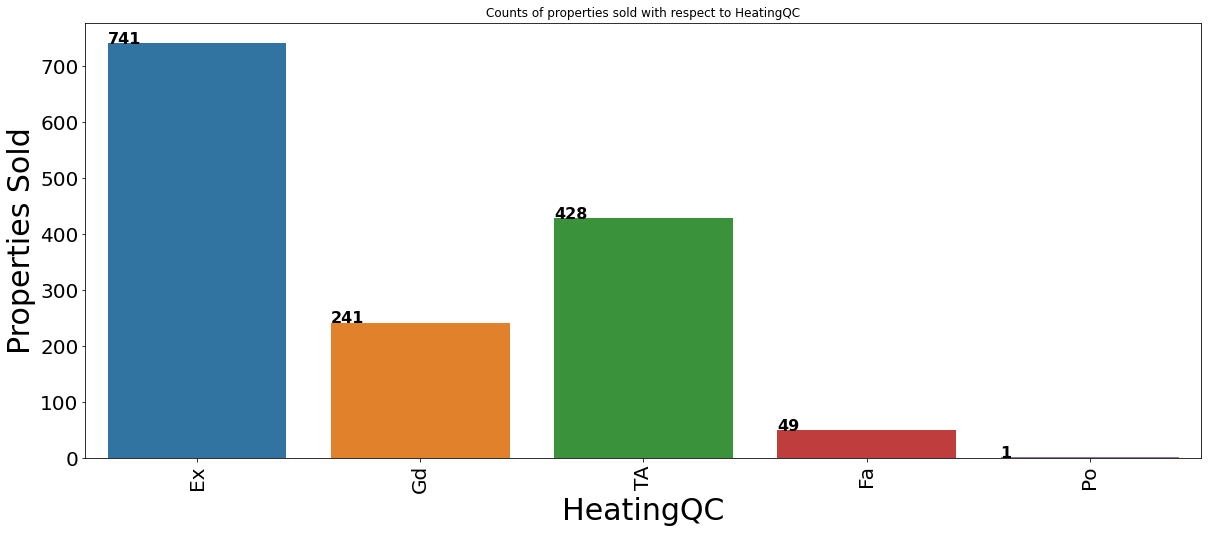

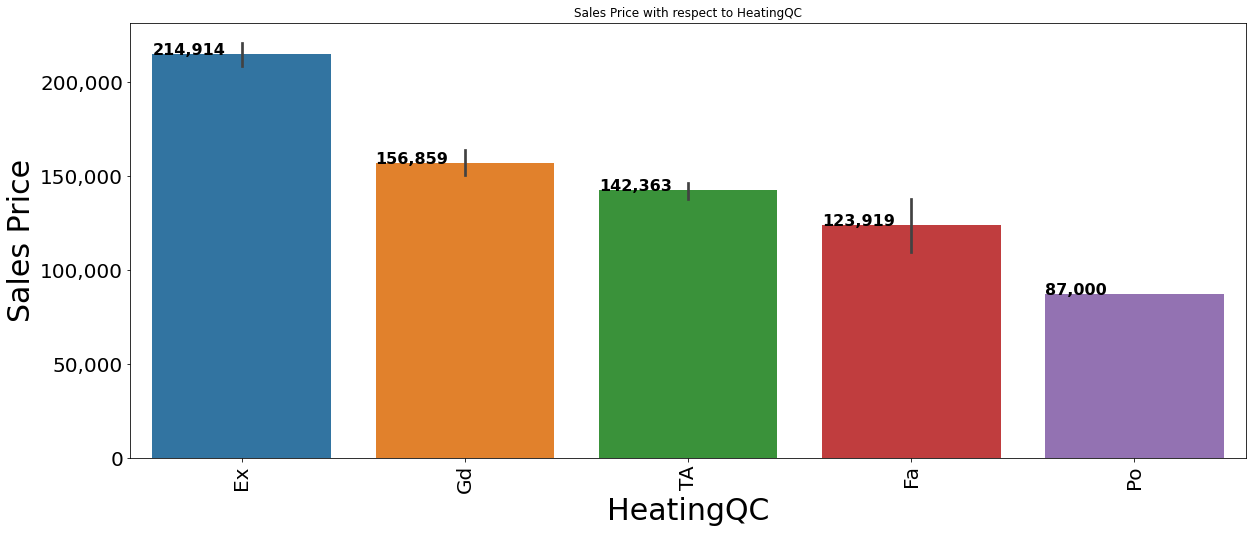

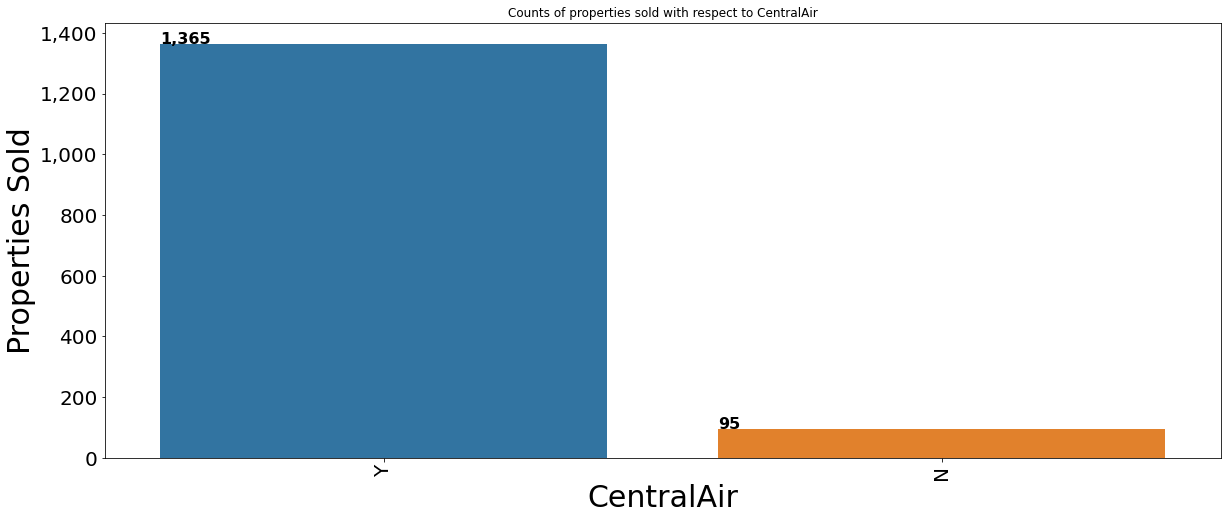

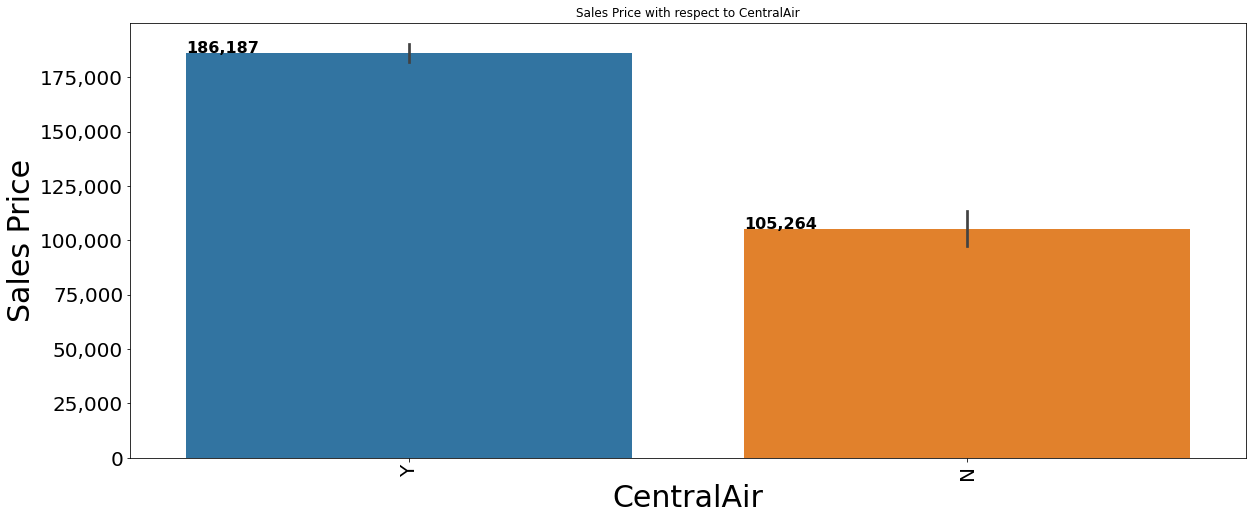

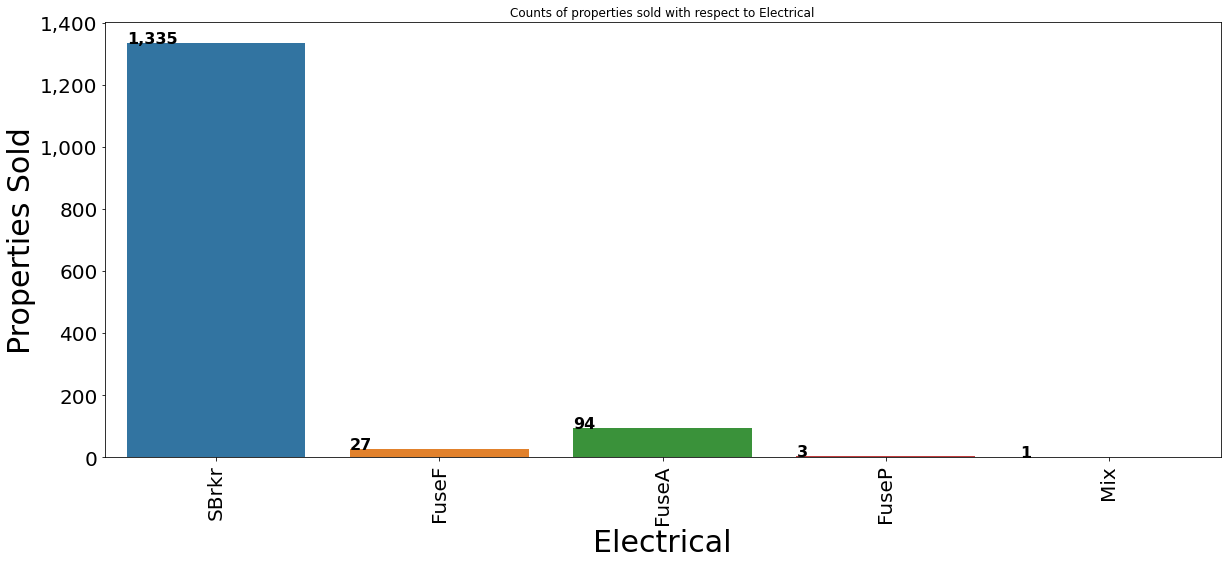

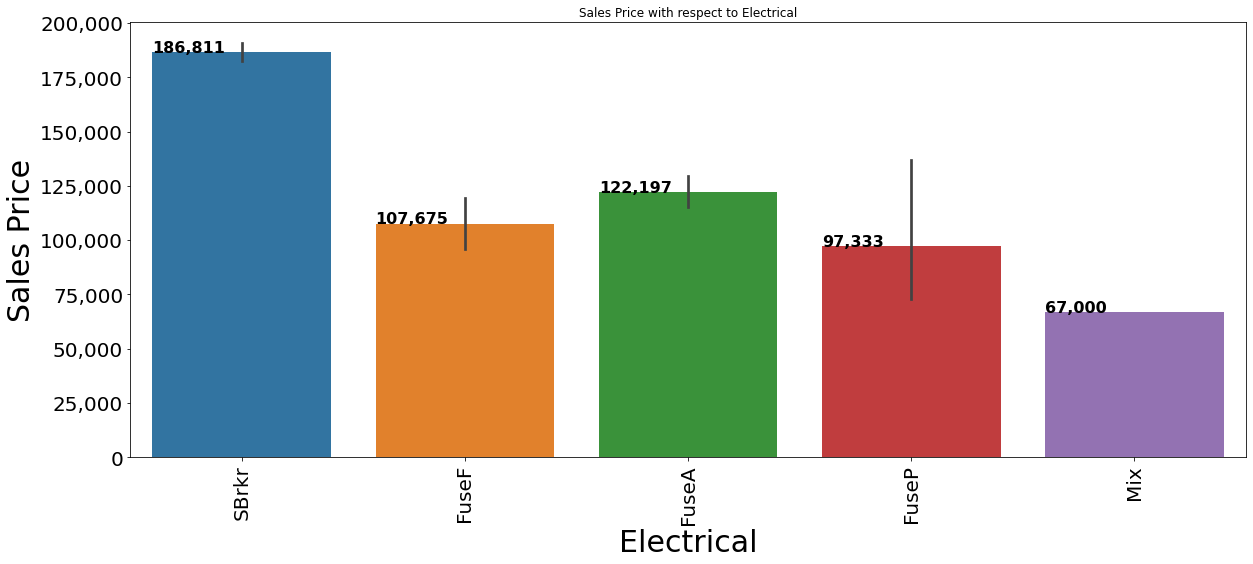

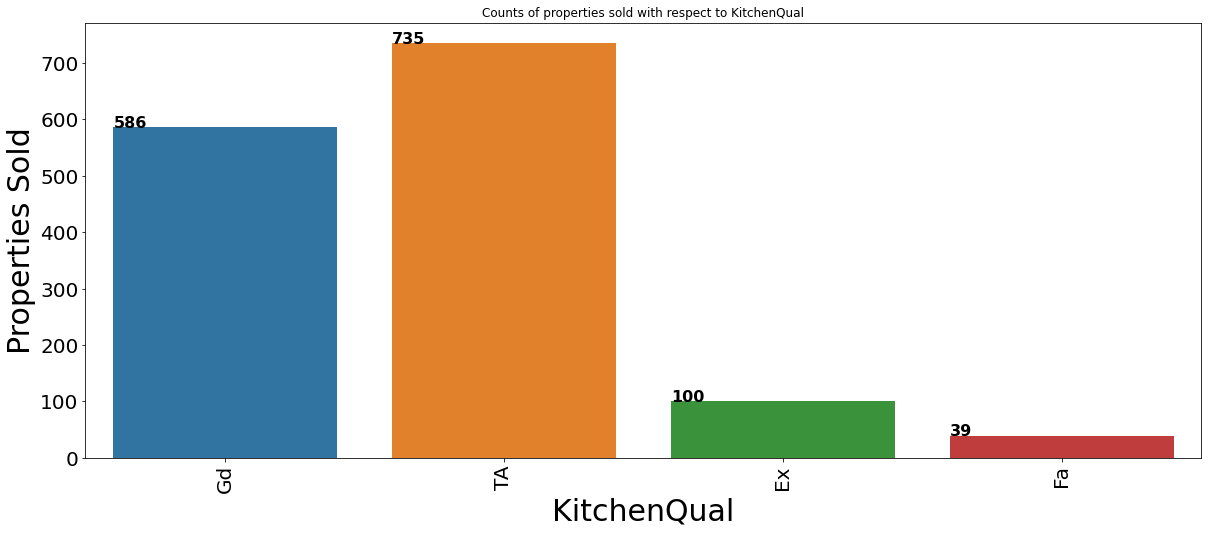

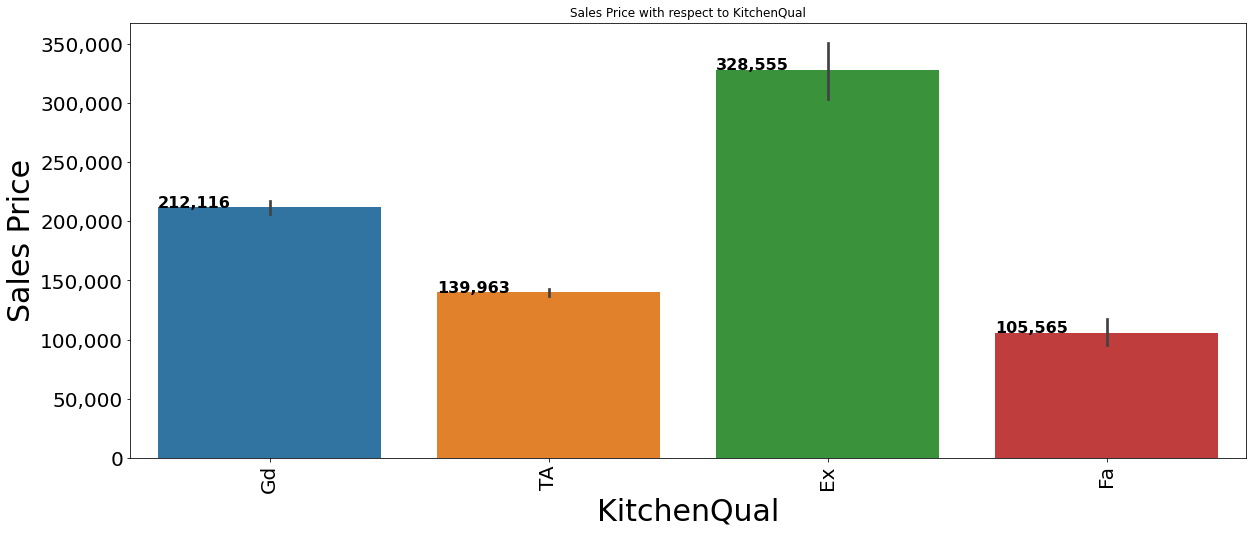

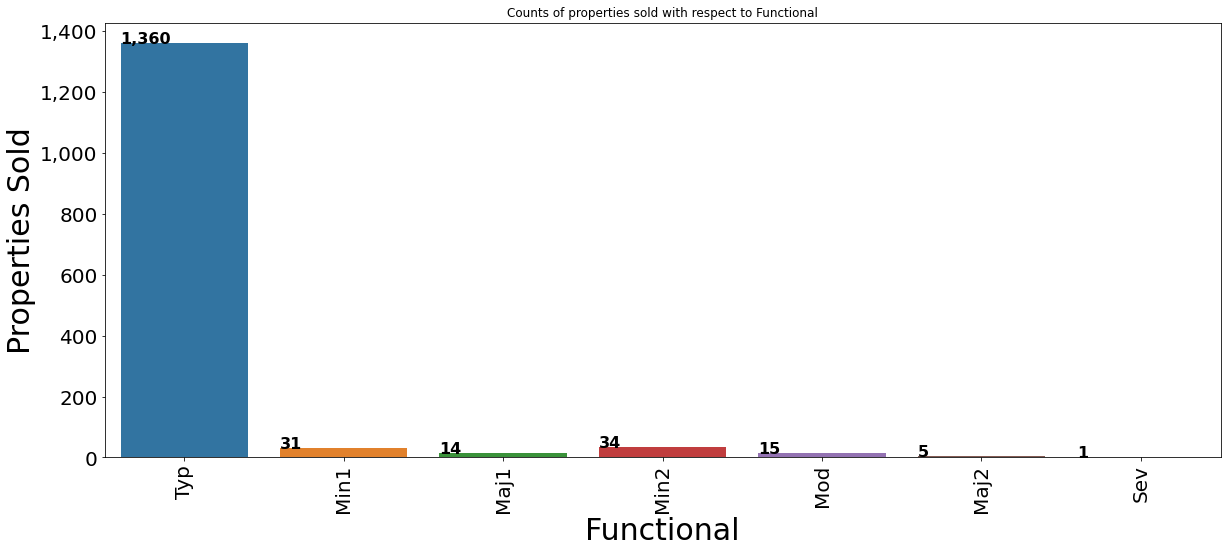

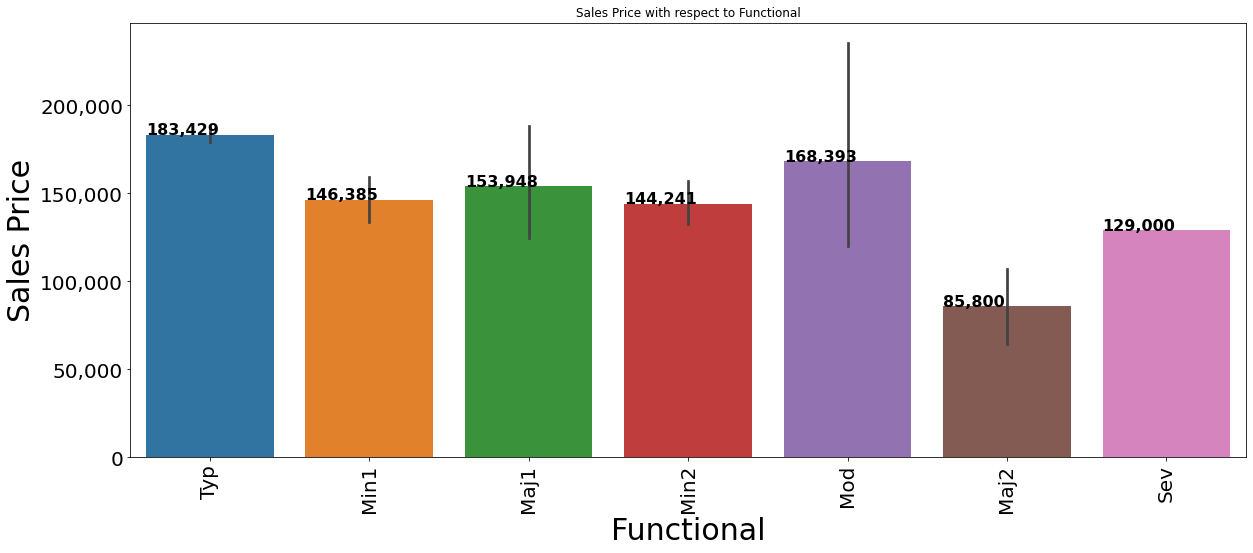

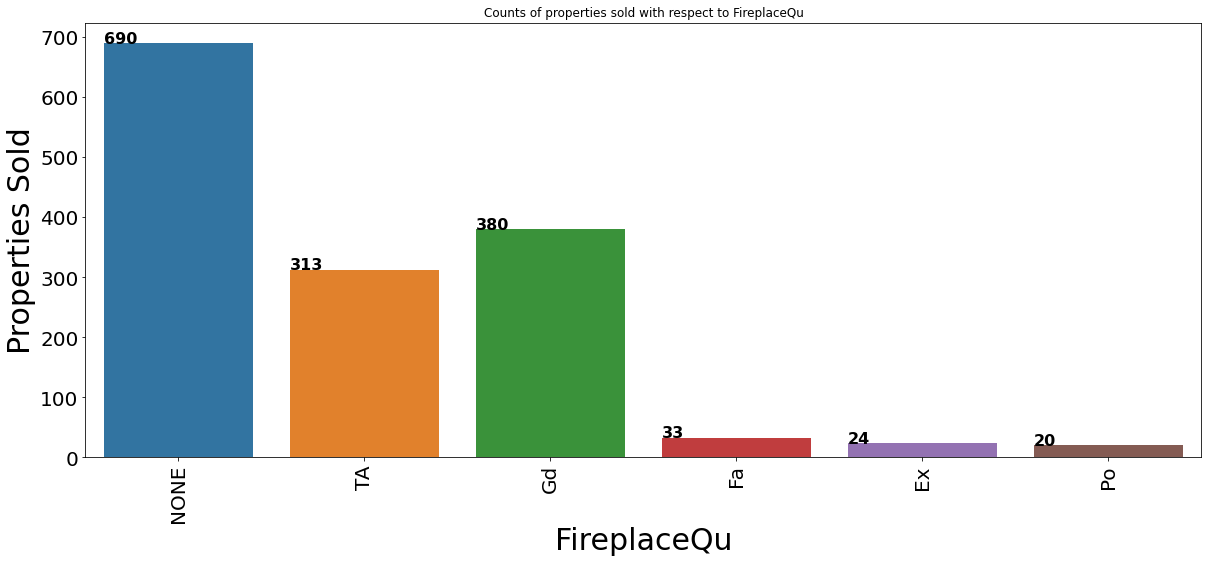

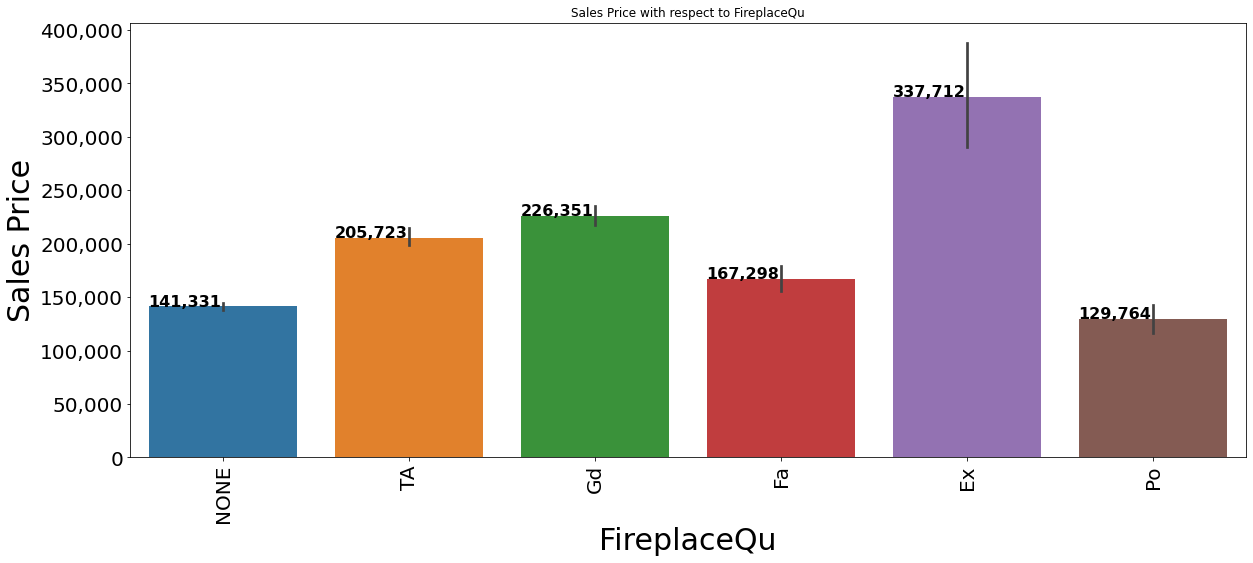

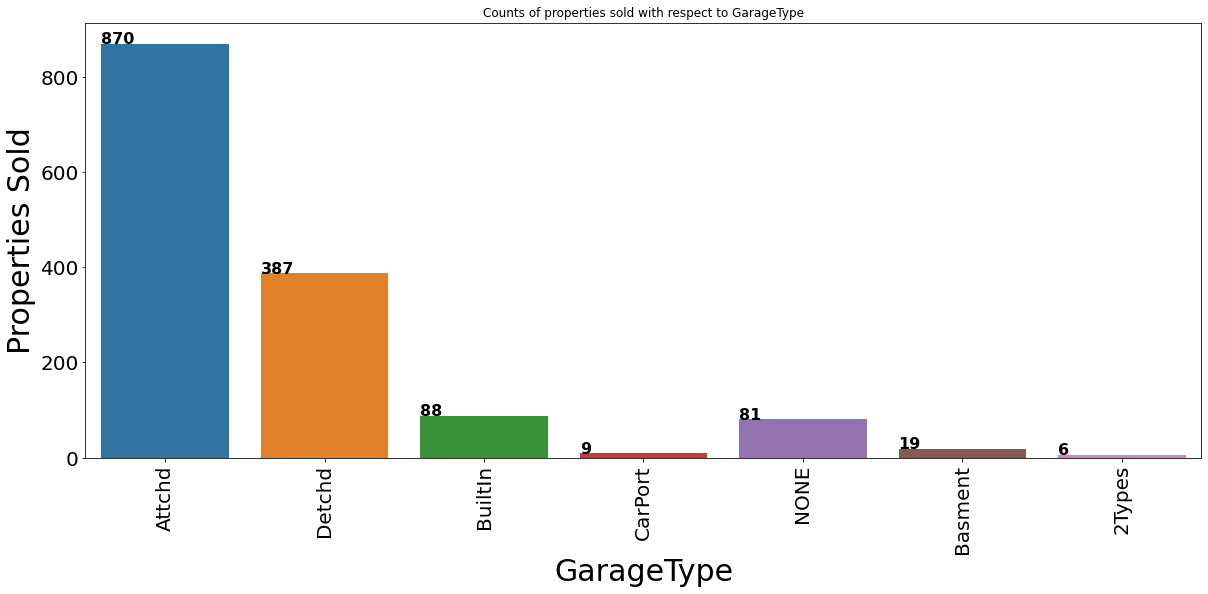

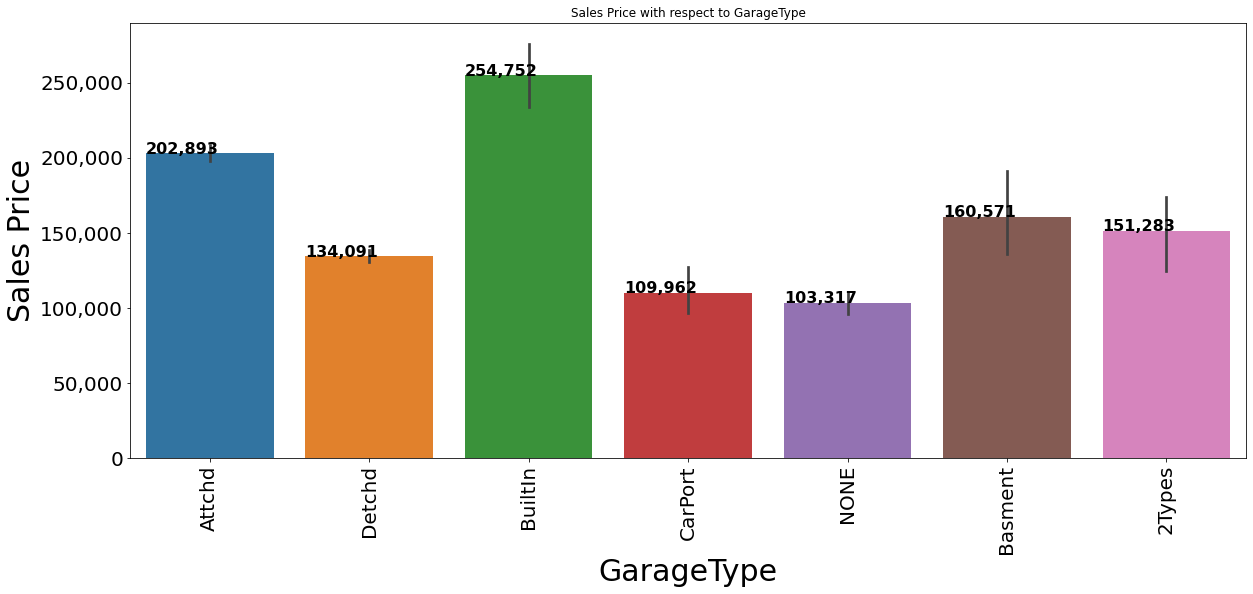

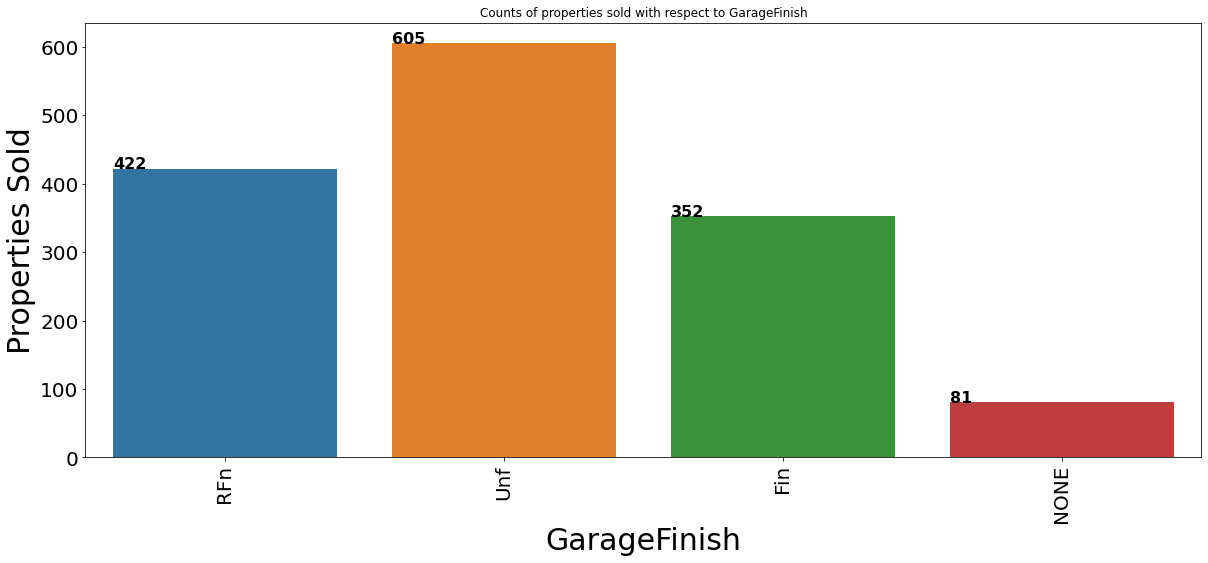

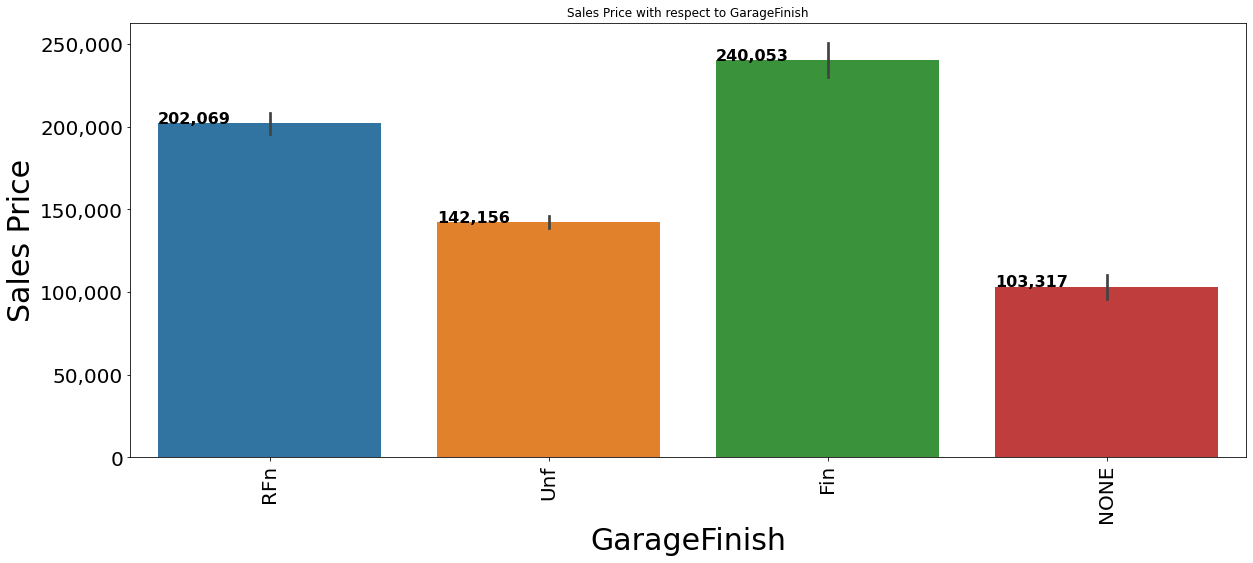

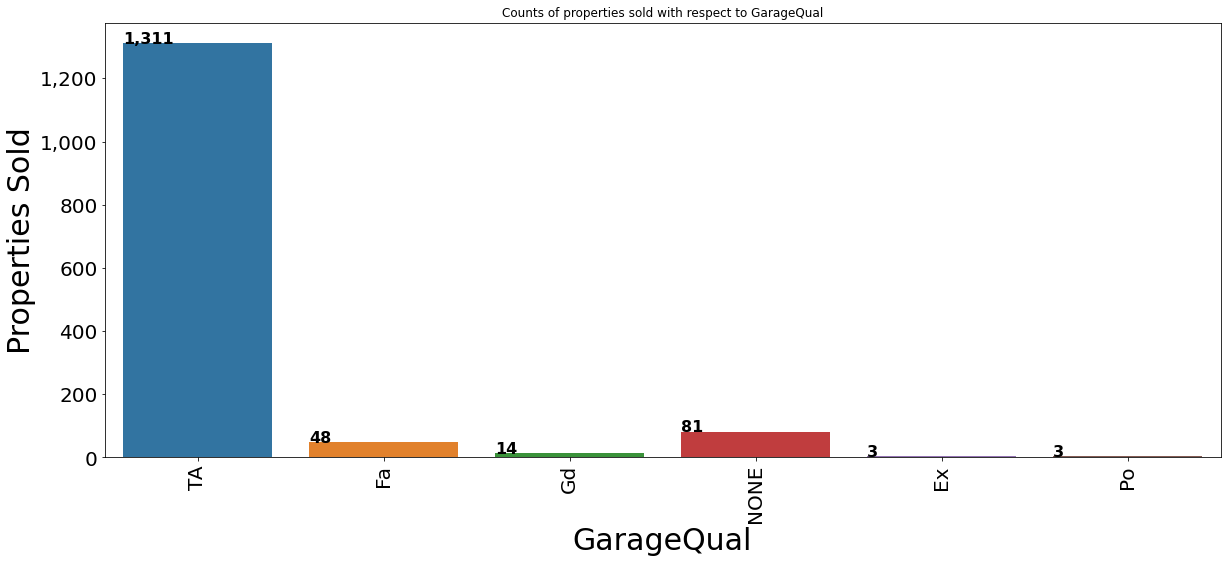

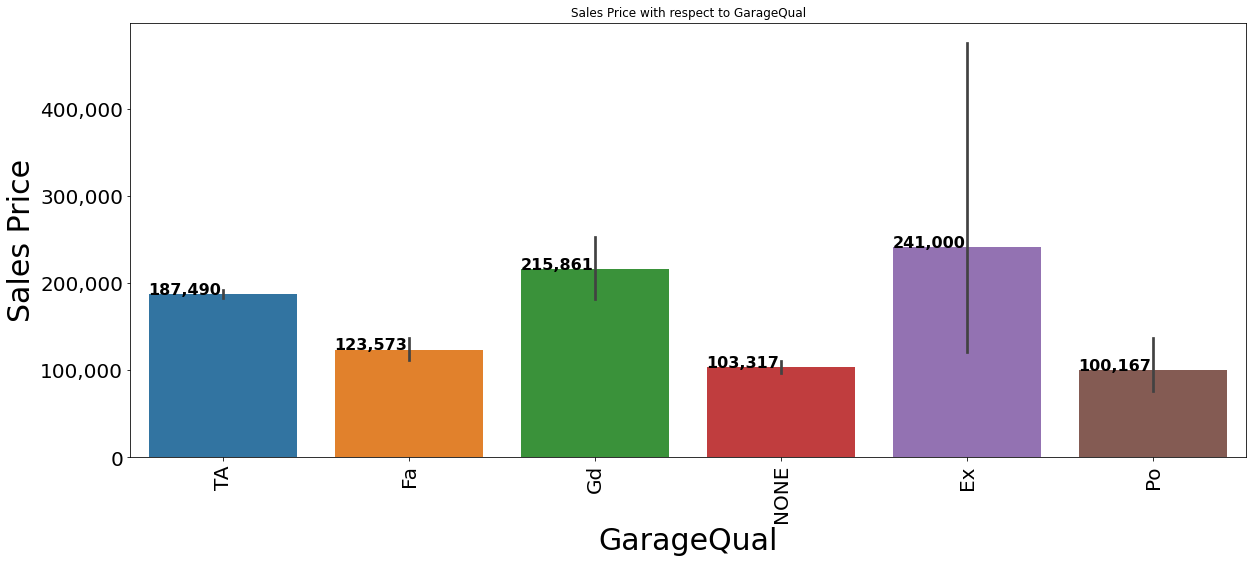

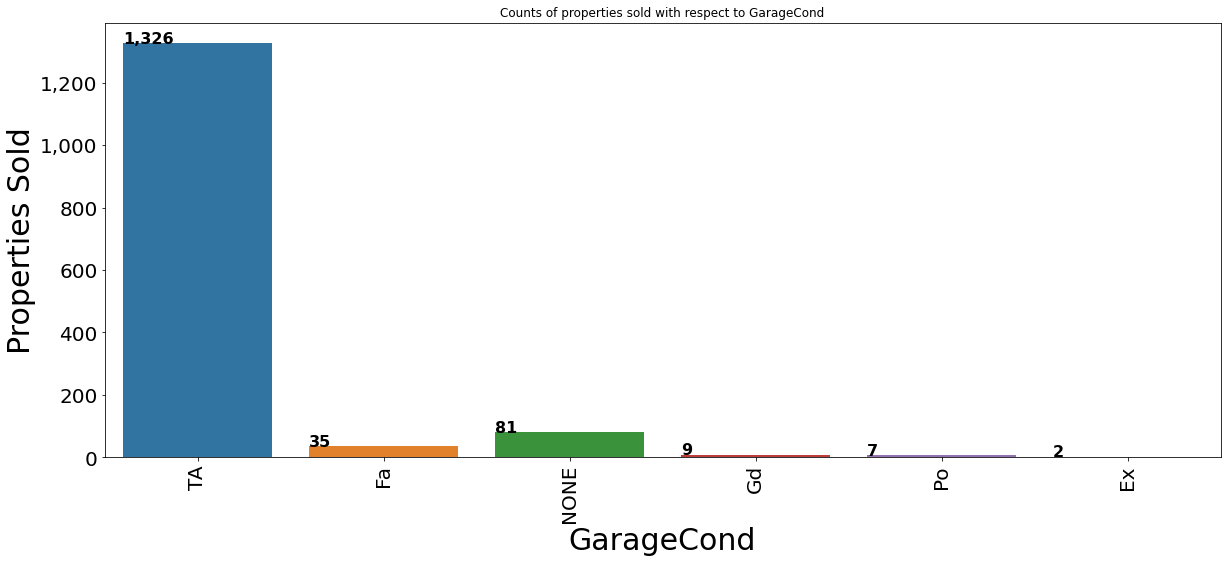

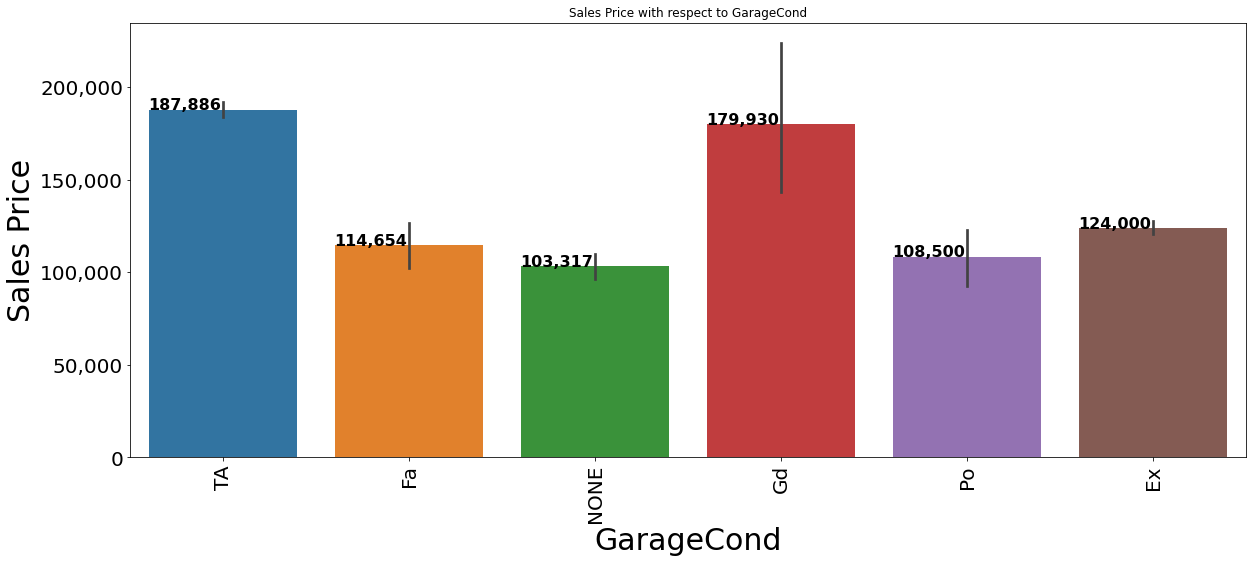

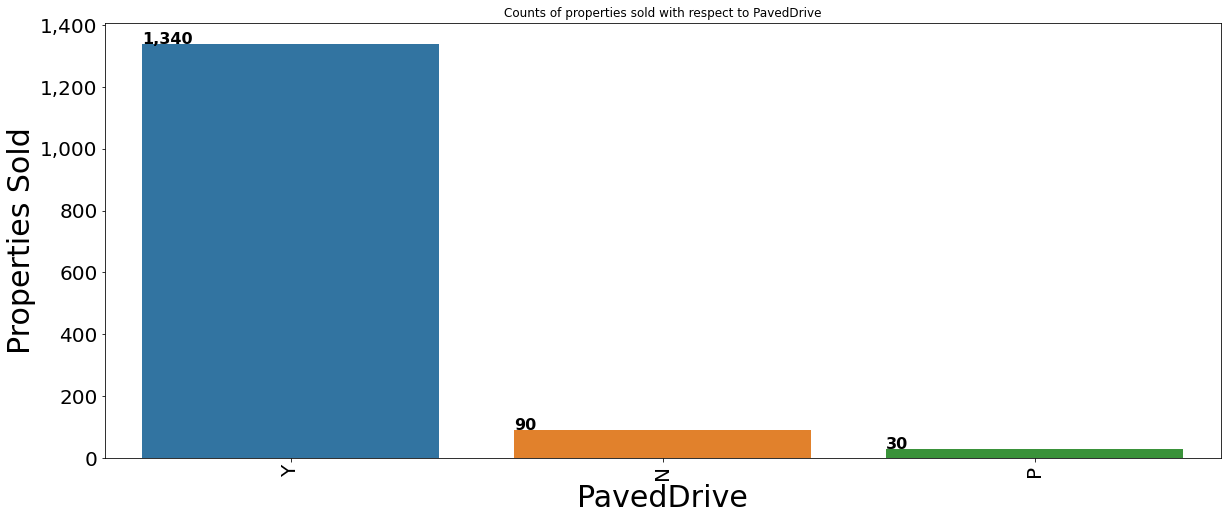

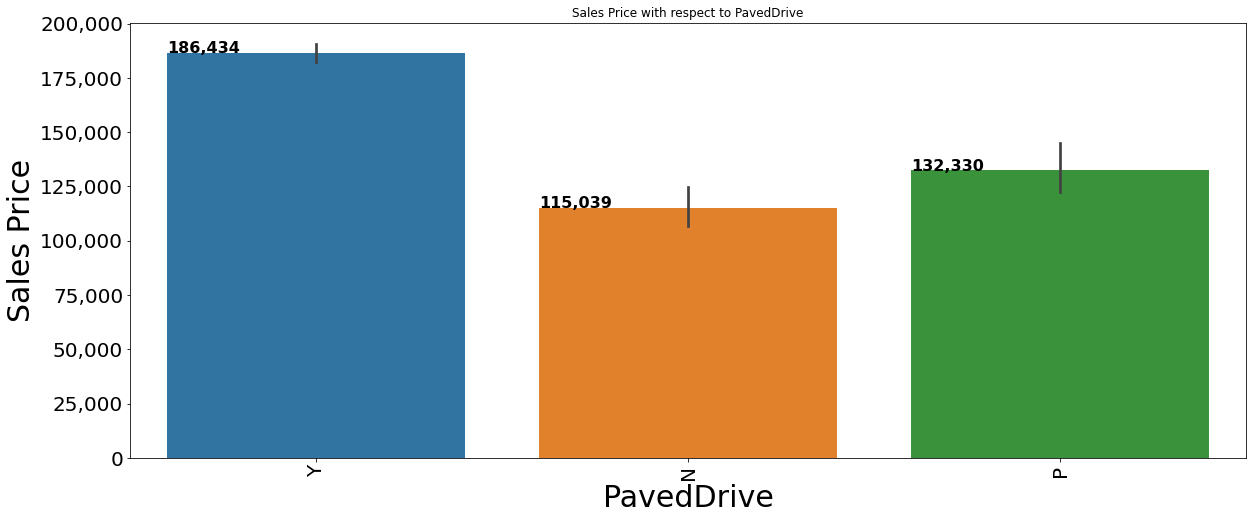

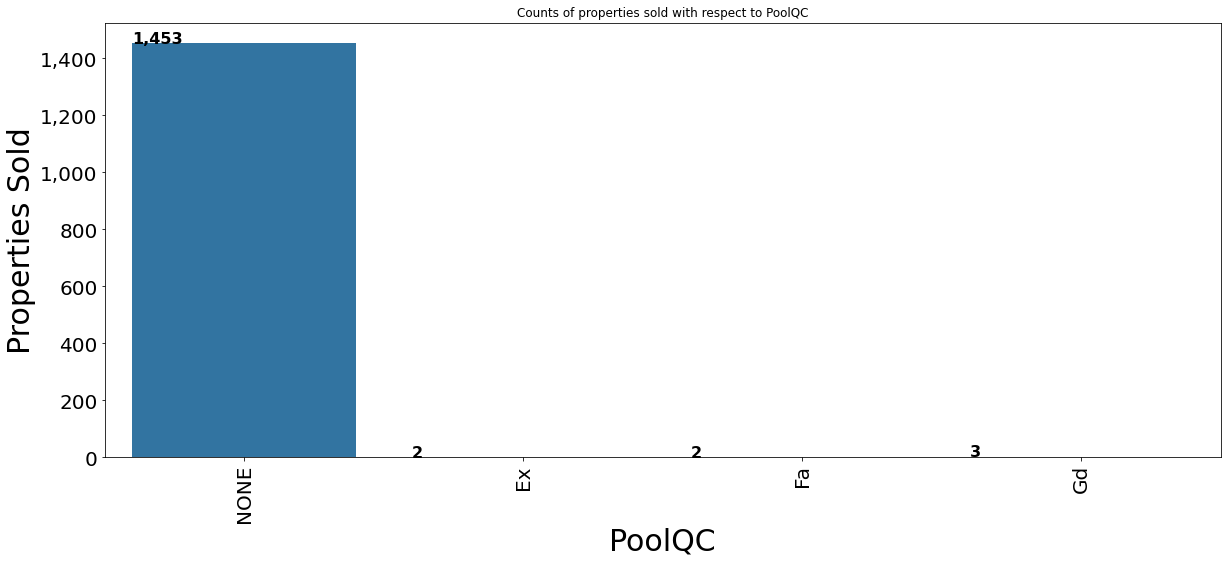

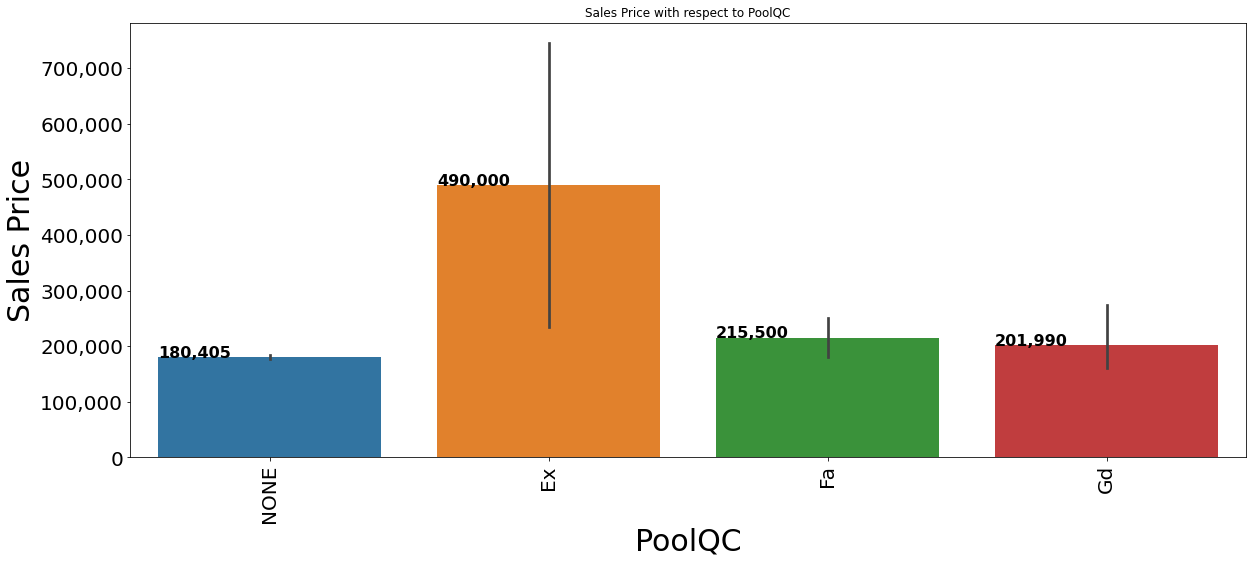

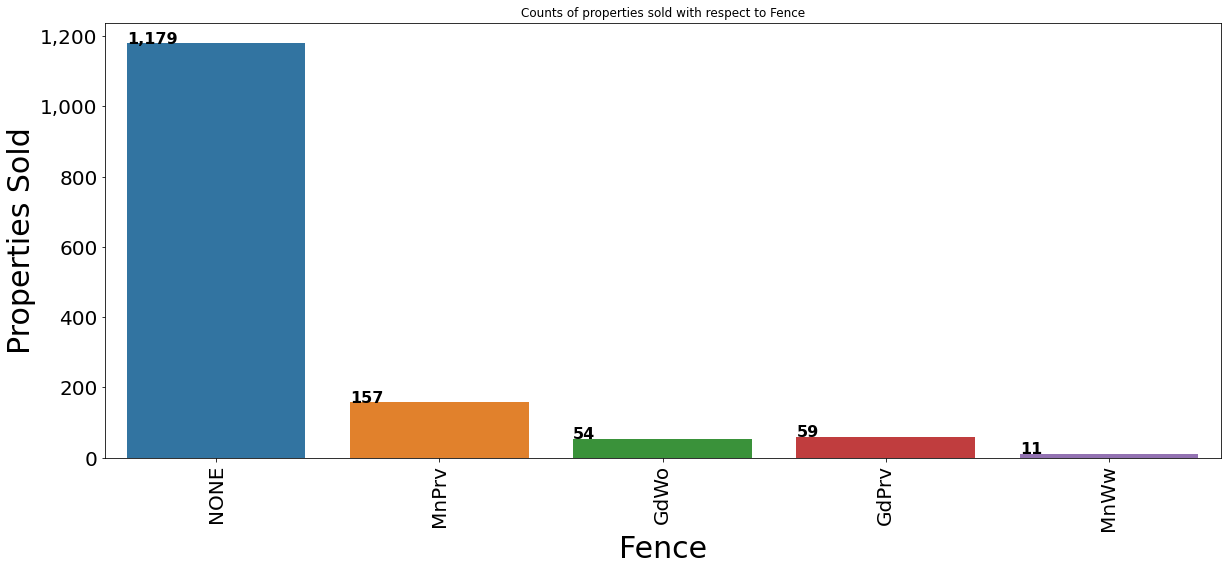

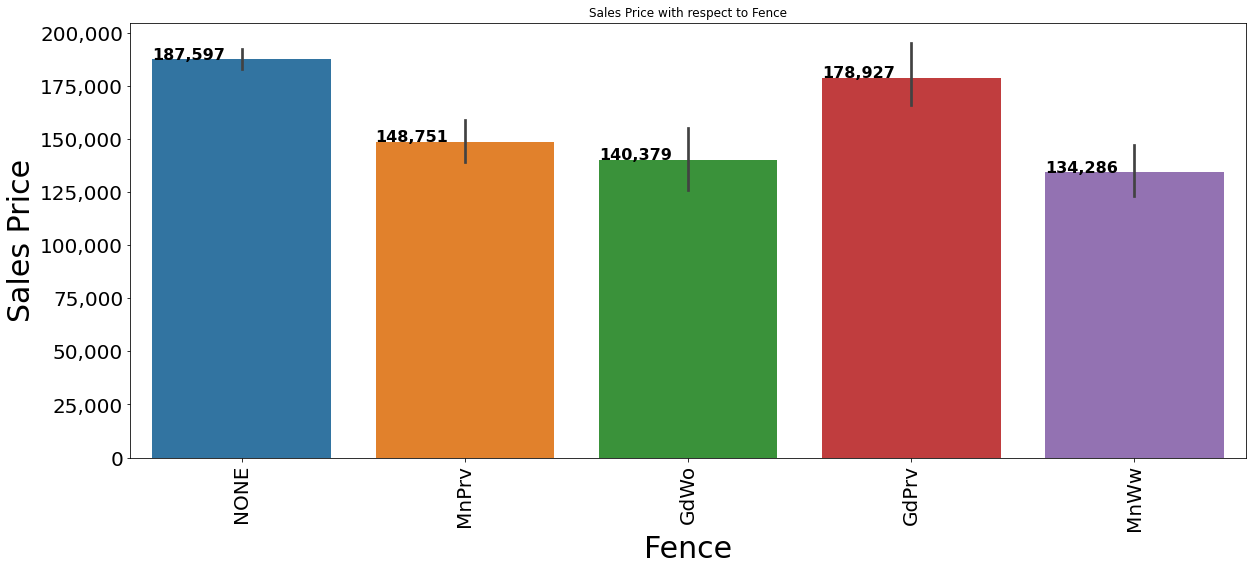

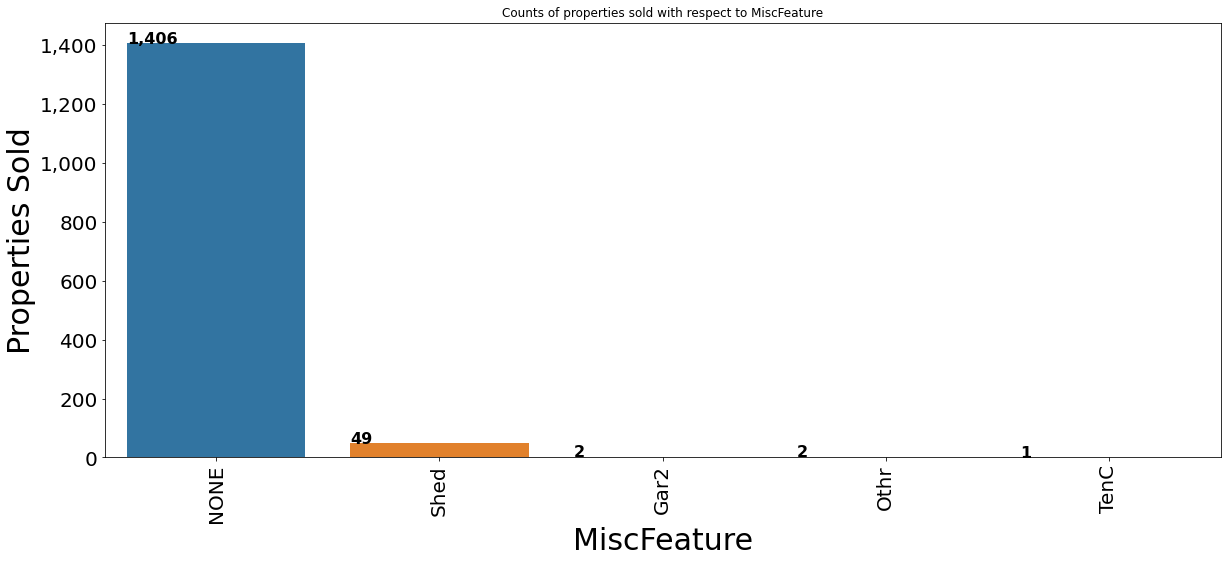

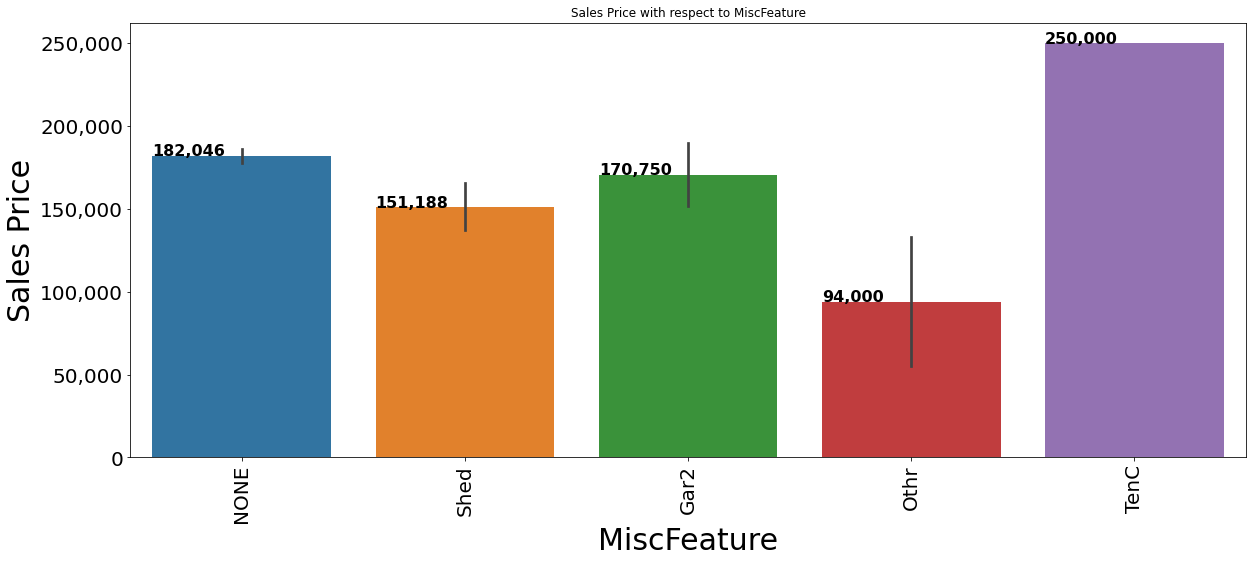

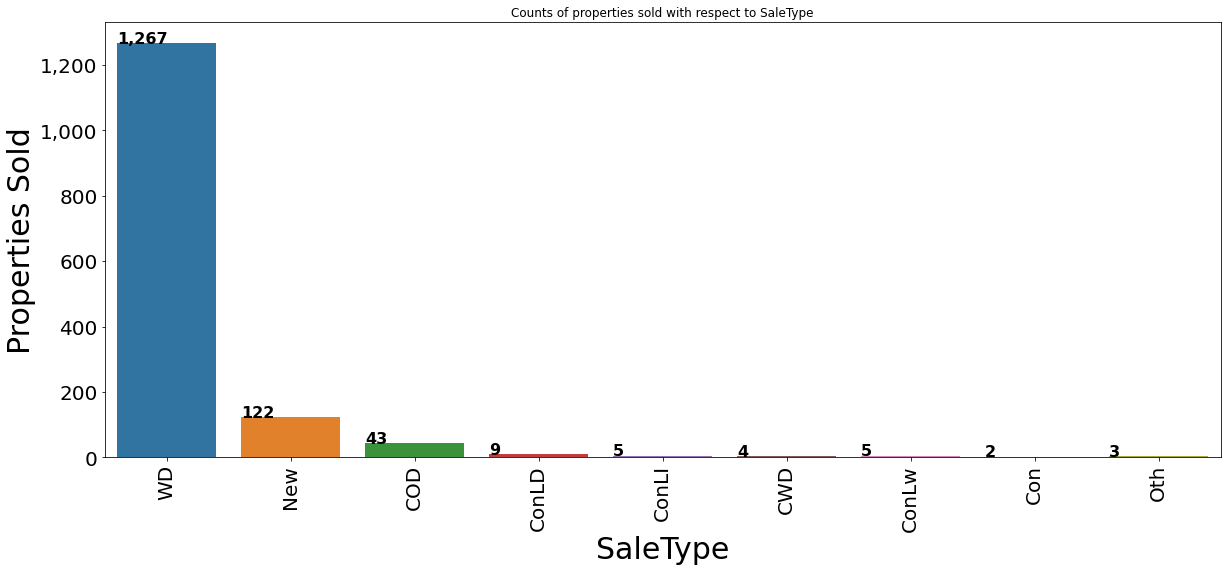

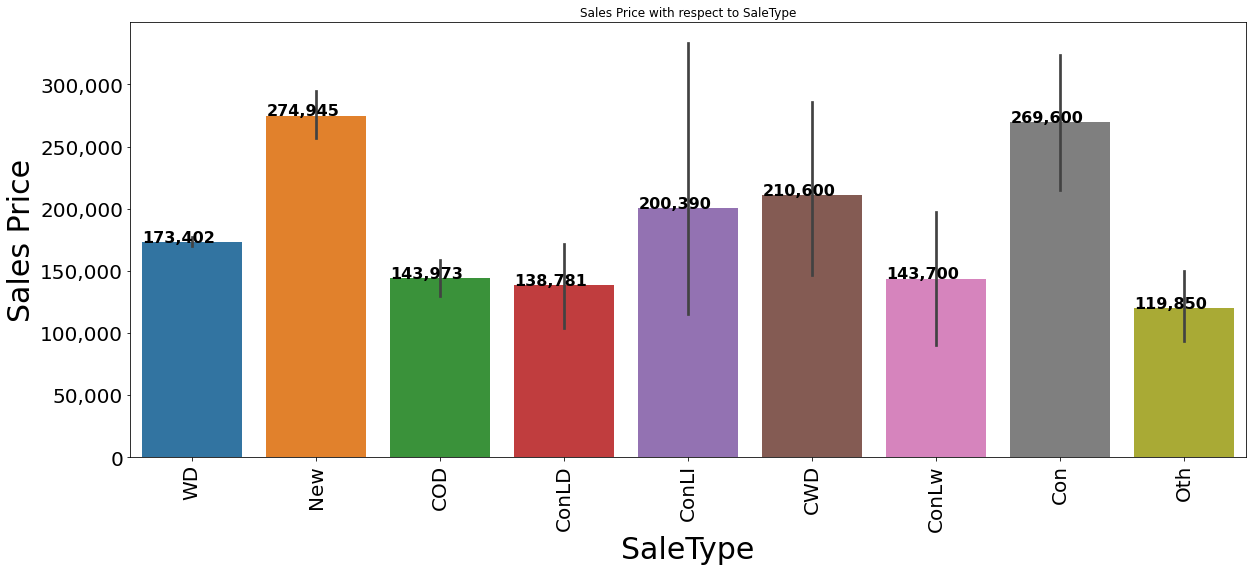

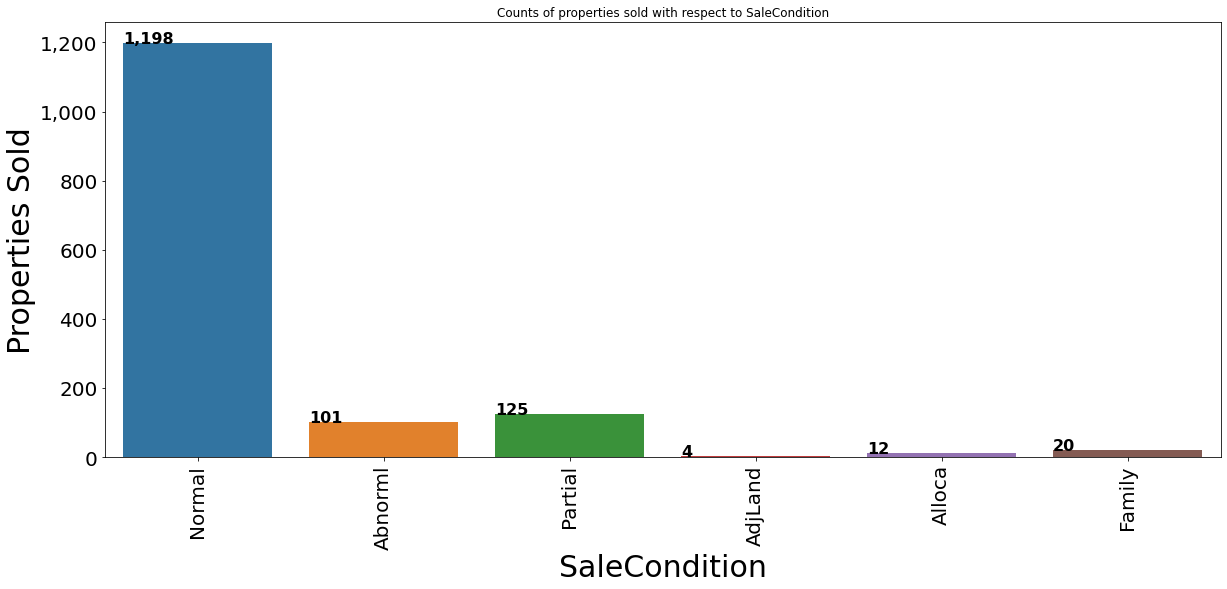

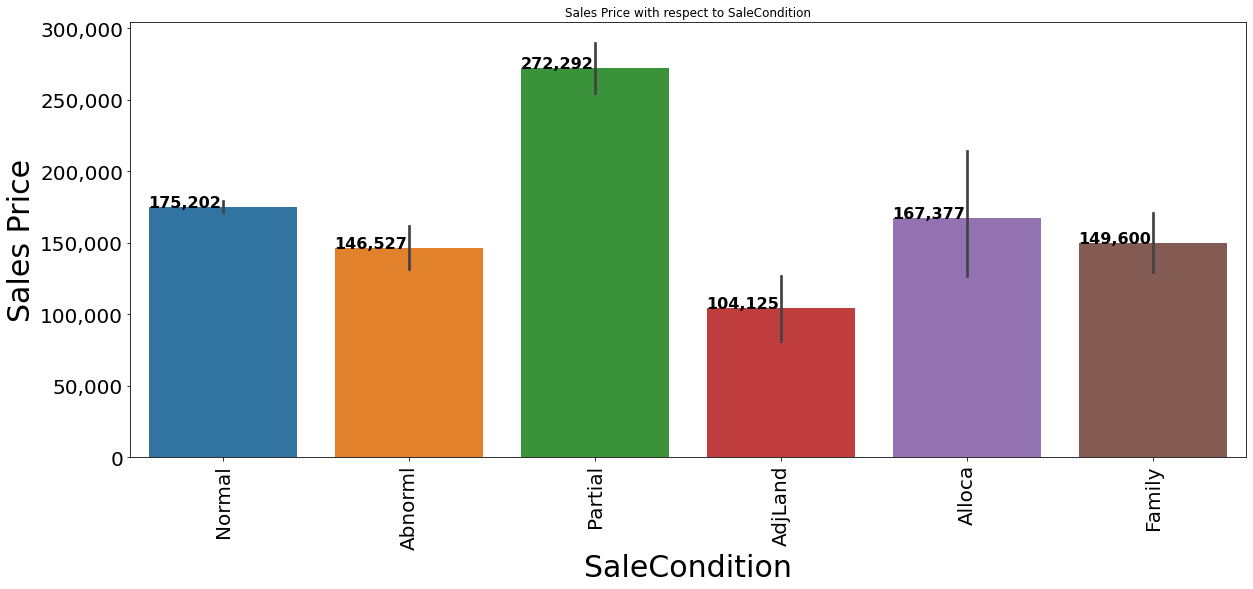

In [32]:

for col in ObjectCols:
    ShowCountAndSalesPlot(dfinit,col,col,angl=90)


**Insights:**
Here are some of the observations without any particular order from the graphs above
- Most of the houses sold were those with dwelling of `1-STORY 1946 & NEWER ALL STYLES`
- Most of the houses sold were in Zone RL`	
- highest average price is in the neighborhood of `NoRidge`
- Most of the houses sold were `one-story buildings`
- house with `overall excellent quality` has the highest average price
- the prices of houses with `central air conditioning` are much higher than those without it
- the prices of the houses with `Excellent Fire Place Quality` are higher than others


## Inspect our target variable and see if any transformation required

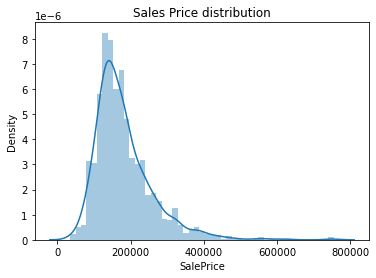

In [33]:
ax=sns.distplot(dfinit['SalePrice'])
plt.title(f"Sales Price distribution")
plt.show()

In [34]:
## Check the kurtosis of target variable
dfinit['SalePrice'].kurt()

6.536281860064529

The kurtosis is greater than 1, so the distribution of target variable is highly peaked.


**Insight:**
From the above graph and kurtosis value, we can see a tale on the right side of the figure. Let's remove it by applying the log transformation.

In [35]:
dfinit['SalePrice']=np.log1p(dfinit['SalePrice'])

In [36]:
#validate again
dfinit['SalePrice'].kurt()

0.809519155707878

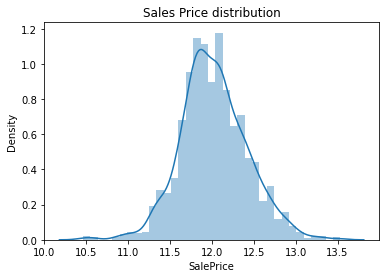

In [37]:
ax=sns.distplot(dfinit['SalePrice'])
plt.title(f"Sales Price distribution")
plt.show()

**Insight:**
From the above graph and kurtosis value, we can see that the data is now normalized


### Outliers Treatment

<b>Let's create boxplot for all the numeric fileds and identify the outliers </b>

100%|███████████████████████████████████████████| 25/25 [00:00<00:00, 71.30it/s]


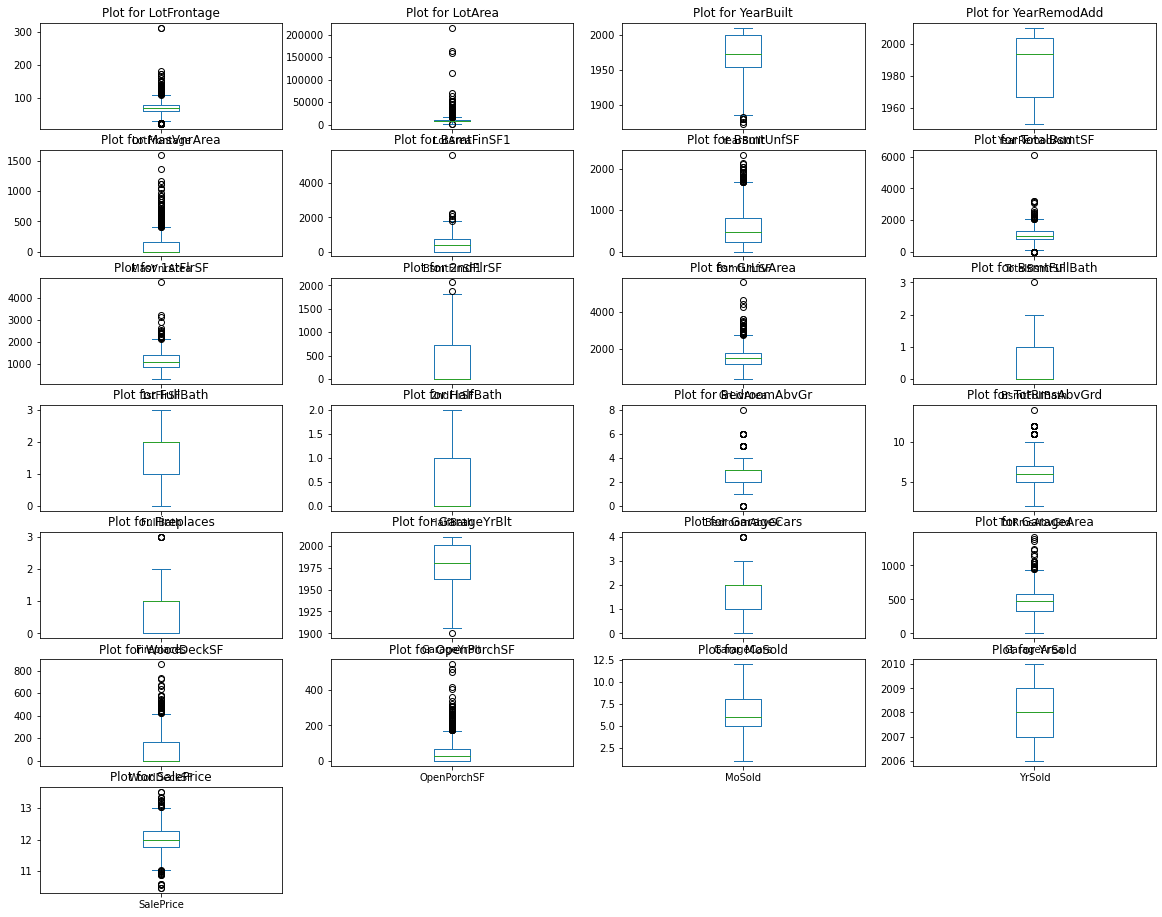

In [38]:
showBoxSubPlots(dfinit)

### Outlier treatment

#### Inspecting Outliers % values in all numerical columns

In [39]:
# Identifying out all outliers in the dataframe and printing their % within the data:
numCols,ObjectCols=getNumObjectCols(dfinit)
for c in numCols:
    dfo,count,prcnt=getOutliers(dfinit,c)
    printmd(f'For **{c}**; there are total **{count}** outliers which is **{round(prcnt,2)}%** of the whole data')

For **LotFrontage**; there are total **93** outliers which is **6.37%** of the whole data

For **LotArea**; there are total **69** outliers which is **4.73%** of the whole data

For **YearBuilt**; there are total **7** outliers which is **0.48%** of the whole data

For **YearRemodAdd**; there are total **0** outliers which is **0.0%** of the whole data

For **MasVnrArea**; there are total **98** outliers which is **6.71%** of the whole data

For **BsmtFinSF1**; there are total **7** outliers which is **0.48%** of the whole data

For **BsmtUnfSF**; there are total **29** outliers which is **1.99%** of the whole data

For **TotalBsmtSF**; there are total **61** outliers which is **4.18%** of the whole data

For **1stFlrSF**; there are total **20** outliers which is **1.37%** of the whole data

For **2ndFlrSF**; there are total **2** outliers which is **0.14%** of the whole data

For **GrLivArea**; there are total **31** outliers which is **2.12%** of the whole data

For **BsmtFullBath**; there are total **1** outliers which is **0.07%** of the whole data

For **FullBath**; there are total **0** outliers which is **0.0%** of the whole data

For **HalfBath**; there are total **0** outliers which is **0.0%** of the whole data

For **BedroomAbvGr**; there are total **35** outliers which is **2.4%** of the whole data

For **TotRmsAbvGrd**; there are total **30** outliers which is **2.05%** of the whole data

For **Fireplaces**; there are total **5** outliers which is **0.34%** of the whole data

For **GarageYrBlt**; there are total **1** outliers which is **0.07%** of the whole data

For **GarageCars**; there are total **5** outliers which is **0.34%** of the whole data

For **GarageArea**; there are total **21** outliers which is **1.44%** of the whole data

For **WoodDeckSF**; there are total **32** outliers which is **2.19%** of the whole data

For **OpenPorchSF**; there are total **77** outliers which is **5.27%** of the whole data

For **MoSold**; there are total **0** outliers which is **0.0%** of the whole data

For **YrSold**; there are total **0** outliers which is **0.0%** of the whole data

For **SalePrice**; there are total **28** outliers which is **1.92%** of the whole data

### Fix Outlier and show boxplots

**insights:**

From the above table, we can see that if we remove outliers, it will deduct 2/3 of the data and emulate them with values at 95 and 5 quantiles

In [40]:
numCols,ObjectCols=getNumObjectCols(dfinit)
for col in numCols:
    dfinit[col][dfinit[col] <= dfinit[col].quantile(0.05)] = dfinit[col].quantile(0.05)
    dfinit[col][dfinit[col] >= dfinit[col].quantile(0.95)] = dfinit[col].quantile(0.95)


In [41]:
len(dfinit.columns)

71

## Let's visualize the correlation


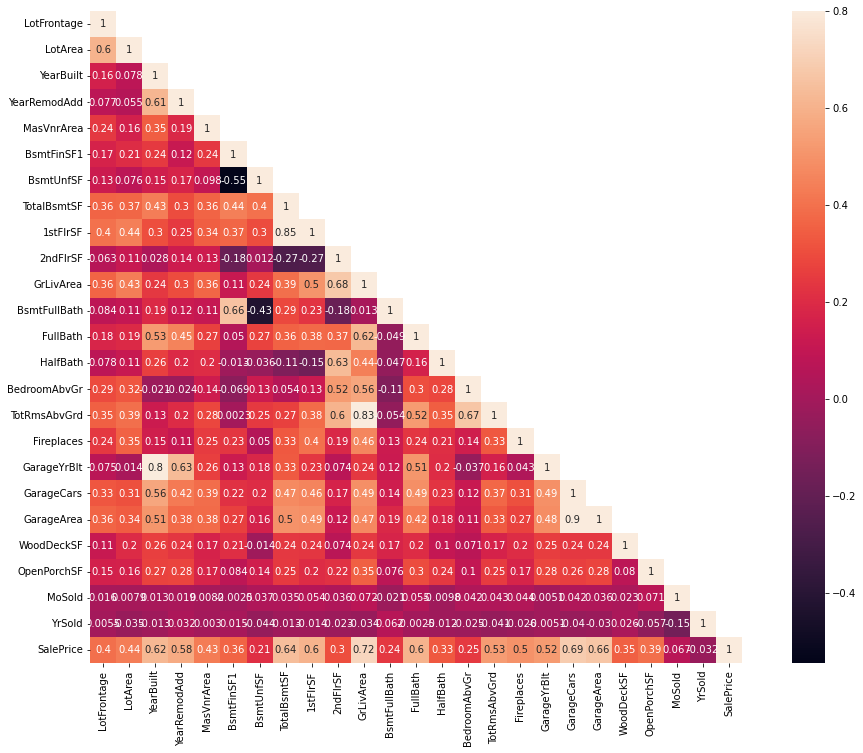

In [42]:
# corrColumns = bikes[["temp","atemp","hum","windspeed","cnt"]].corr()
ls=list(dfinit.columns)
corrColumns = dfinit[ls].corr()
aCorr = np.array(corrColumns)

aCorr[np.tril_indices_from(aCorr)] = False
fig,ax= plt.subplots()
fig.set_size_inches(18,12)
sns.heatmap(corrColumns, mask=aCorr,vmax=.8, square=True,annot=True)
plt.show()

**Insight:**
From the above graph, we can see that some features are highly correlated with each other (highlighted in lighter colors). These features can be dropped

## Let's create the pair plot to analyze the correlation further.

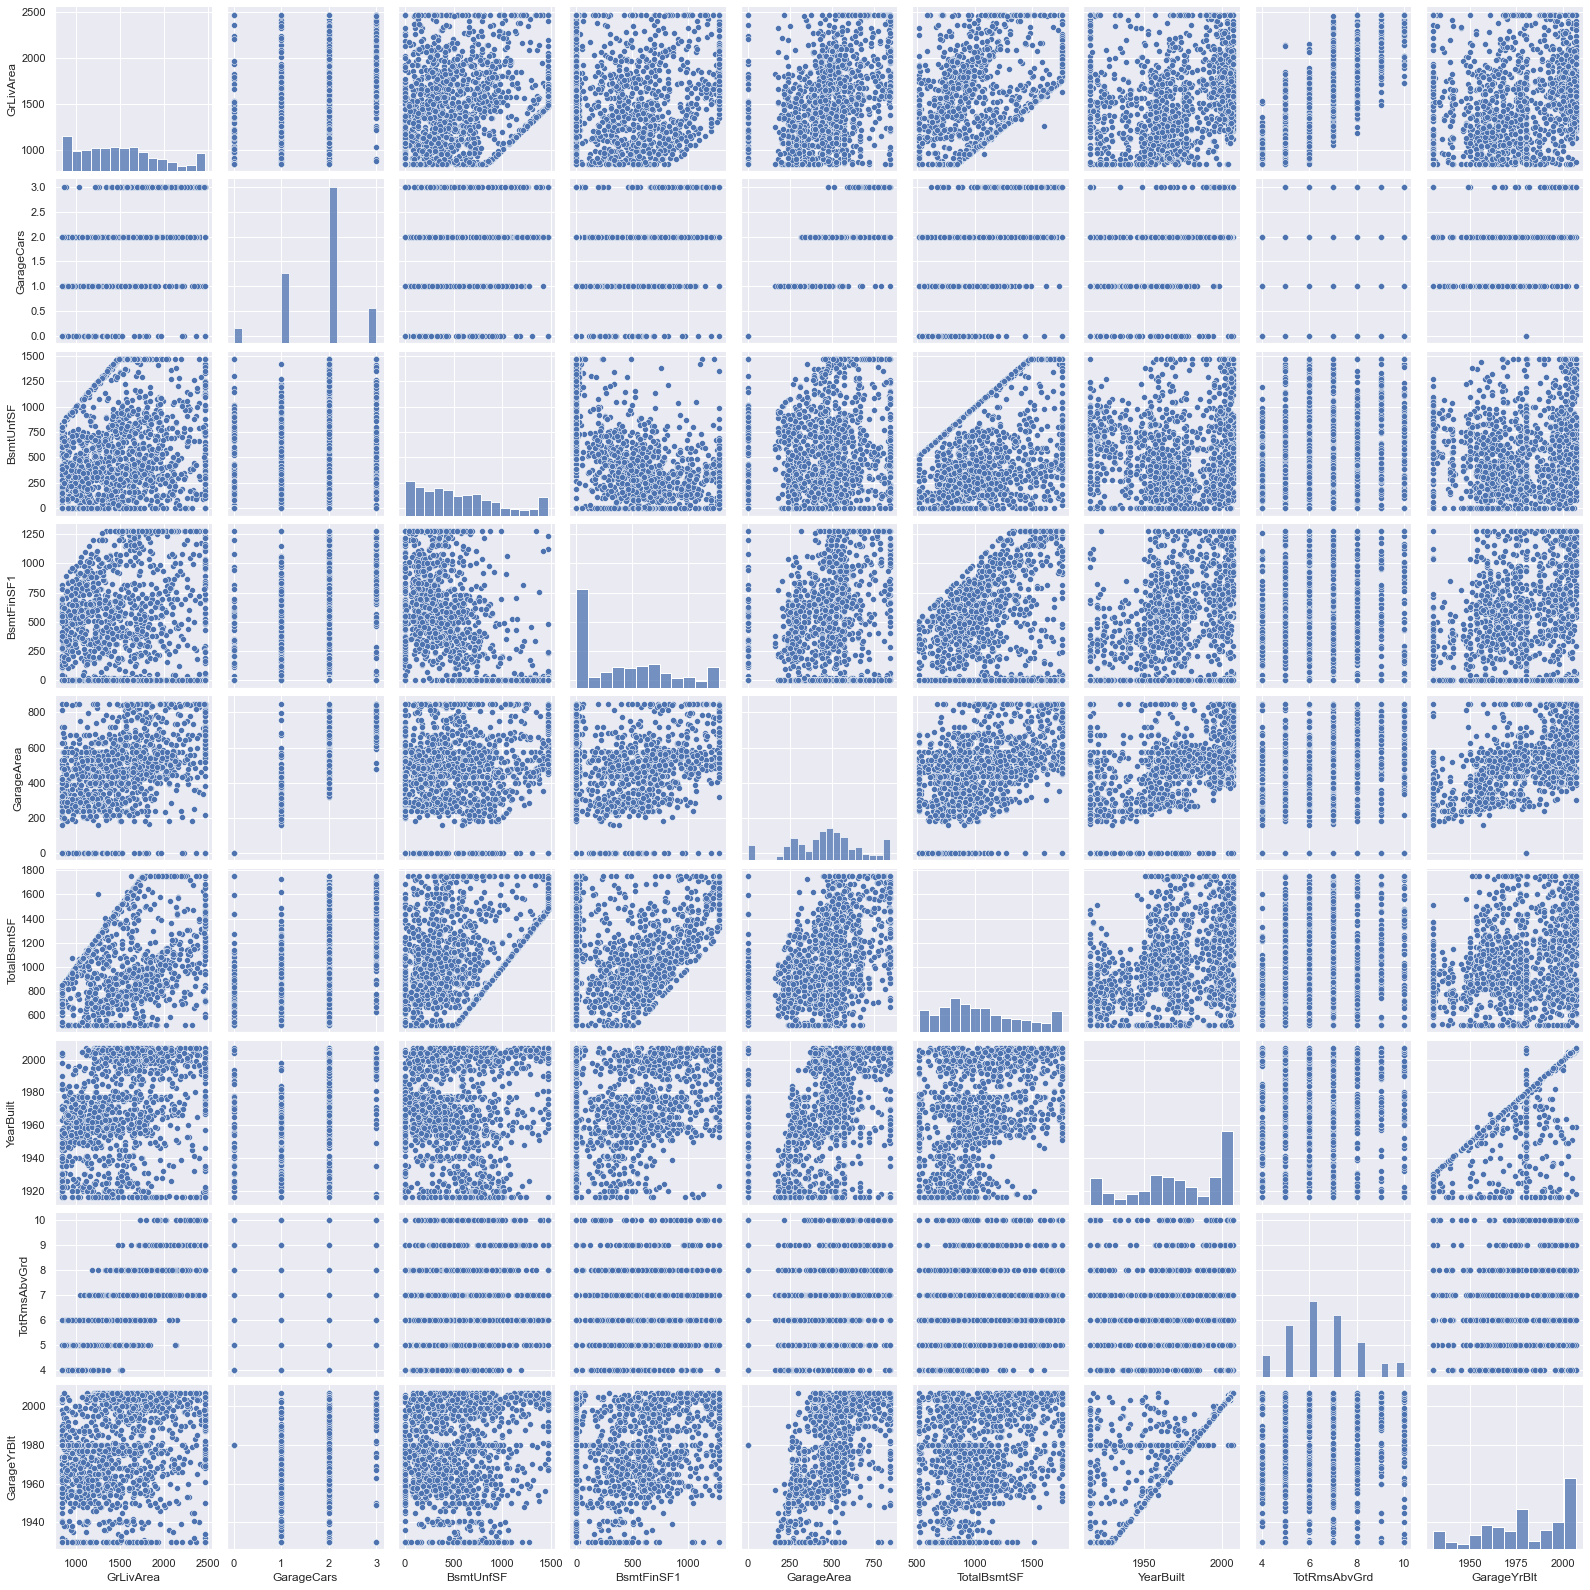

In [43]:
# Checking the same with a pairplot 
sns.set()
cols = ['GrLivArea', 'GarageCars', 'BsmtUnfSF', 'BsmtFinSF1', 'GarageArea', 'TotalBsmtSF', 'YearBuilt', 'TotRmsAbvGrd', 'GarageYrBlt']
sns.pairplot(dfinit[cols], size = 2.5)
plt.show()

**Insight:**
From the above graph, we can see that some features are highly correlated with each other and not contributing to the SalePrice target, so we can drop them

In [44]:
cols2Drop=['GarageCars','BsmtUnfSF','TotRmsAbvGrd','GarageYrBlt']
dfinit=dfinit.drop(cols2Drop, axis = 1)
  

## Derived Metrics - ( Data/Business/Type):


### Derived columns

#### AgeOftheProperty

In [45]:
# we can create a variable 'AgeOftheProperty' and remove some of the variables for easier analysis
dfinit['AgeOftheProperty']=(dfinit['YrSold'] - dfinit['YearBuilt'])

#### IsRemodeld

In [46]:
dfinit['IsRemodeld']=(dfinit['YearRemodAdd'] ==dfinit['YearBuilt']).astype('int64')


Now there is no need for variables such as YrSold and YearBuilt as they are not described by column AgeOftheProperty
Same is true for YearBuilt and YearRemodelAdd


### Drop columns


In [47]:
# since we no more need these columns we can delete them
cols2Del=['YrSold','YearBuilt','YearRemodAdd']
dfinit = dfinit.drop(cols2Del, axis = 1)


### Dummy Variables


In [48]:
len(dfinit.columns)

66

In [49]:
dfinit_num = dfinit.select_dtypes(include=['int64', 'float64'])
dfinit_cat = dfinit.select_dtypes(include='object')
dfinit_cat_encoded = pd.get_dummies(dfinit_cat, drop_first=True)

for col in dfinit_num.columns:
    dfinit_num[col][dfinit_num[col] <= dfinit_num[col].quantile(0.05)] = dfinit_num[col].quantile(0.05)
    dfinit_num[col][dfinit_num[col] >= dfinit_num[col].quantile(0.95)] = dfinit_num[col].quantile(0.95)
dfinit = pd.concat([dfinit_num, dfinit_cat_encoded], axis=1)


In [50]:
dfinit.T

0     \
LotFrontage                                                         65.000000   
LotArea                                                           8450.000000   
MasVnrArea                                                         196.000000   
BsmtFinSF1                                                         706.000000   
TotalBsmtSF                                                        856.000000   
1stFlrSF                                                           856.000000   
2ndFlrSF                                                           854.000000   
GrLivArea                                                         1710.000000   
BsmtFullBath                                                         1.000000   
FullBath                                                             2.000000   
HalfBath                                                             1.000000   
BedroomAbvGr                                                         3.000000   
Fireplaces                                                           0.000000   
GarageArea                                                         548.000000   
WoodDeckSF                                                           0.000000   
OpenPorchSF                                                         61.000000   
MoSold                                                               2.000000   
SalePrice                                                           12.247699   
AgeOftheProperty                                                     5.000000   
IsRemodeld                                                           1.000000   
MSSubClass_1-1/2 STORY FINISHED ALL AGES                             0.000000   
MSSubClass_1-STORY 1945 & OLDER                                      0.000000   
MSSubClass_1-STORY 1946 & NEWER ALL STYLES                           0.000000   
MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER     0.000000   
MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES                         0.000000   
MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES                 0.000000   
MSSubClass_2-1/2 STORY ALL AGES                                      0.000000   
MSSubClass_2-STORY 1945 & OLDER                                      0.000000   
MSSubClass_2-STORY 1946 & NEWER                                      1.000000   
MSSubClass_2-STORY PUD - 1946 & NEWER                                0.000000   
MSSubClass_DUPLEX - ALL STYLES AND AGES                              0.000000   
MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER                   0.000000   
MSSubClass_SPLIT FOYER                                               0.000000   
MSSubClass_SPLIT OR MULTI-LEVEL                                      0.000000   
MSZoning_FV                                                          0.000000   
MSZoning_RH                                                          0.000000   
MSZoning_RL                                                          1.000000   
MSZoning_RM                                                          0.000000   
Street_Pave                                                          1.000000   
Alley_NONE                                                           1.000000   
Alley_Pave                                                           0.000000   
LotShape_IR2                                                         0.000000   
LotShape_IR3                                                         0.000000   
LotShape_Reg                                                         1.000000   
LandContour_HLS                                                      0.000000   
LandContour_Low                                                      0.000000   
LandContour_Lvl                                                      1.000000   
Utilities_NoSeWa                                                     0.000000   
LotConfig_CulDSac                                                    0.000000   
LotConfig_FR2          

In [51]:
dfinit.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 274 columns):
 #    Column                                                            Dtype  
---   ------                                                            -----  
 0    LotFrontage                                                       float64
 1    LotArea                                                           float64
 2    MasVnrArea                                                        float64
 3    BsmtFinSF1                                                        int64  
 4    TotalBsmtSF                                                       float64
 5    1stFlrSF                                                          float64
 6    2ndFlrSF                                                          float64
 7    GrLivArea                                                         float64
 8    BsmtFullBath                                                      int64  
 9    FullBa

In [52]:
len(dfinit.columns)

274

In [53]:
dfinit.head().T

0  \
LotFrontage                                                         65.000000   
LotArea                                                           8450.000000   
MasVnrArea                                                         196.000000   
BsmtFinSF1                                                         706.000000   
TotalBsmtSF                                                        856.000000   
1stFlrSF                                                           856.000000   
2ndFlrSF                                                           854.000000   
GrLivArea                                                         1710.000000   
BsmtFullBath                                                         1.000000   
FullBath                                                             2.000000   
HalfBath                                                             1.000000   
BedroomAbvGr                                                         3.000000   
Fireplaces                                                           0.000000   
GarageArea                                                         548.000000   
WoodDeckSF                                                           0.000000   
OpenPorchSF                                                         61.000000   
MoSold                                                               2.000000   
SalePrice                                                           12.247699   
AgeOftheProperty                                                     5.000000   
IsRemodeld                                                           1.000000   
MSSubClass_1-1/2 STORY FINISHED ALL AGES                             0.000000   
MSSubClass_1-STORY 1945 & OLDER                                      0.000000   
MSSubClass_1-STORY 1946 & NEWER ALL STYLES                           0.000000   
MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER     0.000000   
MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES                         0.000000   
MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES                 0.000000   
MSSubClass_2-1/2 STORY ALL AGES                                      0.000000   
MSSubClass_2-STORY 1945 & OLDER                                      0.000000   
MSSubClass_2-STORY 1946 & NEWER                                      1.000000   
MSSubClass_2-STORY PUD - 1946 & NEWER                                0.000000   
MSSubClass_DUPLEX - ALL STYLES AND AGES                              0.000000   
MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER                   0.000000   
MSSubClass_SPLIT FOYER                                               0.000000   
MSSubClass_SPLIT OR MULTI-LEVEL                                      0.000000   
MSZoning_FV                                                          0.000000   
MSZoning_RH                                                          0.000000   
MSZoning_RL                                                          1.000000   
MSZoning_RM                                                          0.000000   
Street_Pave                                                          1.000000   
Alley_NONE                                                           1.000000   
Alley_Pave                                                           0.000000   
LotShape_IR2                                                         0.000000   
LotShape_IR3                                                         0.000000   
LotShape_Reg                                                         1.000000   
LandContour_HLS                                                      0.000000   
LandContour_Low                                                      0.000000   
LandContour_Lvl                                                      1.000000   
Utilities_NoSeWa                                                     0.000000   
LotConfig_CulDSac                                                    0.000000   
LotConfig_FR2             

In [54]:
dfinit.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 274 columns):
 #    Column                                                            Dtype  
---   ------                                                            -----  
 0    LotFrontage                                                       float64
 1    LotArea                                                           float64
 2    MasVnrArea                                                        float64
 3    BsmtFinSF1                                                        int64  
 4    TotalBsmtSF                                                       float64
 5    1stFlrSF                                                          float64
 6    2ndFlrSF                                                          float64
 7    GrLivArea                                                         float64
 8    BsmtFullBath                                                      int64  
 9    FullBa

### Create X and y Variables


In [55]:
X = dfinit.drop(['SalePrice'], axis=1) # get all the variables besides SalesPrice
y = dfinit['SalePrice'] # Get the salesPrice


In [56]:
# Splitting the data into train and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

## Scalling variables

In [57]:
print('done')

done


In [58]:

len(X.columns)

273

In [59]:
X.T

0     \
LotFrontage                                                         65.0   
LotArea                                                           8450.0   
MasVnrArea                                                         196.0   
BsmtFinSF1                                                         706.0   
TotalBsmtSF                                                        856.0   
1stFlrSF                                                           856.0   
2ndFlrSF                                                           854.0   
GrLivArea                                                         1710.0   
BsmtFullBath                                                         1.0   
FullBath                                                             2.0   
HalfBath                                                             1.0   
BedroomAbvGr                                                         3.0   
Fireplaces                                                           0.0   
GarageArea                                                         548.0   
WoodDeckSF                                                           0.0   
OpenPorchSF                                                         61.0   
MoSold                                                               2.0   
AgeOftheProperty                                                     5.0   
IsRemodeld                                                           1.0   
MSSubClass_1-1/2 STORY FINISHED ALL AGES                             0.0   
MSSubClass_1-STORY 1945 & OLDER                                      0.0   
MSSubClass_1-STORY 1946 & NEWER ALL STYLES                           0.0   
MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER     0.0   
MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES                         0.0   
MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES                 0.0   
MSSubClass_2-1/2 STORY ALL AGES                                      0.0   
MSSubClass_2-STORY 1945 & OLDER                                      0.0   
MSSubClass_2-STORY 1946 & NEWER                                      1.0   
MSSubClass_2-STORY PUD - 1946 & NEWER                                0.0   
MSSubClass_DUPLEX - ALL STYLES AND AGES                              0.0   
MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER                   0.0   
MSSubClass_SPLIT FOYER                                               0.0   
MSSubClass_SPLIT OR MULTI-LEVEL                                      0.0   
MSZoning_FV                                                          0.0   
MSZoning_RH                                                          0.0   
MSZoning_RL                                                          1.0   
MSZoning_RM                                                          0.0   
Street_Pave                                                          1.0   
Alley_NONE                                                           1.0   
Alley_Pave                                                           0.0   
LotShape_IR2                                                         0.0   
LotShape_IR3                                                         0.0   
LotShape_Reg                                                         1.0   
LandContour_HLS                                                      0.0   
LandContour_Low                                                      0.0   
LandContour_Lvl                                                      1.0   
Utilities_NoSeWa                                                     0.0   
LotConfig_CulDSac                                                    0.0   
LotConfig_FR2                                                        0.0   
LotConfig_FR3                                                        0.0   
LotConfig_Inside                                                     1.0   
LandSlope_Mod                                                        0.0   
LandSlope_Sev                           

In [60]:

X_train.sum().sum()

17655875.03157025

In [61]:
## Create a scaling instance
numCols,ObjectCols=getNumObjectCols(X_train)

num_cols = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
numCols=num_cols

scaler = StandardScaler()

## Scale the numerical columns 

X_train[numCols] = scaler.fit_transform(X_train[numCols])

X_test[numCols] = scaler.transform(X_test[numCols])


In [62]:
X_train.sum().sum()

46951.0

In [63]:
def show_metrics(y_train, y_train_pred, y_test, y_pred):
    ''' 
    Takes in the values of true y_train and y_test, and predicted y_train and y_test.
    returns the list containing the following metrics
    1. R-Squared (Train)
    2. R-Squared (Test)
    3. RSS (Train)
    4. RSS (Test)
    5. MSE (Train)
    6. MSE (Test)
    7. RMSE (Train)
    8. RMSE (Test)
    
    Returns a list containing all the above eight metrics

    
    '''
    
    ## Create a list to save all metrics (will be used in creating a final summary in the end)
    metric = []
    
    ## R-squared of train and test data
    metric.append(r2_score(y_train, y_train_pred))
    metric.append(r2_score(y_test, y_pred))
    
    ## Residual sum of squares of train and test data
    rss_train = np.sum(np.square(y_train - y_train_pred))
    metric.append(rss_train)
    rss_test = np.sum(np.square(y_test - y_pred))
    metric.append(rss_test)
      
    ## Mean Squared Error of train and test data
    mse_train = mean_squared_error(y_train, y_train_pred)
    metric.append(mse_train)
    mse_test = mean_squared_error(y_test, y_pred)
    metric.append(mse_test)
  
    
    # Root Mean Squared Error for train and test data
    rmse_train = mse_train**0.5
    metric.append(rmse_train)
    rmse_test = mse_test**0.5
    metric.append(rmse_test)
    return metric



def Predict(estimatorlabel,alpha=-1):
    ''' 
    Takes the model labbel and alpha. If alpha--1 then it will not use it bur rather
    calculate it from the model
    
    Returns metrics,model, best selected alpha

    
    '''
    if alpha==-1:
        estimator=Ridge()
        if estimatorlabel.lower()=='lasso':
            estimator=Lasso()

        params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
             0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
             4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

        model_cv = GridSearchCV(estimator = estimator, 
                                param_grid = params, 
                                scoring= 'neg_mean_absolute_error', 
                                cv = 5, 
                                return_train_score=True,
                                verbose = 1,n_jobs=-1)            
        model_cv.fit(X_train, y_train) 
    #     print(f'the best lambda value is {model_cv.best_params_}')
        alpha = model_cv.best_params_["alpha"]

    model= Ridge(alpha=alpha)
    if estimatorlabel.lower()=='lasso':
        model=Lasso(alpha=alpha)

    model.fit(X_train, y_train)
#     print(ridge.coef_)
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    metrics = show_metrics(y_train, y_train_pred, y_test, y_pred)
    printmd(f'**The best value of lambda/alpha for {estimatorlabel} regression is:** `{alpha}`')
    return metrics,model,alpha
def showMetric(RMetrics,LMetrics):
    ''' 
    Takes the Ridge and Lasso Models and return a dataframe contianing R Score and other parameters

    
    Returns Dataframe contianing R2 and other parameters

    
    '''
    lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                           'MSE (Train)','MSE (Test)', 'RMSE (Train)', 'RMSE (Test)'],
                'Ridge Regression' : RMetrics,
                'Lasso Regression' : LMetrics
            }
    final_metric = pd.DataFrame(lr_table, columns = ['Metric', 'Ridge Regression', 'Lasso Regression'] )
    final_metric.set_index('Metric')
    return final_metric
def Cofficients(ridge,lasso,X):
    ''' 
    Takes the Ridge and Lasso Models and return dataframe containing cofficients of the both
    and Ridge and Lasso 
    
    Returns Dataframe coafficents of Ridge and Lasso , and tables for top 10 features
    of Ridge and Lasso regregression

    
    '''
    ## First create empty datafame with all the independent variables as indices
    pd.set_option('display.max_rows', None)
    betas = pd.DataFrame(index=X.columns)
    betas.rows = X.columns
    betas['Ridge'] = ridge.coef_
    betas['Lasso'] = lasso.coef_
    
    #Since we took the log for `SalePrice` target we need to take the `exp` (inverse log) for the selected features
    RCoeffsE = np.exp(betas['Ridge'])
    RTable=RCoeffsE.sort_values(ascending=False).reset_index().head(10)
    LCoeffsE = np.exp(betas['Lasso'])
    LTable=LCoeffsE.sort_values(ascending=False).reset_index().head(10)
    return betas,RTable,LTable

##  Ridge Regression

In [64]:
ridge_metrics,ridge,ridge_alpha=Predict('Ridge')

Fitting 5 folds for each of 28 candidates, totalling 140 fits


**The best value of lambda/alpha for Ridge regression is:** `5.0`

##  Lasso Regression

In [65]:
lasso_metrics,lasso,lasso_alpha=Predict('Lasso')

Fitting 5 folds for each of 28 candidates, totalling 140 fits


**The best value of lambda/alpha for Lasso regression is:** `0.001`

##  Compare Lasso & Ridge Regression

In [66]:
final_metric=showMetric(ridge_metrics,lasso_metrics)
final_metric


Metric  Ridge Regression  Lasso Regression
0  R2 Score (Train)          0.937771          0.917365
1   R2 Score (Test)          0.920668          0.921138
2       RSS (Train)          8.857145         11.761520
3        RSS (Test)          3.094007          3.075673
4       MSE (Train)          0.007583          0.010070
5        MSE (Test)          0.010596          0.010533
6      RMSE (Train)          0.087081          0.100348
7       RMSE (Test)          0.102936          0.102631

**Insights:**

From above, we can see that the `R2 Score` for  Ridge regression is better than  Lasso (0.938 vs. 0.917); however, both are almost the same for the test data.


In [67]:
## First create empty datafame with all the independent variables as indices

betas,RTable,LTable=Cofficients(ridge,lasso,X)


In [68]:

nprcnt=100*round(betas[round(betas['Lasso'],3)==0].shape[0] / betas.shape[0],2)
printmd(f'**Insights:** </br> From above we can see `Lasso` regression has removed around  **{nprcnt}%** variables')

**Insights:** </br> From above we can see `Lasso` regression has removed around  **72.0%** variables

## Inferences


## How well those variables describe the price of a house?

#### Top 10 features - Lasso & Ridge regression

In [69]:
# RTable and LTable returned by Cofficients(ridge,lasso,X) functions above
displaySideBySide (RTable,LTable)

index 
 Ridge 
 
 
 
 
 0 
 SaleCondition_Alloca 
 1.121828 
 
 
 1 
 OverallCond_Excellent 
 1.094511 
 
 
 2 
 GrLivArea 
 1.092623 
 
 
 3 
 OverallQual_Very Good 
 1.092242 
 
 
 4 
 Neighborhood_Crawfor 
 1.089806 
 
 
 5 
 OverallQual_Excellent 
 1.077659 
 
 
 6 
 Exterior1st_BrkFace 
 1.071280 
 
 
 7 
 Functional_Typ 
 1.070978 
 
 
 8 
 Neighborhood_StoneBr 
 1.067795 
 
 
 9 
 CentralAir_Y 
 1.060948 
 
 
 
 
 
 
 index 
 Lasso 
 
 
 
 
 0 
 GrLivArea 
 1.114956 
 
 
 1 
 OverallQual_Very Good 
 1.105810 
 
 
 2 
 OverallQual_Excellent 
 1.094399 
 
 
 3 
 Neighborhood_Crawfor 
 1.090746 
 
 
 4 
 Functional_Typ 
 1.071566 
 
 
 5 
 Exterior1st_BrkFace 
 1.062903 
 
 
 6 
 OverallCond_Excellent 
 1.061340 
 
 
 7 
 CentralAir_Y 
 1.057362 
 
 
 8 
 Neighborhood_Somerst 
 1.048981 
 
 
 9 
 Condition1_Norm 
 1.044971

**Insgihts:**

**Following are the top 5 features:**

**1) Above grade (ground) living area** (GrLivArea ): The value of the house will be increased by 1.09 to 1.11 times if we increase one (1) square foot of `Above grade (ground) living area`.

**2) Neighborhood Crawfor**: The value of the house will be increased by 1.09  times if the house is in this neighborhood

**3) Overall Quality Excellent**:  The house's value will be increased by 1.06 to 1.08 times if the house's overall quality is excellent.

**4) Overall Quality Very Good**: The house's value will be increased by 1.09 to 1.11 times if the house's overall quality is very good.

**5) Overall Condition Excellent**: The house's value will be increased by 1.06 to 1.09 times if the overall condition is excellent.




# Quesitons/Answere for Assignment Part-II

## Question 1

What is the optimal value of alpha for ridge and lasso regression? What will be the changes in the model if you choose double the value of alpha for both ridge and lasso? What will be the most important predictor variables after the change is implemented?

## Answer


##### What is the optimal value of alpha for ridge and lasso regression?
#### Ridge Regression = 5.0
#### Lasso = 0.001

### What will be the changes in the model if you choose double the value of alpha for both ridge and lasso?

In [70]:
ridge_metrics,ridge,ridge_alpha=Predict('Ridge',ridge_alpha*2)
lasso_metrics,lasso,lasso_alpha=Predict('Lasso',lasso_alpha*2)
Double_metric=showMetric(ridge_metrics,lasso_metrics)

printmd("## ------------Origional ------------------------Double the value of alpha-----")
displaySideBySide (final_metric,Double_metric)


**The best value of lambda/alpha for Ridge regression is:** `10.0`

**The best value of lambda/alpha for Lasso regression is:** `0.002`

## ------------Origional ------------------------Double the value of alpha-----

Metric 
 Ridge Regression 
 Lasso Regression 
 
 
 
 
 0 
 R2 Score (Train) 
 0.937771 
 0.917365 
 
 
 1 
 R2 Score (Test) 
 0.920668 
 0.921138 
 
 
 2 
 RSS (Train) 
 8.857145 
 11.761520 
 
 
 3 
 RSS (Test) 
 3.094007 
 3.075673 
 
 
 4 
 MSE (Train) 
 0.007583 
 0.010070 
 
 
 5 
 MSE (Test) 
 0.010596 
 0.010533 
 
 
 6 
 RMSE (Train) 
 0.087081 
 0.100348 
 
 
 7 
 RMSE (Test) 
 0.102936 
 0.102631 
 
 
 
 
 
 
 Metric 
 Ridge Regression 
 Lasso Regression 
 
 
 
 
 0 
 R2 Score (Train) 
 0.933794 
 0.901553 
 
 
 1 
 R2 Score (Test) 
 0.923621 
 0.905400 
 
 
 2 
 RSS (Train) 
 9.423107 
 14.011955 
 
 
 3 
 RSS (Test) 
 2.978828 
 3.689454 
 
 
 4 
 MSE (Train) 
 0.008068 
 0.011997 
 
 
 5 
 MSE (Test) 
 0.010201 
 0.012635 
 
 
 6 
 RMSE (Train) 
 0.089821 
 0.109529 
 
 
 7 
 RMSE (Test) 
 0.101002 
 0.112406

###### Changes in Ridge Regression
- R2 score for Train data changed from 0.938 to 0.934
- R2 score for Test data changed from 0.921 to 0.924

## Changes in Lasso Regression
- R2 score for Train data changed from 0.917 to 0.924
- R2 score for Test data changed from 0.921 to  0.905

### What will be the most important predictor variables after the change is implemented??

In [71]:
betas,RTable,LTable=Cofficients(ridge,lasso,X)
displaySideBySide (RTable,LTable)

index 
 Ridge 
 
 
 
 
 0 
 GrLivArea 
 1.088171 
 
 
 1 
 OverallQual_Very Good 
 1.087446 
 
 
 2 
 Neighborhood_Crawfor 
 1.080527 
 
 
 3 
 OverallCond_Excellent 
 1.078912 
 
 
 4 
 SaleCondition_Alloca 
 1.077054 
 
 
 5 
 Functional_Typ 
 1.068115 
 
 
 6 
 OverallQual_Excellent 
 1.067347 
 
 
 7 
 Exterior1st_BrkFace 
 1.064877 
 
 
 8 
 CentralAir_Y 
 1.056909 
 
 
 9 
 Neighborhood_StoneBr 
 1.055198 
 
 
 
 
 
 
 index 
 Lasso 
 
 
 
 
 0 
 GrLivArea 
 1.117706 
 
 
 1 
 OverallQual_Very Good 
 1.085386 
 
 
 2 
 Neighborhood_Crawfor 
 1.073729 
 
 
 3 
 Functional_Typ 
 1.066856 
 
 
 4 
 CentralAir_Y 
 1.056417 
 
 
 5 
 OverallQual_Excellent 
 1.053166 
 
 
 6 
 TotalBsmtSF 
 1.047043 
 
 
 7 
 GarageArea 
 1.039777 
 
 
 8 
 Condition1_Norm 
 1.037421 
 
 
 9 
 OverallCond_Good 
 1.033314

#### The most important predictor variables after the change is implemented are:
- Neighborhood_Crawfor
- GrLivArea
- OverallQual_Excellent
- OverallQual_Very Good
- OverallCond_Excellent
- Functional_Typ





## Question 2

You have determined the optimal value of lambda for ridge and lasso regression during the assignment. Now, which one will you choose to apply and why?

 

## Answer


I would choose **Lasso** regression. It has simplified the model significantly by removing over 56% of features, yet it is still robust and comparable to the Ridge regression.


## Question 3

After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

## Answer


**Top 5 features of Lasso are:**

- GrLivArea	
- Neighborhood_Crawfor
- OverallQual_Excellent
- OverallQual_Very Good
- OverallCond_Excellent




In [72]:
cols2drop=[
'SalePrice',
'OverallQual_Excellent',
'Neighborhood_Crawfor',
'OverallQual_Very Good',
'OverallCond_Excellent',
'GrLivArea',
]

X = dfinit.drop(cols2drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=50)
lasso_metrics,lasso,lasso_alpha=Predict('Lasso')
ridge_metrics,ridge,ridge_alpha=Predict('Ridge')
final_metric=showMetric(ridge_metrics,lasso_metrics)
betas,RTable,LTable=Cofficients(ridge,lasso,X_train)
LTable.head(5)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


**The best value of lambda/alpha for Lasso regression is:** `0.0001`

Fitting 5 folds for each of 28 candidates, totalling 140 fits


**The best value of lambda/alpha for Ridge regression is:** `10.0`

index     Lasso
0        Condition2_PosA  1.271885
1   SaleCondition_Alloca  1.167360
2       RoofMatl_Membran  1.163307
3           SaleType_Oth  1.131666
4  SaleCondition_AdjLand  1.130392

Here are the top five(5) features after we removed prior top 5 variables

- Condition2_PosA	      
- SaleCondition_Alloca	
- RoofMatl_Membran	  
- SaleType_Oth	      
- SaleCondition_AdjLand	

## Question 4

How can you make sure that a model is robust and generalisable? What are the implications of the same for the accuracy of the model and why?

## Answer


First, define the terms:

**Robust**: A model is considered robust when data variation does not significantly affect its performance.


**Generalizable**: A model can adapt appropriately to new, previously unseen data drawn from the same distribution as the one used to create the model

**Accuracy**: How close calculated values are to their actuals.

Let’s break the question into two parts:

1) How can you make sure that a model is robust and generalisable?



- To ensure a model is robust and generalizable, we need to make it `simple` and `not overfit` as it may fail on the unseen data. The overfit can be sensed by looking at the R2 scores of the test and train data. The model has learned the train data if the score is very high on train data but much lower on test data.

II)  What are the implications of the same for the accuracy of the model and why?

- A complex model will have very high accuracy, but with a complex model the robustness and generalization of the model will be compromised. Also, such a model's maintenance will be far higher than a simpler model, so we need to balance model accuracy and complexity. This can be achieved by Regularization techniques like Ridge Regression and Lasso.


In [73]:
print ('Thanks')

Thanks
